<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/avazu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# Last amended: 10th Oct, 2023
# Click through rate prediction
# Experiments have been done on Jupyter Notebook and NOT on colab
# All saved data is available on gdrive for recall and run the expt again from any point
# Data Source: https://www.kaggle.com/competitions/avazu-ctr-prediction/data

"""

In [ ]:
"""
# THIS FILE IS NAMED AS PER THE DATASIZE READ: 50lakh observations
"""

In [1]:
##
## ??????????????????? W A R N E D ??????????????????????????
##
##
## ??????????????????? STOP STOP STOP ??????????????????????????
##
# -0.2 WARN Will delete all earlier work

#   Delete talkingdatafolder, if it exists
#   Cleanup earlier saved data:

"""
from pathlib import Path
import shutil
talkingdata = Path("D:\\talkingdata\\allmodels")

if talkingdata.exists():
    shutil.rmtree(talkingdata)
    
"""    

## Basics

In [2]:
# -0.2 
! pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# -0.1
! pip install tabulate

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# 0.1

!pip install catencfamily==0.0.95


Defaulting to user installation because normal site-packages is not writeable


In [1]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import gc,time




# 1.0.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import  TSNE
#from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,f1_score,roc_auc_score

# 1.0.2
import networkx as nx
from networkx import community

# 1.0.3
import matplotlib.pyplot as plt
import seaborn as sns

# 1.0.4
import xgboost as xgb
import optuna
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils


# 1.0.5
import shutil
from pathlib import Path
import itertools
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'graph_tool', 'leidenalg', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


In [2]:
# 1.0.6 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# 1.0.7 Decide program-wide random state:

rng= np.random.RandomState(None)

In [4]:
# 1.0.8 Folders where outputs will be saved:

# 1.0.8.1 This folder is the top of tree
talkingdata = Path("D:\\talkingdata\\allmodels")

# 1.0.8.2 Folders beneath it
graphsPath = talkingdata / "graphs"     # For graph files
dataPath = talkingdata / "datafiles"    # For data files
modelsPath = talkingdata /"models"      # For saved models
estimatorsPath = talkingdata / "estimators"  # For fitted estimators
unitvecsPath = talkingdata  / "unitvec"      # For unitvectors
mapdictpath = talkingdata / "mapdictpath"
skippedRowsPath = talkingdata / "skippedrowspath"

In [7]:
# 1.0.9 Create folders if they do not exist:

talkingdata.mkdir(parents=True, exist_ok=True)    
pathToStoreProgress = talkingdata
graphsPath.mkdir(parents=True, exist_ok=True) 
dataPath.mkdir(parents=True, exist_ok=True) 
modelsPath.mkdir(parents=True, exist_ok=True)  
estimatorsPath.mkdir(parents=True, exist_ok=True)  
unitvecsPath.mkdir(parents=True, exist_ok=True)  
mapdictpath.mkdir(parents=True, exist_ok=True)  
skippedRowsPath.mkdir(parents=True, exist_ok=True)  




## Taking a sample of data
We plan to divide data randomly into two parts. With a sample from the first part, we create a model (using <i>CatEncodersFamily</i>). The model tells us how to map categorical features to numeric features. Once the model is created, we will randomly select data from the IInd part. We will further split this data into X_train and X_test for building and testing ML model. We will then transform X_train and X_test to numeric features (X_train_trans, X_test_trans)  using the mapping model created earlier (from the sampleof the first part).


In [396]:
# 2.0 Some functions

# 2.0.1
def gen_sep_arrays(total_lines_in_data,reserve_lines, skippedRowsPath ):
    """
    Desc
    ====
    This function saves two sets of randomly derived numbers (let us call them row 
     numbers) to disk. One set is 'seqArrayForModeling.npy' and the IInd set is
     'seqArrayForTesting.npy'. The row numbers would correspond to row-numbers of our 
    DataFrame for the complete train data.  
    
    parameters
    ============
    total_lines_in_data: int, No of rows in complete dataframe
    reserve_lines:       int, These number of rows would constitute the IInd split
                         One split is (total_lines_in_data - reserve_lines)
    skippedRowsPath: Folder where split sequences wil be stored 
    
    Returns
    ========
    Two '.npy' files saving two arrays of numbers each. These numbers correspond to row numbers 
    (and not the data). Saved files are: seqArrayForTesting.npy and seqArrayForModeling.npy
    """
    # Get an array of numbers
    # We know that our train data has amany rows
    filerows = np.arange(1,total_lines_in_data)
    
    # Shuffle this sequence randomly
    np.random.shuffle(filerows)  # Row 0 is not included
    
    # Split it into two sequences:
    seqArrayForModeling = filerows[:total_lines_in_data - reserve_lines]   # The first part. We use for
                                                                           # modeling
    seqArrayForTesting = filerows[total_lines_in_data - reserve_lines:]    # These rows must be skipped
    
    # Save the above two arrays
    path = Path(skippedRowsPath)
    np.save(path / "seqArrayForTesting.npy", seqArrayForTesting)
    np.save(path / "seqArrayForModeling.npy", seqArrayForModeling)


# 2.0.2 Reads train data after skipping specified row-numbers
def read_train_skipReserve(datafile,toSkip):
    """
    Desc
    =====
    It reads data from 'datafile' after skipping those
    rows listed in 'toSkip'. 
    
    parameters
    ===========
    datafile: Pandas dataframe to read
    toSkip:   numpy array. Array of row numbers to 
              be skipped. Should not include row 0
            
    Returns
    ========
    Dataframe excluding toSkip rows       
            
    """
     # dtypes
    dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

    # 2.02 Skip some rows
    train = pd.read_csv(
                     datafile,  # Not reading test.csv.zip
                     header=0,  # First row is header-row
                     dtype=dtypes,
                     # We read all columns. Here are the column-names
                     #  in the sequence they occur in the train data
                      usecols=['ip','app','device','os', 'channel', 'click_time', 'attributed_time', 'is_attributed'],
                      parse_dates=['click_time'],
                      skiprows = toSkip
                    )   # Takes 3 minute
    return train

# 2.0.3 Shuffles and outputs sample of dataframe
def sample_train(df, noOfRows):
    """
    This function returns a random sample of df with noOfRows.
    df: train data
    noOfRows: No of rows to return
    """
    samp = df.sample(frac = 1.0)  # shuffle data
    return samp[:noOfRows]


In [9]:
# 2.1 Create and save two sequences:

total_lines_in_data = 184903891   # 18,49,03,891  (18.5 crores)
reserve_lines       =   8000000   # Last reserve_lines
                                  #  for train/test data
                                  #    while building xgboost model

# 2.1.1 One array will have a length of reserve_lines 
#       And another array of numbers will have a length of
#      (total_lines_in_data - reserve_lines)
gen_sep_arrays(total_lines_in_data,
               reserve_lines,
               skippedRowsPath) 

In [10]:
# 2.2 We will skip these rows now while reading data for building our model

seqArrayForTesting  = np.load(skippedRowsPath / "seqArrayForTesting.npy")
print("Size of seqArrayForTesting: ", seqArrayForTesting.size)  # 7999999

Size of seqArrayForTesting:  7999999


In [11]:
# 2.2.1
gc.collect()
start = time.time()
# Read train data excepting reserve lines
dataFile = "d:\\talkingData\\train.csv.zip"
train_full = read_train_skipReserve(dataFile,
                                    seqArrayForTesting     # Rows to skip
                                    )
end = time.time()
print((end-start)/60)  # 3min
gc.collect()

11

2.821116868654887


0

In [12]:
# 2.2.2

print("train data read from disk after skipping seqArrayForTesting rows")
train_full.memory_usage().sum()   # 5130212967
train_full.shape     # (176903891, 8)                


train data read from disk after skipping seqArrayForTesting rows


5130212967

(176903891, 8)

In [13]:
# 2.2.3 Store train_full to disk. We need not read it again:
train_full.to_pickle(dataPath / "train_full.pkl")

In [14]:
# 2.2.4 Read stored data from disk:
train_full = pd.read_pickle(dataPath / "train_full.pkl")
train_full.shape  #  (176903891, 8)
gc.collect()

(176903891, 8)

0

In [15]:
# 2.2.5 Sample train_full to 90lakh rows:

train = sample_train(train_full, 9000000 )
print("train data sample taken of size: ", train.shape)

train data sample taken of size:  (9000000, 8)


In [16]:
# 2.2.6: Delete train_full. We no longer need it.

del train_full
gc.collect()

0

In [17]:
# 2.3  Extract date and time information from 'click_time':

train['day'] = train['click_time'].dt.day.astype('uint8')
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')

# 2.3.1 Renaming target column 'is_attributed' for conveneince
train = train.rename(columns = {'is_attributed' : 'isattributed'} )

# 2.3.2 Pop out notneeded columns
_ = train.pop('click_time')
_ = train.pop('attributed_time')
print("Sample data cleaned")
gc.collect()
train.shape

Sample data cleaned


24

(9000000, 10)

In [18]:
# 2.4 Just renaming:
X = train

# 2.5 Only for unsupervised
y = X.pop('isattributed')
y.shape  # (9000000,)

(9000000,)

## Instantiate and fit `CatEncodersFamily` class
We fit it on all the five cat features



In [20]:
# 3.0 These are our cat_cols:
cat_cols = ['app', 'device' , 'ip', 'channel','os']

# 3.1 These cols will intercat and create more columns
interactingCatCols = ['app', 'device', 'os', 'channel', 'ip']

# 3.2 Instantiate the CatEncodersFamily class:
ct = CatEncodersFamily(cMeasures=  [ 1,1,1,0,None,0,0], 
                    modelsPath = modelsPath, # Folder to store graph files
                    pathToStoreProgress  = pathToStoreProgress,
                    saveGraph = True,
                    k = 45 ,  # Nodes to consider for betweenness centrality
                    sampsize = 0.1,   # of X or train
                    n_iter = 25,   # Will take lots of time
                    avg = True,
                    mergethreshold = [0.0023],
                    mapDictPath = mapdictpath,
                    mergelevelsincols = ['ip'],
                    #avoidInteractionFeatures = ['ip'],   # Do not pair'ip' with generated interaction features
                                                          #  Only with features already existing
                    multigraph = False   
                       
                   )

In [21]:
# 3.3 Fit the object:

start = time.time()
ct.fit(train, cat_cols, interactingCatCols, y = y)
end = time.time()
print((end-start)/60)  # 4703 mins (3.3 days) on my slow machine


Sample size is:  (900000, 19)
No saved dictionary exists as yet.
Record set no is 1  
Set of records is:  [('app', 'device', [1, 1, 1, 0, None, 0, 0]), ('app', 'ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'os', [1, 1, 1, 0, None, 0, 0]), ('app', 'channel_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'device_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_device', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'device_p_channel', [1, 1, 1, 0, None, 0, 0]), ('app', 'os_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_ip', [1, 1, 1, 0, None, 0, 0]), ('app', 'device_p_os', [1, 1, 1, 0, None, 0, 0]), ('app', 'app_p_os', [1, 1, 1, 0, None, 0, 0]), ('app', 'os_p_channel', [1, 1, 1, 0, None, 0, 0]), ('device', 'app', [1, 1, 1, 0, None, 0, 0]), ('device', 'ip', [1, 1, 1, 0, None, 0, 0]), ('device', 'channel', [1, 1, 1, 0, None, 0, 0]), ('device', 'os', [1, 1, 1, 0, None, 0, 0]), ('device', 'channel_p_ip', [1, 1, 1, 0

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], k=45,
                  mapDictPath=WindowsPath('D:/talkingdata/allmodels/mapdictpath'),
                  mergelevelsincols=['ip'], mergethreshold=[0.0023],
                  modelsPath=WindowsPath('D:/talkingdata/allmodels/models'),
                  n_iter=25,
                  pathToStoreProgress=WindowsPath('D:/talkingdata/allmodels'),
                  sampsize=0.1, saveGraph=True)

4703.597723563512


### Save `CatEncodersFamily` object
Maybe for later use

In [22]:
# 3.3.1 Save the object:
utils.savePythonObject(ct, "ct.pkl", dataPath)

Object saved to: D:\talkingdata\allmodels\datafiles\ct.pkl


In [23]:
# 3.3.2 Restore it back: 
ct = utils.restorePythonObject("ct.pkl", dataPath)

In [24]:
# 3.3.3 Just check:
ct

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], k=45,
                  mapDictPath=WindowsPath('D:/talkingdata/allmodels/mapdictpath'),
                  mergelevelsincols=['ip'], mergethreshold=[0.0023],
                  modelsPath=WindowsPath('D:/talkingdata/allmodels/models'),
                  n_iter=25,
                  pathToStoreProgress=WindowsPath('D:/talkingdata/allmodels'),
                  sampsize=0.1, saveGraph=True)

In [32]:
# 3.3.4 We no longer need these
del train
gc.collect()

0

## Read data

In [25]:
# 3.3.5 Recapitulate folders:
#       Folders where outputs will be saved:

talkingdata = Path("D:\\talkingdata\\allmodels")


graphsPath = talkingdata / "graphs"     # For graph files
dataPath = talkingdata / "datafiles"    # For data files
modelsPath = talkingdata /"models"  # For saved models
estimatorsPath = talkingdata / "estimators"  # For fitted estimators
unitvecsPath = talkingdata  / "unitvec"      # For unitvectors
mapdictpath = talkingdata / "mapdictpath"
skippedRowsPath = talkingdata / "skippedrowspath"
cat_cols = ['app', 'device', 'os', 'channel','ip']
dataFile = "d:\\talkingData\\train.csv.zip"

In [26]:
# 4.0 Read the sequence numbers used for modeling:

trseq = np.load( skippedRowsPath / "seqArrayForModeling.npy")
trseq.size    # 176903891

176903891

In [27]:
# 4.0.1 Read all data but the rows trseq
#       They were already used while developing model
#       We will now transform these rows

train_s = read_train_skipReserve(dataFile, trseq)

In [28]:
# 4.0.2 About the read data:

train_s.shape     # (7999999, 8)
train_s.head(3)
train_s.dtypes

(7999999, 8)

ip  app  device  os  channel          click_time attributed_time  \
0  172522    3       1  25      379 2017-11-06 14:38:27             NaN   
1   80447    3       1  19      379 2017-11-06 14:40:51             NaN   
2   57576    3       1  19      379 2017-11-06 14:43:14             NaN   

   is_attributed  
0              0  
1              0  
2              0

ip                         uint32
app                        uint16
device                     uint16
os                         uint16
channel                    uint16
click_time         datetime64[ns]
attributed_time            object
is_attributed               uint8
dtype: object

In [29]:
# 4.0.3 Get a random sample from it and save it to disk:
read_lines = 5000000
train = train_s.sample(n = read_lines)
train.shape
train.to_pickle(dataPath / "train.pkl")

(5000000, 8)

In [30]:
# 4.0.4 Read saved sample back:

train = pd.read_pickle(dataPath / "train.pkl")
train.shape   # (5000000, 8)

(5000000, 8)

In [41]:
# 4.0.5 Delete what is not needed:

del train_s
del trseq
gc.collect()

0

### Extract date components

In [31]:
# 5.0  Extract date and time information from 'click_time'

train['day'] = train['click_time'].dt.day.astype('uint8')
train['hour'] = train['click_time'].dt.hour.astype('uint8')
train['minute'] = train['click_time'].dt.minute.astype('uint8')
train['second'] = train['click_time'].dt.second.astype('uint8')

# 5.1 Renaming target column 'is_attributed' for conveneince
train = train.rename(columns = {'is_attributed' : 'isattributed'} )

# 5.2 Pop out notneeded columns
_ = train.pop('click_time')
_ = train.pop('attributed_time')

In [32]:
# 5.2.1
train.shape  # (5000000, 10)
gc.collect()

(5000000, 10)

23

In [33]:
# 5.2.2
train.head(3)
train.shape  # (5000000, 10)
y = train.pop('isattributed')
y[:3]

ip  app  device  os  channel  isattributed  day  hour  minute  \
7754209   79857   20       1  19      488             0    9    14      13   
5073026  224181    3       1  13      130             0    8    14      35   
7699247   84644   11       1  19      137             0    9    13      52   

         second  
7754209      20  
5073026      23  
7699247       2

(5000000, 10)

7754209    0
5073026    0
7699247    0
Name: isattributed, dtype: uint8

## Partition data

In [34]:
# 6.0 Split our train data:

X_train, X_test, y_train, y_test = train_test_split(
                                                    train,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify= y,
                                                    shuffle = True,  # By default
                                                    random_state= rng)
  

In [35]:
# 6.0.1
X_train.shape    # (3750000, 9)
X_train.head(3)
X_test.shape     # (1250000, 9)
X_test.head(3)
y_train.head(2)
y_test.head(2)

(3750000, 9)

ip  app  device  os  channel  day  hour  minute  second
5920155   52924    3       1  19      489    9     1      31      26
6602667   16087   18       1  13      107    9     6       3       8
6185037  352750   14       1  16      379    9     3      30      17

(1250000, 9)

ip  app  device  os  channel  day  hour  minute  second
6077955   5314    6       1  17      459    9     2      42      56
5213844   4670   12       1  18      328    8    15      28      25
4862705  25073    3       1   1      280    8    13      15      34

5920155    0
6602667    0
Name: isattributed, dtype: uint8

6077955    0
5213844    0
Name: isattributed, dtype: uint8

In [37]:
# 6.0.2 Transform the X_train to numeric features:

start = time.time()
X_train_trans =  ct.transform(X_train[cat_cols])
end = time.time()
print((end-start)/60)  # 11m



====Reading all model-dicts from folder: D:\talkingdata\allmodels\models


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  210
====Sending model loading progress to file: D:\talkingdata\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 5745.0 MB
Mem usage after dtype transformation is: 2910.0 MB
11.05682708422343


In [38]:
# 6.0.3 Transform X_test to numeric features:

start = time.time()
X_test_trans =  ct.transform(X_test[cat_cols])
end = time.time()
print((end-start)/60) # 5min



====Reading all model-dicts from folder: D:\talkingdata\allmodels\models


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  210
====Sending model loading progress to file: D:\talkingdata\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 1915.0 MB
Mem usage after dtype transformation is: 970.0 MB
4.347329107920329


In [39]:
# 6.0.4 Train
X_train_trans.shape  # (3750000, 194)
X_train.shape   # (3750000, 9)
X_train_trans.head(3)  # Its index has been reset
X_train.head(3)
y_train.head(3)

(3750000, 194)

(3750000, 9)

app  device  os  channel     ip  deg_app_ck_channel  \
0    3       1  19      489  99999            0.236257   
1   18       1  13      107  99999            0.287249   
2   14       1  16      379  99999            0.376169   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.093158           0.815969                     0.192915   
1                 0.061707           0.817518                     0.202716   
2                 0.074716           0.764936                     0.231555   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.493658  ...           0.005024          0.007401   
1                0.619069  ...           0.005024          0.007319   
2                0.470143  ...           0.005024          0.007211   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.019993         0.005507                   0.007733   
1               0.018935         0.005507                   0.007684   
2               0.012382         0.005507                   0.007599   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.013290              0.005024     0.007747   
1              0.013481              0.005024     0.007735   
2              0.010920              0.005024     0.007067   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  
2               0.005024          0.005024  

[3 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
5920155   52924    3       1  19      489    9     1      31      26
6602667   16087   18       1  13      107    9     6       3       8
6185037  352750   14       1  16      379    9     3      30      17

5920155    0
6602667    0
6185037    0
Name: isattributed, dtype: uint8

In [40]:
# 6.0.5 Test
X_test_trans.shape  # (1250000, 194)
X_test.shape   # (1250000, 9)
X_test_trans.head(3)  # Its index has been reset
X_test.head(3)
y_test.head(3)

(1250000, 194)

(1250000, 9)

app  device  os  channel     ip  deg_app_ck_channel  \
0    6       1  17      459   5314            0.183588   
1   12       1  18      328   4670            0.124342   
2    3       1   1      280  25073            0.236257   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.036591           0.546827                     0.131508   
1                 0.046935           0.817518                     0.100874   
2                 0.093158           0.815969                     0.192915   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.420799  ...           0.005024          0.007232   
1                0.495761  ...           0.005024          0.007186   
2                0.493658  ...           0.005024          0.007148   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.014917         0.005507                   0.007647   
1               0.014810         0.005507                   0.007601   
2               0.011797         0.005500                   0.007518   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.012101              0.005024     0.007487   
1              0.011890              0.005024     0.007424   
2              0.010459              0.005024     0.006854   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  
2               0.005024          0.005024  

[3 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
6077955   5314    6       1  17      459    9     2      42      56
5213844   4670   12       1  18      328    8    15      28      25
4862705  25073    3       1   1      280    8    13      15      34

6077955    0
5213844    0
4862705    0
Name: isattributed, dtype: uint8

## Save all data files 
Our data files will be saved to `talkingdata`  
These files have also been mirrored to <i>gdrive</i>.   
In <i>gdrive</i> directory tree begins at: 

`My Drive\Colab_data_files\talkingData\allmodels\  `   
and is same as in machine.


In [41]:
# 7.0 Save all transformed files to disk:

X_train_trans.to_pickle(dataPath / "X_train_trans.pkl")
X_train.to_pickle(dataPath / "X_train.pkl")
X_test.to_pickle(dataPath / "X_test.pkl")
X_test_trans.to_pickle(dataPath / "X_test_trans.pkl")

y_train.to_pickle(dataPath / "y_train.pkl")
y_test.to_pickle(dataPath / "y_test.pkl")

## Read back all saved data files

In [24]:
# 7.0.1
X_train_trans = pd.read_pickle(dataPath / "X_train_trans.pkl")
X_train = pd.read_pickle(dataPath / "X_train.pkl")
X_test_trans = pd.read_pickle(dataPath / "X_test_trans.pkl")
X_test = pd.read_pickle(dataPath / "X_test.pkl")
y_train = pd.read_pickle(dataPath / "y_train.pkl")
y_test = pd.read_pickle(dataPath / "y_test.pkl")

In [25]:
# 7.0.4 Check!
X_train_trans.shape  # (3750000, 194)
X_train.shape   # (3750000, 9)
X_train_trans.head(3)  # Its index has been reset
X_train.head(3)
y_train.head(3)
X_test_trans.shape  # (1250000, 194)
X_test.shape   # (1250000, 9)
X_test_trans.head(3)  # Its index has been reset
X_test.head(3)
y_test.head(3)

(3750000, 194)

(3750000, 9)

app  device  os  channel     ip  deg_app_ck_channel  \
0    3       1  19      489  99999            0.236257   
1   18       1  13      107  99999            0.287249   
2   14       1  16      379  99999            0.376169   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.093158           0.815969                     0.192915   
1                 0.061707           0.817518                     0.202716   
2                 0.074716           0.764936                     0.231555   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.493658  ...           0.005024          0.007401   
1                0.619069  ...           0.005024          0.007319   
2                0.470143  ...           0.005024          0.007211   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.019993         0.005507                   0.007733   
1               0.018935         0.005507                   0.007684   
2               0.012382         0.005507                   0.007599   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.013290              0.005024     0.007747   
1              0.013481              0.005024     0.007735   
2              0.010920              0.005024     0.007067   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  
2               0.005024          0.005024  

[3 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
5920155   52924    3       1  19      489    9     1      31      26
6602667   16087   18       1  13      107    9     6       3       8
6185037  352750   14       1  16      379    9     3      30      17

5920155    0
6602667    0
6185037    0
Name: isattributed, dtype: uint8

(1250000, 194)

(1250000, 9)

app  device  os  channel     ip  deg_app_ck_channel  \
0    6       1  17      459   5314            0.183588   
1   12       1  18      328   4670            0.124342   
2    3       1   1      280  25073            0.236257   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.036591           0.546827                     0.131508   
1                 0.046935           0.817518                     0.100874   
2                 0.093158           0.815969                     0.192915   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.420799  ...           0.005024          0.007232   
1                0.495761  ...           0.005024          0.007186   
2                0.493658  ...           0.005024          0.007148   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.014917         0.005507                   0.007647   
1               0.014810         0.005507                   0.007601   
2               0.011797         0.005500                   0.007518   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.012101              0.005024     0.007487   
1              0.011890              0.005024     0.007424   
2              0.010459              0.005024     0.006854   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  
2               0.005024          0.005024  

[3 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
6077955   5314    6       1  17      459    9     2      42      56
5213844   4670   12       1  18      328    8    15      28      25
4862705  25073    3       1   1      280    8    13      15      34

6077955    0
5213844    0
4862705    0
Name: isattributed, dtype: uint8

In [44]:
# 7.0.5 We can delete these and free RAM:
del train
del y
gc.collect()

0

In [26]:
# 7.0.6 Check nulls.:

X_train.isnull().sum().sum()
X_test.isnull().sum().sum()
X_train_trans.isnull().sum().sum()  # 10032
X_test_trans.isnull().sum().sum()   # 3686

0

0

10032

3686

In [46]:
# 8.0 Check distribution of levels in split data.
#     Same as in original data:

y_test.value_counts(normalize = True)  # 99.75%:0.25%
y_train.value_counts(normalize = True) # 99,75%:0.25%


0    0.997537
1    0.002463
Name: isattributed, dtype: float64

0    0.997537
1    0.002463
Name: isattributed, dtype: float64

## Minor Data transformation
And Readback all saved files

In [ ]:
# 8.1 Which are our cat columns

# 8.1.1 We cosider:
cat_cols = ['app', 'device', 'os', 'channel', 'ip'] 

print(f"No of cat_cols is: {len(cat_cols)}")  # 5

# 8.1.2 Remaining columns:
rem_cols =  set(X_train.columns).difference(set(cat_cols))
print(f"Remaining columns are: '{rem_cols}'")    # '{'second', 'minute', 'hour', 'day'}'

In [31]:
# 8.2 Readback all saved files

X_train_trans = pd.read_pickle(dataPath / "X_train_trans.pkl")
X_test_trans = pd.read_pickle(dataPath / "X_test_trans.pkl")
X_train = pd.read_pickle(dataPath / "X_train.pkl")
X_test = pd.read_pickle(dataPath / "X_test.pkl")

y_train = pd.read_pickle(dataPath / "y_train.pkl")
y_test = pd.read_pickle(dataPath / "y_test.pkl")


# 8.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 8.2.2 Check
X_train_trans.head(2)
X_test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 8.2.3
X_train_trans.shape   # (3750000, 194)
y_train.shape       # 
X_test_trans.shape    # (1250000, 194)
y_test.shape        # 

# 8.2.4 And read back saved class object:
ct = utils.restorePythonObject("ct.pkl", dataPath)


# 8.3 Concat rem_cols with transformed data as also remove cat cols:

# 8.3.1 Columns to be considered. Ignore initial cat_cols
cols = X_train_trans.columns[len(cat_cols):]

# 8.3.2 Now horizontally concat
X_train_trans = pd.concat([X_train[rem_cols], X_train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], X_test_trans[cols] ], axis = 1)
                           
# 8.3.3 Check (5 removed, 4 added)
X_train_trans.shape  #(3750000, 193)
X_test_trans.shape   # (1250000, 193)


# 8.3.4 Finally:
_=gc.collect()

app  device  os  channel     ip  deg_app_ck_channel  \
0    3       1  19      489  99999            0.236257   
1   18       1  13      107  99999            0.287249   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.093158           0.815969                     0.192915   
1                 0.061707           0.817518                     0.202716   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.493658  ...           0.005024          0.007401   
1                0.619069  ...           0.005024          0.007319   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.019993         0.005507                   0.007733   
1               0.018935         0.005507                   0.007684   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.013290              0.005024     0.007747   
1              0.013481              0.005024     0.007735   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  

[2 rows x 194 columns]

app  device  os  channel    ip  deg_app_ck_channel  \
0    6       1  17      459  5314            0.183588   
1   12       1  18      328  4670            0.124342   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.036591           0.546827                     0.131508   
1                 0.046935           0.817518                     0.100874   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.420799  ...           0.005024          0.007232   
1                0.495761  ...           0.005024          0.007186   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.014917         0.005507                   0.007647   
1               0.014810         0.005507                   0.007601   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.012101              0.005024     0.007487   
1              0.011890              0.005024     0.007424   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  

[2 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
0  52924    3       1  19      489    9     1      31      26
1  16087   18       1  13      107    9     6       3       8

ip  app  device  os  channel  day  hour  minute  second
0  5314    6       1  17      459    9     2      42      56
1  4670   12       1  18      328    8    15      28      25

(3750000, 194)

(3750000,)

(1250000, 194)

(1250000,)

(3750000, 193)

(1250000, 193)

## XGboost modeling for original and transformed data
>xgboost modeling with original data<br>
>xgboost modeling with transformed data<br>
>xgboost modeling with impt transformed features<br>

In [ ]:
##************************
## Predictive analytics
##************************

### xgboost with original categorical data
First without time related features and then with time features. Results in both the cases are about the same.

In [221]:
# 9.0.1 Prepare xgboost model--Original data minuus time features

model_orig_wt = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train.iloc[:,:5]
test_X = X_test.iloc[:,:5]
ytrain = y_train        
ytest = y_test       


model_orig_wt.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


[07:24:38] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[07:24:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 458 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90437	validation_1-auc:0.90154
[07:24:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90441	validation_1-auc:0.90156
[07:24:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.90443	validation_1-auc:0.90157
[07:24:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.91734	validati

[07:25:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.94582	validation_1-auc:0.94159
[07:25:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 636 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.94583	validation_1-auc:0.94160
[07:25:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 618 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.94585	validation_1-auc:0.94161
[07:25:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 568 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.94642	validation_1-auc:0.94222
[07:25:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.95966	validation_1-auc:0.95351
[07:26:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 522 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.96000	validation_1-auc:0.95381
[07:26:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.96009	validation_1-auc:0.95386
[07:26:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 696 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.96022	validation_1-auc:0.95400
[07:26:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 602 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.96029	validation_1-auc:0.95405
[07:26:44] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.96895	validation_1-auc:0.95753
[07:27:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 592 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.96954	validation_1-auc:0.95757
[07:27:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 664 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.97017	validation_1-auc:0.95790
[07:27:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 658 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.97043	validation_1-auc:0.95793
[07:27:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 604 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.97086	validation_1-auc:0.95791
[07:27:53] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.97649	validation_1-auc:0.95816
[07:28:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.97669	validation_1-auc:0.95816
[07:29:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.97687	validation_1-auc:0.95813
[07:29:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.97699	validation_1-auc:0.95818
[07:29:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.97716	validation_1-auc:0.95826
[07:29:07] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.98136	validation_1-auc:0.95856
[07:30:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.98145	validation_1-auc:0.95856
[07:30:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.98155	validation_1-auc:0.95859
[07:30:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.98164	validation_1-auc:0.95868
[07:30:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.98168	validation_1-auc:0.95871
[07:30:22] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.98322	validation_1-auc:0.95889
[07:31:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.98332	validation_1-auc:0.95893
[07:31:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.98336	validation_1-auc:0.95894
[07:31:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 410 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.98346	validation_1-auc:0.95895
[07:31:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.98354	validation_1-auc:0.95891
[07:31:35] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [222]:
# 9.0.2 Save model:

utils.savePythonObject(model_orig_wt, "model_orig_wt.pkl", estimatorsPath)

Object saved to: D:\talkingdata\allmodels\estimators\model_orig_wt.pkl


In [223]:
# 9.0.3 Restore model:

model_orig_wt = utils.restorePythonObject("model_orig_wt.pkl", estimatorsPath)

In [226]:
# 9.0.4 Scores:

f"Best auc from orig train/test data without time features: {model_orig_wt.best_score}"  #  0.9591947435751935
print("===========")
f"Best iteration from orig train/test data without time features: {model_orig_wt.best_iteration}"  # 249
                                                                          


'Best auc from orig train/test data without time features: 0.9591947435751935'

'Best iteration from orig train/test data without time features: 249'

In [225]:
# 9.0.5 For original data:

pred = model_orig_wt.predict(X_test.iloc[:,:5])
cr_orig = classification_report(y_test, pred)
print(cr_orig)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.75      0.34      0.47      3079

    accuracy                           1.00   1250000
   macro avg       0.87      0.67      0.74   1250000
weighted avg       1.00      1.00      1.00   1250000



### Next with time features

In [51]:
# 10.0 Prepare xgboost model--Original data (and with time features included)

model_orig = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train
test_X = X_test
ytrain = y_train        
ytest = y_test       


model_orig.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


[16:59:55] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[16:59:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 558 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90444	validation_1-auc:0.90152
[16:59:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90479	validation_1-auc:0.90156
[17:00:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.90483	validation_1-auc:0.90160
[17:00:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 518 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.90484	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [52]:
# 10.1 Save model:

utils.savePythonObject(model_orig, "model_orig.pkl", estimatorsPath)

Object saved to: D:\talkingdata\allmodels\estimators\model_orig.pkl


In [ ]:
# 10.1.1 Restore model:

model_orig = utils.restorePythonObject("model_orig.pkl", estimatorsPath)

In [54]:
# 10.1.2 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"  # 0.9583435202423347
print("===========")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"  # 226
                                                                          


'Best auc from orig train/test data: 0.9583435202423347'

'Best iteration from orig train/test data: 226'

### xgboost model with transformed data (only)
Only transformed data (with time features) but no cat features

In [55]:
# 10.2 Prepare xgboost model--Transformed data

model_trans = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train_trans 
test_X = X_test_trans
ytrain = y_train     
ytest = y_test       


model_trans.fit(tr_X, ytrain.values,
                early_stopping_rounds = 50,   
                eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                eval_metric = ['auc']   
               )

[17:36:23] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[17:36:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 516 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90408	validation_1-auc:0.90004
[17:37:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90414	validation_1-auc:0.90008
[17:37:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 524 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.91010	validation_1-auc:0.90709
[17:38:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 554 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.91013	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [56]:
# 10.2.1 Save model:

utils.savePythonObject(model_trans, "model_trans.pkl", estimatorsPath )

Object saved to: D:\talkingdata\allmodels\estimators\model_trans.pkl


In [151]:
# 10.2.2 Restore model:

model_trans = utils.restorePythonObject("model_trans.pkl", estimatorsPath )
_ = gc.collect()

In [58]:
# 10.3 Best score:

f"Best auc from transformed train/test data: {model_trans.best_score}"  #   0.9639394784189219
print("===========")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 206

'Best auc from transformed train/test data: 0.9639394784189219'

'Best iteration from transformed train/test data: 206'

### Classification reports

In [59]:
# 10.4 For original data (cat + time features):

pred = model_orig.predict(X_test)
cr_orig = classification_report(y_test, pred)
print(cr_orig)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.75      0.34      0.47      3079

    accuracy                           1.00   1250000
   macro avg       0.88      0.67      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



In [60]:
# 10.5 For transformed data:

pred = model_trans.predict(X_test_trans)
cr_trans = classification_report(y_test, pred)
print(cr_trans)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.79      0.34      0.48      3079

    accuracy                           1.00   1250000
   macro avg       0.89      0.67      0.74   1250000
weighted avg       1.00      1.00      1.00   1250000



### Feature importance

In [61]:
# 11.0 Get feature importance:

# fe_1: Columns with importance > 0
# fe_0: Columns with importance = 0
# fe: A dataframe with col names and feature importance values in desc order

fe_1,fe_0,fe = utils.xgImptFeatures(model_trans,X_train_trans.columns)
len(fe_1)   # 114
print("\n")
len(fe_0)   # 0
fe_1[:10]  # Show impt top-ten cols
fe_1[-10:] # LAst ten

Order of feature importance is by 'gain'


174

19

['deg_app_ck_os_p_ip',
 'deg_app_ck_device_p_ip',
 'pr_channel_ck_app',
 'deg_channel_ck_app_p_os',
 'deg_os_ck_channel',
 'deg_ip_ck_app_p_channel',
 'pr_channel_ck_device',
 'pr_app_ck_device_p_os',
 'pr_app_ck_os',
 'eig_channel_ck_app_p_ip']

['eig_os_ck_device_p_os',
 'eig_device_ck_os_p_channel',
 'eig_os_ck_channel_p_ip',
 'second',
 'eig_ip_ck_device',
 'pr_os_ck_ip',
 'minute',
 'pr_device_ck_app_p_device',
 'eig_os_ck_app_p_ip',
 'pr_app_ck_app_p_channel']

### xgboost model, only with transformed data but impt features

In [71]:
# 11.1 Prepare xgboost model--Transformed but only with impt features:


model_trans_impt = xgb.XGBClassifier( n_estimators= 250,
                                      verbosity = 3,
                                       eta = 0.06,
                                       max_depth = 10,
                                       subsample = 0.8,
                                       random_state = rng,
                           )


tr_X =   X_train_trans[fe_1[:150]]  # Avoid fe_0 for which impt is zero
test_X = X_test_trans[fe_1[:150]]
ytrain = y_train     
ytest = y_test       


model_trans_impt.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[12:25:33] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[12:25:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90241	validation_1-auc:0.89844
[12:26:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90414	validation_1-auc:0.90012
[12:26:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.91005	validation_1-auc:0.90708
[12:26:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 520 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.91010	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [73]:
# 11.1.1 Save model:

utils.savePythonObject(model_trans_impt, "model_trans_impt.pkl", estimatorsPath )

Object saved to: D:\talkingdata\allmodels\estimators\model_trans_impt.pkl


In [177]:
# 11.1.2 Restore model:

model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", estimatorsPath )
_ = gc.collect()

In [76]:
# 10.3 Best score:

f"Best auc from transformed train/test data impt features: {model_trans_impt.best_score}"  #  0.9641005353487067'
print("===========")
f"Best iteration from transformed train/test data impt features: {model_trans_impt.best_iteration}"  # 207

'Best auc from transformed train/test data impt features: 0.9641005353487067'

'Best iteration from transformed train/test data impt features: 207'

#### Classification reports
Classification report of model with transformed data having impt features

In [72]:
# 11.2 Classification report of transformed data but with impt features:

pred = model_trans_impt.predict(X_test_trans[fe_1[:150]])
cr_trans_impt = classification_report(y_test, pred)
print(cr_trans_impt)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.78      0.34      0.47      3079

    accuracy                           1.00   1250000
   macro avg       0.89      0.67      0.74   1250000
weighted avg       1.00      1.00      1.00   1250000



## Learning curves
LEarning curves of all the three xgboost models, ie
> Model with original data<br>
> Model with transformed data<br>
>Model with transformed data but with impt features<br>

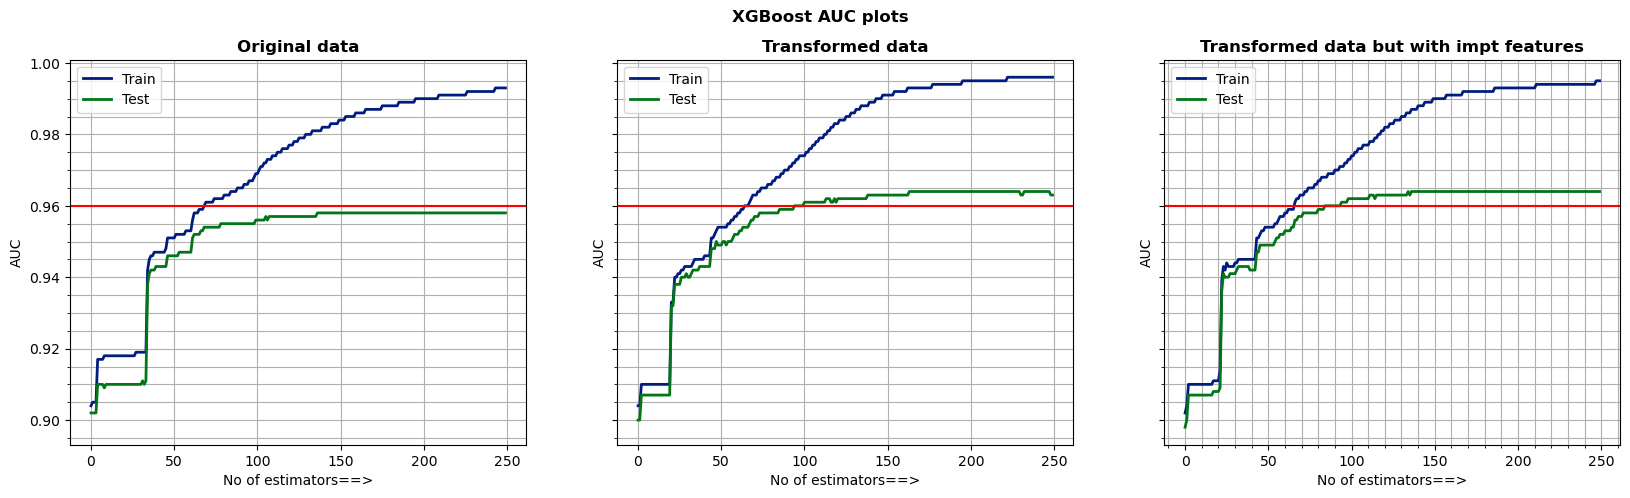

In [75]:
# 12.0 Learning curves of all the three models

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,3, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(),model_trans_impt.evals_result() ]
title = ["Original data", 'Transformed data', 'Transformed data but with impt features']
fig.suptitle("XGBoost AUC plots", fontweight = "bold")
for i in range(3):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators==>")
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y = 0.96, color = 'r', linestyle = '-')

plt.show();



## Part-I: Preparing for PCA: imputing data  

In [33]:
# 12.1 ReCheck
X_train_trans.shape  #(3750000, 193)
X_test_trans.shape   # (1250000, 193)
X_train_trans.isnull().sum().sum()  # 10032
X_test_trans.isnull().sum().sum()  # 3686

(3750000, 193)

(1250000, 193)

10032

3686

In [34]:
# 12.2 Impute as transformed data has null values:

start = time.time()
print("Imputing....")
si = SimpleImputer(strategy = 'median')
X_train_trans[:] = si.fit_transform(X_train_trans)
X_test_trans[:] = si.transform(X_test_trans)
end = time.time()
print("Done: ", (end-start)/60)  #  3.78m
_ = gc.collect()

Imputing....
Done:  3.8879833539326984


In [36]:
# 12.2.2 Save imputed data for later experiments.
#        We save it with a difft name:

X_train_trans.to_pickle(Path(dataPath) / "X_train_trans_imputed.pkl")
X_test_trans.to_pickle(Path(dataPath) / "X_test_trans_imputed.pkl")

# 12.2.3 Datashapes of imputed data:
X_train_trans.shape  # (3750000, 193)
X_test_trans.shape   # (1250000, 193)

(3750000, 193)

(1250000, 193)

In [37]:
# 12.2.4 Standardize features:
start = time.time()
ss =StandardScaler()
X_train_trans[:] = ss.fit_transform(X_train_trans)
X_test_trans[:]= ss.transform(X_test_trans)
end = time.time()
print("Done: ", (end-start)/60)  #  4.3m
_ = gc.collect()

Done:  0.20657681226730346


### PCA now

In [38]:
# 12.3 PCA with transformed train data.
#      Note that n_components = 0.95

pca = PCA(n_components= 0.95,
          whiten= True, 
          random_state = rng
         )

ss = StandardScaler()
pca_train = pca.fit_transform(ss.fit_transform(X_train_trans))
pca_test = pca.transform(ss.transform(X_test_trans))

# 14.4.1 Check data shapes:
pca_train.shape  # (3750000, 35)
pca_test.shape   # (1250000, 35)

(3750000, 35)

(1250000, 35)

In [39]:
# 14.5 Assign column names and transform to DataFrame:

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test = pd.DataFrame(pca_test, columns = colnames)

# 14.6 Dataframe shapes:
pca_train.shape  #(3750000, 35)
pca_test.shape   # 1250000, 35)

(3750000, 35)

(1250000, 35)

### PCA plots of pc0 and pc1

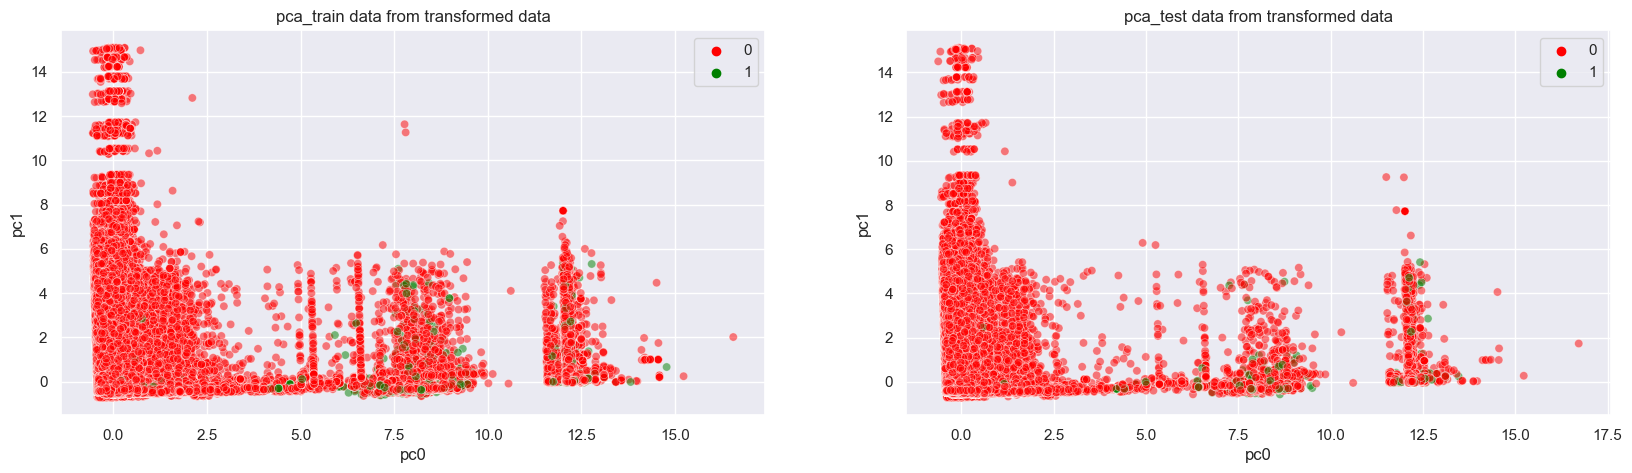

In [100]:
# 14.7 2D PCA plot from first two principal components:

fig = plt.figure(figsize = (20,5));
fig.add_subplot(1,2,1);
sns.set_theme() ; # Set default theme
plt.style.use('seaborn-v0_8-dark-palette')

# 14.7.1 plot pca-train data
sns.scatterplot(data = pca_train,
                x=  'pc0',
                y = 'pc1',
                hue = y_train.values,
                palette = ["red", "green"], alpha = 0.5
                ).set(title='pca_train data from transformed data') ;

# Plot pca_test data
fig.add_subplot(1,2,2);
sns.scatterplot(data = pca_test,
                x=  'pc0',
                y = 'pc1',
                hue = y_test.values,
                palette = ["red", "green"], alpha = 0.5
                ).set(title='pca_test data from transformed data') ;

## Examining pca plot
Density of fraudulent points to the right of 4.0 (pc0 >4.0) is around 76 times more than that on the left of 4.0 (pc0 <= 4.0). The following calculations show this. 

In [42]:
# 15.0 Let us examine the above graph more closely:
#      Merge pca_train and y_train
pcatyt = pd.concat([pca_train, y_train.reset_index(drop = True)],  axis = 1)  # train
pcateyt = pd.concat([pca_test, y_test.reset_index(drop = True)],  axis = 1)   # test

# 15.0.1 Data-points when pc0 > 4.0
pcayt_rt= pcatyt.loc[pcatyt.pc0 > 4.0, :]      # train
pcayte_rt= pcateyt.loc[pcateyt.pc0 > 4.0, :]   # test

nf_rt = pcayt_rt['isattributed'].sum() # 3116
nnf_rt = pcayt_rt.shape[0]             # 27791

# 15.0.2 Ratio of fradulent to non-fraudulent
print('Ratio of fraudulent to non-fraudulent to right of pc0 > 4:', nf_rt/(nnf_rt-nf_rt))  # 12.6%

# 15.0.3 Same calculations for the data on the left
#        Data-points when pc0 <= 4.0
pcayt_lt= pcatyt.loc[pcatyt.pc0 <= 4.0, :]
nf_lt = pcayt_lt['isattributed'].sum() # 3116
nnf_lt = pcayt_lt.shape[0]  # 27791

# 15.0.4 Ratio of fradulent to non-fraudulent points:
print('Ratio of fraudulent to non-fraudulent to right of pc0 > 4:', nf_lt/(nnf_lt-nf_lt))  # 0.16%

Ratio of fraudulent to non-fraudulent to right of pc0 > 4: 0.12628166160081053
Ratio of fraudulent to non-fraudulent to right of pc0 > 4: 0.0016471622846391152


### Patterns in +ve and -ve events
Plots of +ve and -ve events below show that while -ve events do not have any specific pattern, +ve events do have specific patterns and are confined to certain narrow ranges.

#### Consider pac_train first

In [112]:
# 15.0.5 Patterns in +ve and -ve samples
# Positive samples
pca_onlypos = pcatyt.loc[pcatyt.isattributed == 1, :]

# 15.0.6 Negative samples
pca_onlyneg = pcatyt.loc[pcatyt.isattributed == 0, :]

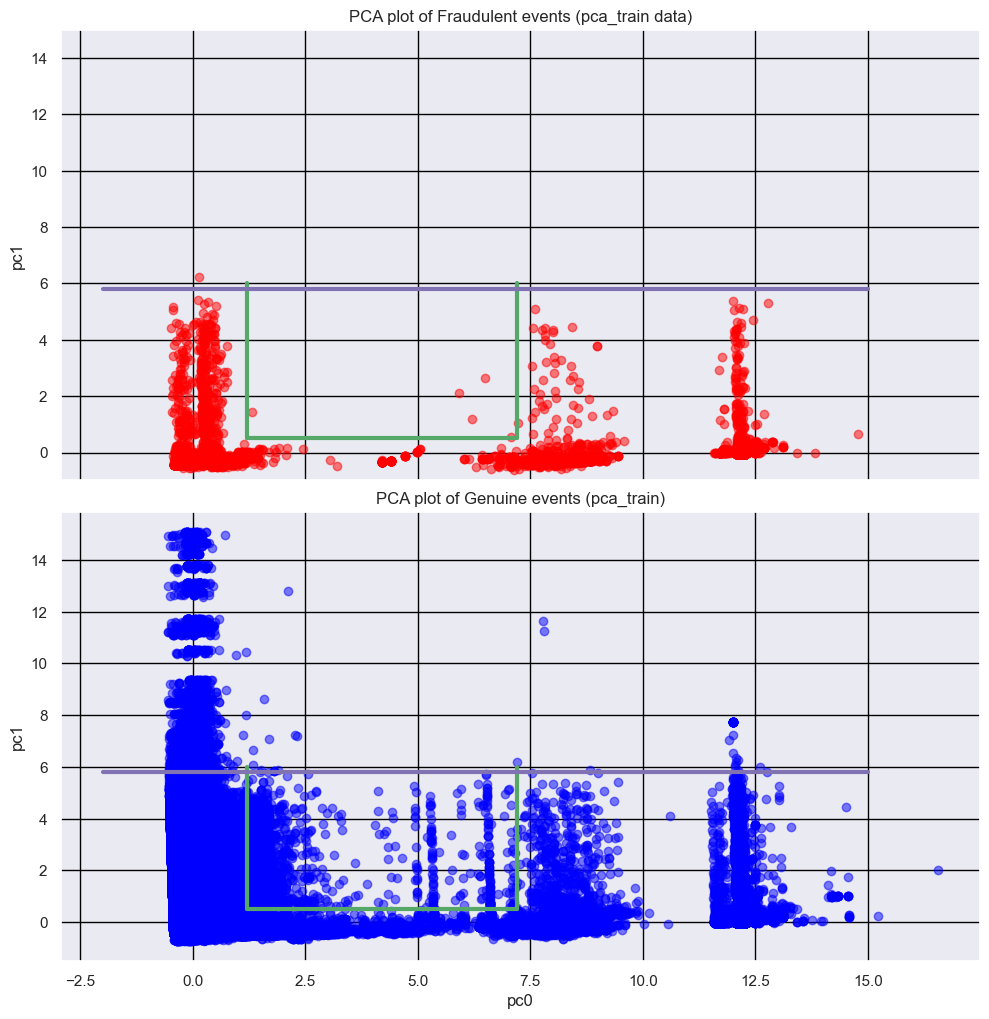

In [113]:
# 15.1 Separate scatter plots of positive and negatives: 

fig, axs = plt.subplots(nrows=2, sharex=True, figsize = (10,10));
plt.rc('grid', linestyle="-", color='black')
plt.tight_layout();

data = pca_onlypos.iloc[:,:-1]
data1 = pca_onlyneg.iloc[:,:-1]

_=axs[0].scatter(data.pc0, data.pc1, c="red", alpha=0.5);
axs[0].grid(True)
_=axs[0].set_title("PCA plot of Fraudulent events (pca_train data)");
_=axs[0].set_ylabel('pc1');

_=axs[1].scatter(data1.pc0, data1.pc1, c="blue", alpha=0.5);
_=axs[1].set_title("PCA plot of Genuine events (pca_train)");
_=axs[1].set_xlabel('pc0');
_=axs[1].set_ylabel('pc1');
_=axs[0].set_ylim(top = 15)


# Bounds of fraudulent events
# https://stackoverflow.com/a/16930526/3282777
_=axs[0].plot((1.2, 7.2), (0.5, 0.5), 'g-', linewidth = 3)
_=axs[0].plot((1.2, 1.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[0].plot((7.2, 7.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[0].plot((-2.0, 15), (5.8, 5.8), 'm-', linewidth = 3)

_=axs[1].plot((1.2, 7.2), (0.5, 0.5), 'g-', linewidth = 3)
_=axs[1].plot((1.2, 1.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[1].plot((7.2, 7.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[1].plot((-2.0, 15), (5.8, 5.8), 'm-', linewidth = 3)

axs[1].grid(True)


plt.show()

Within green boundary, there are plenty of genuine clicks but very few fraud clicks. Also above magenta line very few fraud events exist.

#### Consider pac_test now

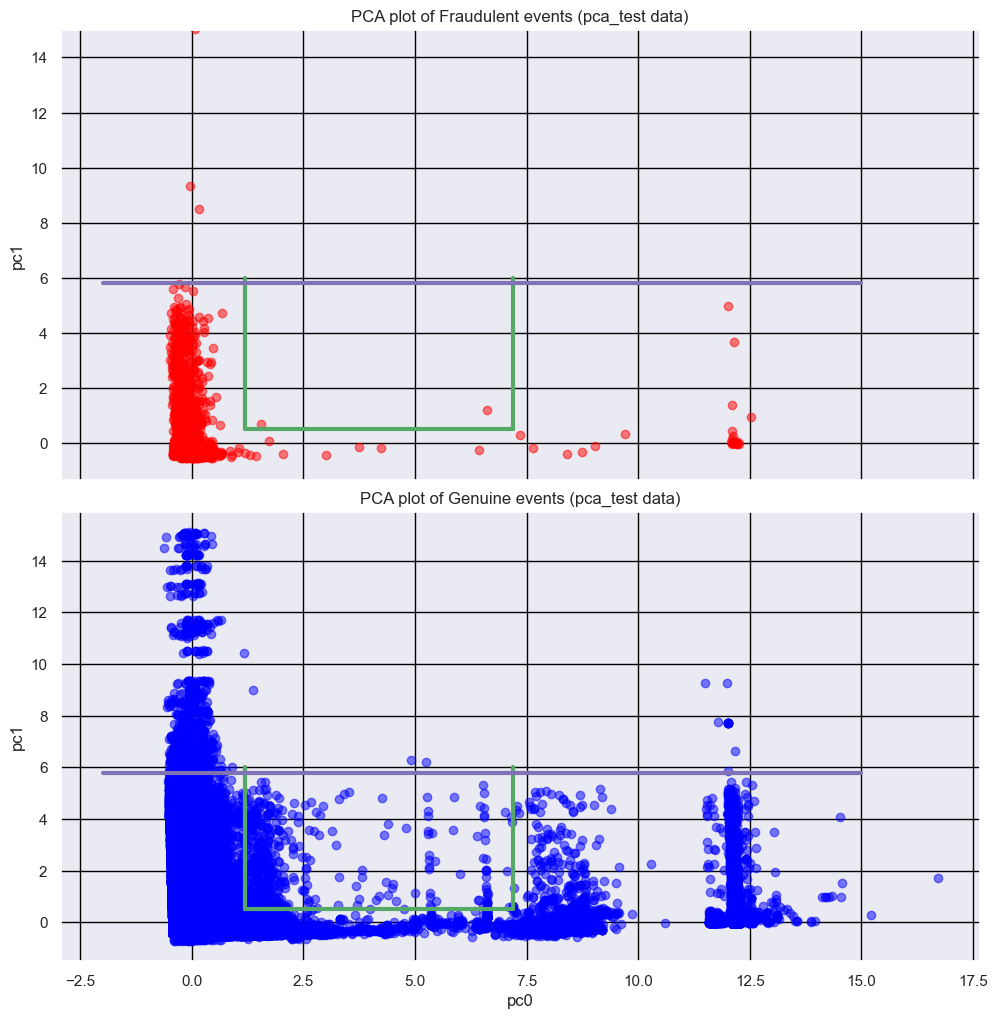

In [114]:
# 15.2.0 Patterns in +ve and -ve samples
# Positive samples
pca_onlypos = pcateyt.loc[pcatyt.isattributed == 1, :]
# 15.2.1 Negative samples
pca_onlyneg = pcateyt.loc[pcatyt.isattributed == 0, :]

# 15.2.2 Separate scatter plots of positive and negatives: 

fig, axs = plt.subplots(nrows=2, sharex=True, figsize = (10,10));
plt.rc('grid', linestyle="-", color='black')
plt.tight_layout();

data = pca_onlypos.iloc[:,:-1]
data1 = pca_onlyneg.iloc[:,:-1]

_=axs[0].scatter(data.pc0, data.pc1, c="red", alpha=0.5);
axs[0].grid(True)
_=axs[0].set_title("PCA plot of Fraudulent events (pca_test data)");
_=axs[0].set_ylabel('pc1');

_=axs[1].scatter(data1.pc0, data1.pc1, c="blue", alpha=0.5);
_=axs[1].set_title("PCA plot of Genuine events (pca_test data)");
_=axs[1].set_xlabel('pc0');
_=axs[1].set_ylabel('pc1');
_=axs[0].set_ylim(top = 15)


# 15.2.3 Bounds of fraudulent events
# https://stackoverflow.com/a/16930526/3282777
_=axs[0].plot((1.2, 7.2), (0.5, 0.5), 'g-', linewidth = 3)
_=axs[0].plot((1.2, 1.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[0].plot((7.2, 7.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[0].plot((-2.0, 15), (5.8, 5.8), 'm-', linewidth = 3)

_=axs[1].plot((1.2, 7.2), (0.5, 0.5), 'g-', linewidth = 3)
_=axs[1].plot((1.2, 1.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[1].plot((7.2, 7.2), (0.5, 6), 'g-', linewidth = 3)
_=axs[1].plot((-2.0, 15), (5.8, 5.8), 'm-', linewidth = 3)

axs[1].grid(True)

plt.show()

Pattern for test data is almost the same as that for train data

### Save and Read pca data

In [45]:
# 16.0 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(dataPath / "pca_train_orig.pkl")
pca_test.to_pickle(dataPath / "pca_test_orig.pkl")

In [46]:
# 16.1 Read back saved data:

pca_train = pd.read_pickle(dataPath / "pca_train_orig.pkl")
pca_test =  pd.read_pickle(dataPath / "pca_test_orig.pkl")

# 16.1.2 Check
pca_train.head(3)
pca_test.head(3)

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0 -0.309002 -0.435748 -1.222154  0.185089  0.381300  1.332462 -0.464524   
1 -0.373151 -0.439083 -0.786633 -0.332838  0.353148 -1.172365 -0.598329   
2  0.035795 -0.429764 -1.324109  0.538402 -0.174260  1.228434  0.785926   

        pc7       pc8       pc9  ...      pc25      pc26      pc27      pc28  \
0 -0.028237 -0.042860  0.049617  ... -0.147012 -0.355867  0.496737 -0.212613   
1 -1.238023  1.095038 -0.291938  ... -0.017720  0.207821 -1.278237 -1.758877   
2  0.943746 -0.072585  0.031388  ... -0.224874 -0.308080  0.548952 -0.612621   

       pc29      pc30      pc31      pc32      pc33      pc34  
0 -0.313389 -0.096366 -0.046028 -0.266329  0.310692  0.082680  
1  0.248114 -0.155191 -0.091604  0.038097  0.446404  0.320406  
2 -0.587208 -0.026574 -0.045625  1.078723  0.917457 -0.789572  

[3 rows x 35 columns]

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0  0.068847 -0.368775  1.752536 -0.982668  0.030169 -0.796604 -0.020178   
1 -0.170314 -0.339460  0.654929  0.088035  0.617947 -0.875958  0.322822   
2 -0.027515  1.599022 -0.943278  0.148920 -0.359794 -0.617744  0.875806   

        pc7       pc8       pc9  ...      pc25      pc26      pc27      pc28  \
0  0.378789 -1.187224  0.614146  ...  1.324895  0.532735 -1.013998  1.751529   
1 -0.622603  0.486048 -0.215952  ... -1.405694  0.496869  1.582667 -0.339329   
2  0.138229 -0.848426  0.807738  ... -0.100478  0.049831 -0.344360 -0.384543   

       pc29      pc30      pc31      pc32      pc33      pc34  
0  0.700015  0.078463  0.325726 -0.057751 -0.637899 -0.416649  
1 -0.375965 -1.046240 -1.718089 -0.656150  0.890205  0.292987  
2  0.803115  0.117886 -1.112466  0.411516 -0.340157 -0.046207  

[3 rows x 35 columns]

## PCA data for xgboost modeling
The results are as good as from original data with no transformation.

In [47]:
# 17.0 Prepare xgboost model--PCA data


model_pca_orig = xgb.XGBClassifier( n_estimators= 400,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               #class_weight = class_weights,   
                               random_state = rng,
                           )


tr_X =   pca_train 
test_X = pca_test  
ytrain = y_train     
ytest = y_test       


model_pca_orig.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[06:42:15] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[06:42:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90553	validation_1-auc:0.90024
[06:42:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 650 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90709	validation_1-auc:0.90167
[06:42:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 632 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.90714	validation_1-auc:0.90189
[06:42:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 700 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.90871	validati

[06:46:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 610 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.93893	validation_1-auc:0.93466
[06:46:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 694 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.93916	validation_1-auc:0.93514
[06:46:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 742 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.93921	validation_1-auc:0.93518
[06:47:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 646 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.93921	validation_1-auc:0.93514
[06:47:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.95340	validation_1-auc:0.94668
[06:51:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 626 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.95429	validation_1-auc:0.94690
[06:51:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.95482	validation_1-auc:0.94705
[06:51:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.95551	validation_1-auc:0.94753
[06:51:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.95594	validation_1-auc:0.94803
[06:51:42] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.98239	validation_1-auc:0.95539
[06:55:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 584 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.98265	validation_1-auc:0.95553
[06:56:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 618 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.98317	validation_1-auc:0.95580
[06:56:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 604 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.98352	validation_1-auc:0.95577
[06:56:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 598 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.98378	validation_1-auc:0.95589
[06:56:31] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.99273	validation_1-auc:0.95728
[07:00:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.99288	validation_1-auc:0.95738
[07:01:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.99300	validation_1-auc:0.95733
[07:01:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.99312	validation_1-auc:0.95735
[07:01:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.99323	validation_1-auc:0.95730
[07:01:24] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.99575	validation_1-auc:0.95774
[07:05:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.99581	validation_1-auc:0.95774
[07:05:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.99585	validation_1-auc:0.95777
[07:05:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.99590	validation_1-auc:0.95776
[07:06:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.99594	validation_1-auc:0.95767
[07:06:15] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.99718	validation_1-auc:0.95762
[07:10:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.99721	validation_1-auc:0.95763
[07:10:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.99724	validation_1-auc:0.95762
[07:10:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.99726	validation_1-auc:0.95762
[07:11:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.99729	validation_1-auc:0.95772
[07:11:08] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [48]:
# 17.0.1 Save model_pca_orig model:
gc.collect()
utils.savePythonObject(model_pca_orig, "model_pca_orig.pkl", estimatorsPath )

4125

Object saved to: D:\talkingdata\allmodels\estimators\model_pca_orig.pkl


In [49]:
# 17.0.2 Restore model_pca_orig  model:

model_pca_orig = utils.restorePythonObject("model_pca_orig.pkl", estimatorsPath )

In [50]:
# 17.1 Best Scores:

model_pca_orig.best_score     # 0.957855642047371
model_pca_orig.best_iteration # 179

0.957855642047371

179

In [51]:
# 17.2 Classification report of model with PCA data:

pred = model_pca_orig.predict(test_X)
cr_pca = classification_report(ytest, pred)
print(cr_pca)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.79      0.33      0.47      3079

    accuracy                           1.00   1250000
   macro avg       0.89      0.67      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



## Balancing the imbalanced PCA data
By using the PCA data and the balancing technique of `EditedNearestNeighbours` we are able to improve f1 score from 0.47 to 0.51. The AUC remains almost the same as that for the original data. `EditedNearestNeighbours` is a cleaning technique rather than a banancing technique. The method cleans the database by removing samples close to the decision boundary.

In [52]:
# 18.0 Call imblearn library:
#      We find EditedNearestNeighbours the best in this case

from imblearn.under_sampling import EditedNearestNeighbours,OneSidedSelection,AllKNN  
from imblearn.combine import SMOTEENN

In [53]:
# 18.1 Undersample pca_train data:
gc.collect()
start = time.time()
undersample = EditedNearestNeighbours()   
X_res, y_res = undersample.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 129min

# 18.1.1 Data shape
X_res.shape  #  (3734087, 35)
y_res.shape  #  (3734087,)

0

129.60041728814443


(3734087, 35)

(3734087,)

In [77]:
# 18.1.2 Save above files
X_res.to_pickle(dataPath / "X_res_orig.pkl")
y_res.to_pickle(dataPath / "y_res_orig.pkl")
gc.collect()

20616

In [78]:
# 18.1.3 Read back
X_res = pd.read_pickle(dataPath / "X_res_orig.pkl")
y_res = pd.read_pickle(dataPath / "y_res_orig.pkl")
y_res.value_counts(normalize = True) # 99.75 : 0.25
y_train.value_counts(normalize = True) # 99.75:0.25

0    0.997526
1    0.002474
Name: isattributed, dtype: float64

0    0.997537
1    0.002463
Name: isattributed, dtype: float64

In [79]:
# 19.1 xgboost Modeling with undersampled data
gc.collect()
model_res_orig = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 10,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_res_orig.fit(tr_X, ytrain.values,                  
          early_stopping_rounds = 100,   
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']    
          )



0

[09:44:56] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[09:45:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 590 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90787	validation_1-auc:0.90177
[09:45:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 528 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90804	validation_1-auc:0.90185
[09:45:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 532 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.90840	validation_1-auc:0.90207
[09:45:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.90862	validati

[09:49:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 658 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.93795	validation_1-auc:0.93319
[09:49:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 632 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.93997	validation_1-auc:0.93456
[09:49:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 672 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.94040	validation_1-auc:0.93494
[09:49:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 636 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.94052	validation_1-auc:0.93521
[09:49:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.95462	validation_1-auc:0.94698
[09:53:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 514 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.95544	validation_1-auc:0.94740
[09:54:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 614 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.95598	validation_1-auc:0.94749
[09:54:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 656 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.95715	validation_1-auc:0.94774
[09:54:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 658 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.95794	validation_1-auc:0.94814
[09:54:29] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.98321	validation_1-auc:0.95641
[09:58:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 678 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.98361	validation_1-auc:0.95631
[09:58:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 632 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.98399	validation_1-auc:0.95624
[09:59:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 592 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.98426	validation_1-auc:0.95630
[09:59:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.98447	validation_1-auc:0.95634
[09:59:18] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.99337	validation_1-auc:0.95750
[10:03:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.99350	validation_1-auc:0.95757
[10:03:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 634 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.99377	validation_1-auc:0.95762
[10:03:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 572 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.99403	validation_1-auc:0.95771
[10:04:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.99424	validation_1-auc:0.95773
[10:04:14] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.99684	validation_1-auc:0.95860
[10:08:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.99691	validation_1-auc:0.95867
[10:08:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.99698	validation_1-auc:0.95862
[10:08:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.99702	validation_1-auc:0.95860
[10:09:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.99704	validation_1-auc:0.95852
[10:09:09] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.99815	validation_1-auc:0.95804
[10:13:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.99817	validation_1-auc:0.95803
[10:13:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.99819	validation_1-auc:0.95817
[10:13:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.99822	validation_1-auc:0.95808
[10:13:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.99825	validation_1-auc:0.95803
[10:14:01] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [80]:
# 19.1.1 Save model:
gc.collect()
utils.savePythonObject(model_res_orig, "model_res_orig.pkl", estimatorsPath )

44

Object saved to: D:\talkingdata\allmodels\estimators\model_res_orig.pkl


In [81]:
# 19.1.2 Restore model:

model_res_orig = utils.restorePythonObject("model_res_orig.pkl", estimatorsPath )


In [82]:
# 19.2 Best Scores:

model_res_orig.best_score     # 0.9586662564858861
model_res_orig.best_iteration # 184

0.9586662564858861

184

In [83]:
# 19.3 Classification report of model with PCA data:

pred = model_res_orig.predict(test_X)
cr_pca = classification_report(ytest, pred)
print(cr_pca)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.50      0.52      0.51      3079

    accuracy                           1.00   1250000
   macro avg       0.75      0.76      0.75   1250000
weighted avg       1.00      1.00      1.00   1250000



## Part-II: Treating ip as numeric and then performing PCA:  
In the Kaggle problem it has not been explained as to how 'ip' has been transformed into numbers. Paradoxically, if we treat 'ip' as numeric, results are about the same as those after our transformation. We treat below,'ip' as numeric field.   
From the transofmed data (X_train_trans, X_test_trans), we first remove all those features that have been derived from 'ip' and then concatenate 'ip' column as one of the numeric features. Incidentaly, in one of the Kaggle solutions, link [here](https://www.kaggle.com/code/georsara1/95-auc-score-in-train-sample-with-neural-nets), 'ip' has been treated as numeric and results are quite good.

### Columns that have not been drived from IP

In [84]:
# 20.0 Which cols have 'ip' as a part of their names:

colsWithip = [i for i in X_train_trans.columns if 'ip' in i ]

# 20.0.1 And which ones do no?
colsWithoutip = [i for i in X_train_trans.columns if 'ip' not in i ]

# 20.0.2
len(colsWithoutip)  # 100
print("\n\n====")

# 20.0.3
X_train_trans[colsWithoutip].shape  # (3750000, 100)

100



====


(3750000, 100)

In [85]:
# 20.0.4 Here is a list of created columns. All of them have 'ip': 
print(colsWithip)

['deg_app_ck_channel_p_ip', 'deg_app_ck_device_p_ip', 'deg_app_ck_ip', 'deg_app_ck_os_p_ip', 'deg_channel_ck_app_p_ip', 'deg_channel_ck_device_p_ip', 'deg_channel_ck_ip', 'deg_channel_ck_os_p_ip', 'deg_device_ck_app_p_ip', 'deg_device_ck_channel_p_ip', 'deg_device_ck_ip', 'deg_device_ck_os_p_ip', 'deg_ip_ck_app', 'deg_ip_ck_app_p_channel', 'deg_ip_ck_app_p_device', 'deg_ip_ck_app_p_os', 'deg_ip_ck_channel', 'deg_ip_ck_device_p_channel', 'deg_ip_ck_device_p_os', 'deg_ip_ck_os', 'deg_ip_ck_os_p_channel', 'deg_os_ck_app_p_ip', 'deg_os_ck_channel_p_ip', 'deg_os_ck_device_p_ip', 'deg_os_ck_ip', 'eig_app_ck_app_p_ip', 'eig_app_ck_channel_p_ip', 'eig_app_ck_device_p_ip', 'eig_app_ck_ip', 'eig_app_ck_os_p_ip', 'eig_channel_ck_app_p_ip', 'eig_channel_ck_channel_p_ip', 'eig_channel_ck_device_p_ip', 'eig_channel_ck_ip', 'eig_channel_ck_os_p_ip', 'eig_device_ck_app_p_ip', 'eig_device_ck_channel_p_ip', 'eig_device_ck_device_p_ip', 'eig_device_ck_ip', 'eig_device_ck_os_p_ip', 'eig_ip_ck_app', 'eig_i

### Process the earlier fully transformed data:

In [115]:
# 21.0 Read imputed data 
#      NOTE AGAIN THIS DATA IS IMPUTED

X_train_trans = pd.read_pickle(Path(dataPath) / "X_train_trans_imputed.pkl")
X_test_trans = pd.read_pickle(Path(dataPath) / "X_test_trans_imputed.pkl")

# 21.1.1 Datashapes of imputed data:
X_train_trans.shape  # (3750000, 193)
X_test_trans.shape   # (1250000, 193)

(3750000, 193)

(1250000, 193)

In [116]:
# 21.1.2 Get transformed data but without 'colsWithoutip'  :

X_train_trans_withoutip = X_train_trans[colsWithoutip].copy() 
X_test_trans_withoutip = X_test_trans[colsWithoutip].copy() 

# 21.1.3 Check if it needs imputation?
#         No. Not needed.
X_train_trans_withoutip.isnull().sum().sum()  # 0
X_test_trans_withoutip.isnull().sum().sum()  # 0

0

0

In [80]:
#   No need to impute

start = time.time()
print("Imputing....")
si = SimpleImputer(strategy = 'median')
X_train_trans_withoutip[:] = si.fit_transform(X_train_trans_withoutip)
X_test_trans_withoutip[:] = si.transform(X_test_trans_withoutip)
end = time.time()
print("Done: ", (end-start)/60)  #  1.7992372711499531
_ = gc.collect()

Imputing....
Done:  1.7849230448404947


In [117]:
# 21.1.4 Save imputed data for later experiments:

X_train_trans_withoutip.to_pickle(Path(dataPath) / "X_train_trans_without.pkl")
X_test_trans_withoutip.to_pickle(Path(dataPath) / "X_test_trans_without.pkl")

# 21.1.5 Datashapes of imputed data:
X_train_trans_withoutip.shape  # (3750000, 100)
X_test_trans_withoutip.shape   # (1250000, 100)

(3750000, 100)

(1250000, 100)

In [118]:
# 21.1.5 Read back saved data:

X_train_trans_withoutip = pd.read_pickle(Path(dataPath) / "X_train_trans_without.pkl")
X_test_trans_withoutip = pd.read_pickle(Path(dataPath) / "X_test_trans_without.pkl")

# 21.1.6 Check
X_train_trans_withoutip.shape  # (3750000, 100)
X_test_trans_withoutip.shape   # (1250000, 100)

(3750000, 100)

(1250000, 100)

In [119]:
# 21.1.7 Concatenate 'ip' col. We treat it as numeric:

X_train_trans_withip = pd.concat( [X_train['ip'], X_train_trans_withoutip], axis = 1)
X_test_trans_withip =  pd.concat( [X_test['ip'],  X_test_trans_withoutip], axis = 1)

# 21.1.8
X_train_trans_withip.shape # (3750000, 101)
X_test_trans_withip.shape   # (1250000, 101)                                     

(3750000, 101)

(1250000, 101)

### PCA of processed data (treating ip as numeric):

In [120]:
# 22.0 PCA with transformed train data.
#      Note that n_components = 0.95
#      ip is included as a numeric feature

pca = PCA(n_components= 0.95,
          whiten= True, 
          random_state = rng
         )

# 22.1
ss = StandardScaler()
pca_train_ipn = pca.fit_transform(ss.fit_transform(X_train_trans_withip))
pca_test_ipn = pca.transform(ss.transform(X_test_trans_withip))

# 22.2 Check data shapes:
pca_train_ipn.shape  # (3750000, 24)
pca_test_ipn.shape   # (1250000, 24)

(3750000, 24)

(1250000, 24)

In [122]:
# 22.3 Assign column names and transform to DataFrame:

colnames = ["pc" + str(i) for i in range(pca_train_ipn.shape[1])]
pca_train_ipn = pd.DataFrame(pca_train_ipn, columns = colnames)
pca_test_ipn = pd.DataFrame(pca_test_ipn, columns = colnames)

# 22.3.1 Dataframe shapes:
pca_train_ipn.shape  #(3750000, 24)
pca_test_ipn.shape   # 1250000, 24)

(3750000, 24)

(1250000, 24)

### PCA plot (ip is numeric)

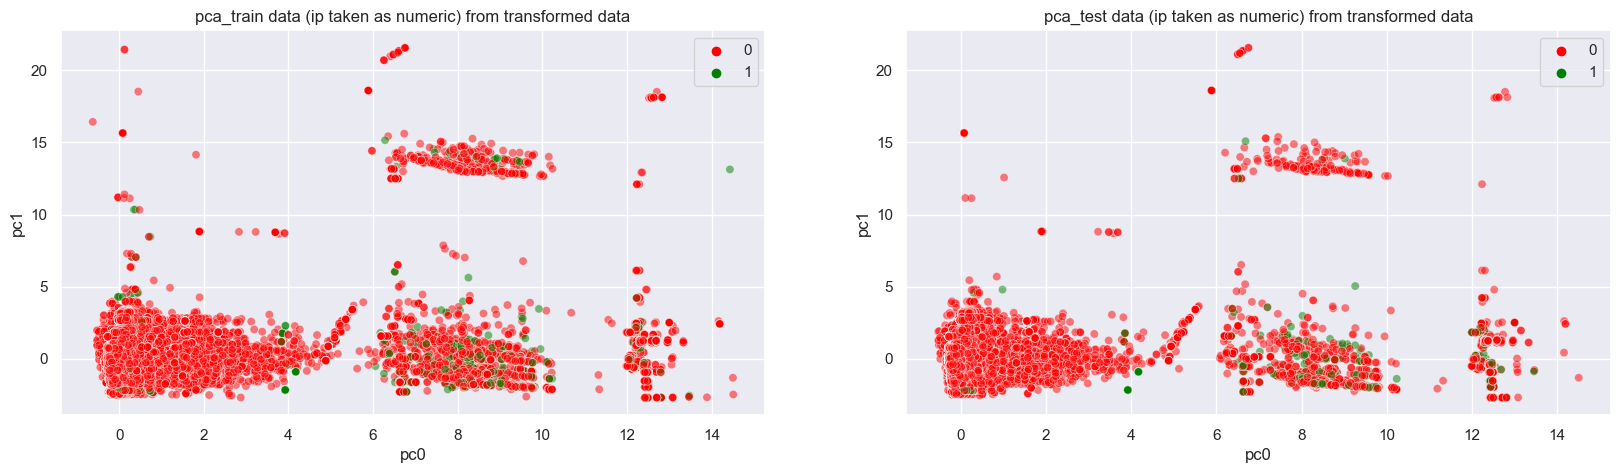

In [124]:
# 23.0 2D PCA plot from first two principal components:

fig = plt.figure(figsize = (20,5));
fig.add_subplot(1,2,1);
sns.set_theme() ; # Set default theme
plt.style.use('seaborn-v0_8-dark-palette')

# 23.1 plot pca_train_ipn data
sns.scatterplot(data = pca_train_ipn,
                x=  'pc0',
                y = 'pc1',
                hue = y_train.values,
                palette = ["red", "green"], alpha = 0.5
                ).set(title='pca_train data (ip taken as numeric) from transformed data') ;

# 23.2 Plot pca_test_ipn data
fig.add_subplot(1,2,2);
sns.scatterplot(data = pca_test_ipn,
                x=  'pc0',
                y = 'pc1',
                hue = y_test.values,
                palette = ["red", "green"], alpha = 0.5
                ).set(title='pca_test data (ip taken as numeric) from transformed data') ;

### Save/read back pca data

In [131]:
# 23.3 Save pca_train and pca_test for later experiments:

pca_train_ipn.to_pickle(dataPath / "pca_train_ipn.pkl")
pca_test_ipn.to_pickle(dataPath / "pca_test_ipn.pkl")

In [132]:
# 23.3.1 Read back saved data:

pca_train_ipn = pd.read_pickle(dataPath / "pca_train_ipn.pkl")
pca_test_ipn =  pd.read_pickle(dataPath / "pca_test_ipn.pkl")

# 23.3.2 Check
pca_train_ipn.head(3)
pca_test_ipn.head(3)

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0 -0.223922 -1.379822  0.382127  0.791965  0.548825  0.199610 -0.009590   
1 -0.198570 -0.430250 -0.470133 -0.764100 -0.378928 -1.162296  0.110161   
2 -0.011426 -1.697922  0.467450  0.814932  0.416996  0.421737  0.035310   

        pc7       pc8       pc9  ...      pc14      pc15      pc16      pc17  \
0 -0.037699  0.002169 -0.010211  ... -0.592301 -0.586669 -0.449301 -0.110821   
1  0.029624 -0.035693 -0.018720  ... -1.427098 -0.154280  0.228891 -1.975254   
2  0.026993  0.009311 -0.019592  ... -1.197393 -0.101330  0.831209 -0.341463   

       pc18      pc19      pc20      pc21      pc22      pc23  
0  0.497435  0.848403  0.667098 -0.136790  0.209033  0.129885  
1  1.241543  0.944634  0.632285 -0.984931  0.509264  0.782920  
2 -3.055674 -2.567456 -0.716710  0.963373  2.125001 -1.231935  

[3 rows x 24 columns]

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0  0.058384  1.983286 -0.532549 -0.687084  0.240982  1.599215 -0.039364   
1 -0.177439  0.790094  0.243035 -0.823749  0.107655 -1.429336 -0.009371   
2 -0.062635 -0.796039 -0.033629 -0.249453  0.114836  0.088008 -0.018783   

        pc7       pc8       pc9  ...      pc14      pc15      pc16      pc17  \
0  0.084261  0.006913  0.038950  ... -1.490448  0.964855  0.391543  1.537007   
1 -0.060074 -0.017019 -0.047740  ...  1.005534 -0.446300 -0.703994 -0.334027   
2  0.036391 -0.014965  0.005584  ...  1.141895  0.505019 -0.043749 -0.368564   

       pc18      pc19      pc20      pc21      pc22      pc23  
0  1.731679  1.032598  0.658613 -0.138475 -0.851871  0.467689  
1 -0.020477  0.488867 -1.692367  0.928728  1.207795  0.548144  
2  1.307971  0.284147  0.571545 -0.925020 -0.214862  0.779472  

[3 rows x 24 columns]

### XGboost modeling of PCA data (ip is numeric)
Here are earlier best AUC scores: <br>
> Modeling with original features: <b>0.9583435202423347<br></b>
> Modeling with numerically transformed features + time features:  <b>0.9639394784189219</b><br>
>Modeling with numerically transformed features + time features but take top 150 impt features: <font color = 'red'><b> 0.9641005353487067</b></font><br>
> Modeling with PCA of above transformed features: <b>0.9584513983092585</b><br>
> Modeling with PCA of transformed features but IP is treated as numeric: <b>0.9568540980712056</b><br>

In [133]:
# 24.0 Prepare xgboost model--PCA data, ip is numeric:

model_pca_ipn = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               #class_weight = class_weights,   
                               random_state = rng,
                           )


tr_X =   pca_train_ipn  # ptr
test_X = pca_test_ipn   # pte
ytrain = y_train     
ytest = y_test       


model_pca_ipn.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[18:03:20] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:03:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.86017	validation_1-auc:0.85453
[18:03:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 606 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.87127	validation_1-auc:0.86667
[18:03:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 608 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.87170	validation_1-auc:0.86707
[18:03:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 618 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.88200	validati

[18:06:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 644 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.90463	validation_1-auc:0.90166
[18:06:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.90466	validation_1-auc:0.90169
[18:06:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 606 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.91549	validation_1-auc:0.91024
[18:07:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 612 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.91550	validation_1-auc:0.91029
[18:07:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.95387	validation_1-auc:0.94362
[18:10:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.95407	validation_1-auc:0.94364
[18:10:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.95440	validation_1-auc:0.94405
[18:10:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 620 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.95486	validation_1-auc:0.94466
[18:10:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.95553	validation_1-auc:0.94482
[18:10:39] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.97324	validation_1-auc:0.95321
[18:13:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 806 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.97373	validation_1-auc:0.95348
[18:14:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 650 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.97417	validation_1-auc:0.95361
[18:14:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 620 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.97476	validation_1-auc:0.95365
[18:14:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 608 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.97519	validation_1-auc:0.95380
[18:14:21] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.98690	validation_1-auc:0.95674
[18:17:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.98710	validation_1-auc:0.95690
[18:17:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.98755	validation_1-auc:0.95686
[18:17:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.98774	validation_1-auc:0.95693
[18:18:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.98792	validation_1-auc:0.95694
[18:18:09] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.99222	validation_1-auc:0.95661
[18:21:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.99235	validation_1-auc:0.95668
[18:21:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 774 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.99250	validation_1-auc:0.95661
[18:21:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.99262	validation_1-auc:0.95665
[18:21:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.99265	validation_1-auc:0.95668
[18:22:04] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [134]:
# 24.0.1 Save model:
gc.collect()
utils.savePythonObject(model_pca_ipn, "model_pca_ipn.pkl", estimatorsPath )

11025

Object saved to: D:\talkingdata\allmodels\estimators\model_pca_ipn.pkl


In [135]:
# 24.0.2 Restore model:

model_pca_ipn = utils.restorePythonObject("model_pca_ipn.pkl", estimatorsPath )

In [136]:
# 24.0.3 Best Scores:

model_pca_ipn.best_score     # 0.957044921859579
model_pca_ipn.best_iteration # 167

0.9570449218595791

167

In [137]:
# 24.0.4 Classification report of model with PCA data:

pred = model_pca_ipn.predict(test_X)
cr_pca = classification_report(ytest, pred)
print(cr_pca)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.76      0.33      0.46      3079

    accuracy                           1.00   1250000
   macro avg       0.88      0.67      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



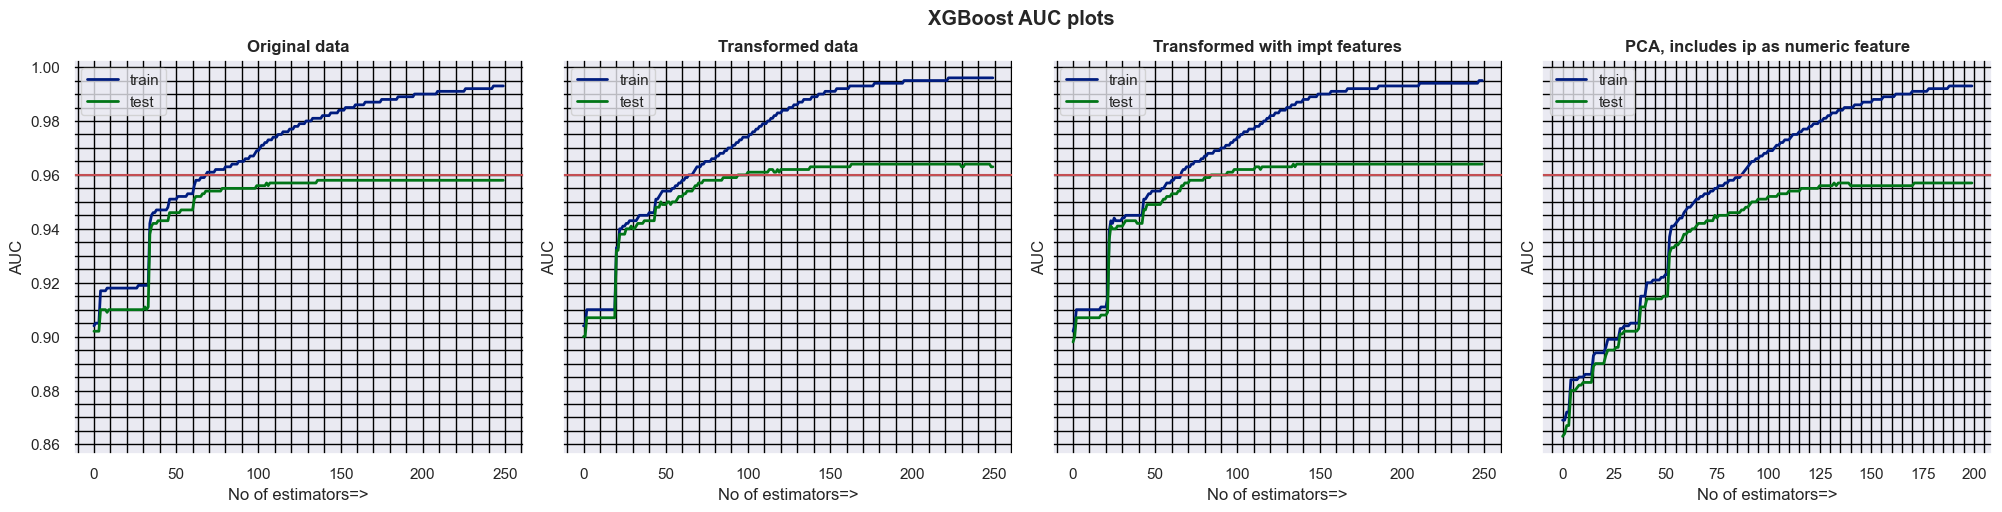

In [183]:
# 25.0
plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(), model_trans_impt.evals_result(), model_pca_ipn.evals_result() ]
title = ["Original data", 'Transformed data','Transformed with impt features', 'PCA, includes ip as numeric feature']
fig.suptitle("XGBoost AUC plots", fontweight = "bold")
plt.tight_layout()
for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y = 0.96, color = 'r', linestyle = '-')

plt.show();

## Balancing unbalanced PCA data (ip is numeric)
We get significantly imrpoved F1 scores when we use two techniques: `EditedNearestNeighbours` and `AllKNN`. Results with `AllKNN` are a shade better than those with `EditedNearestNeighbours`. However, `AllKNN` takes a lot of time.

In [138]:
# 26.0 Call imblearn library:

from imblearn.under_sampling import EditedNearestNeighbours,OneSidedSelection,AllKNN   
from imblearn.combine import SMOTEENN

In [139]:
# 26.1 Undersample PCA train data using EditedNearestNeighbours:

gc.collect()
start = time.time()
undersample = EditedNearestNeighbours()   
X_resenn, y_resenn = undersample.fit_resample(pca_train_ipn, y_train)
end = time.time()
print((end-start)/60)  # 114 min

# 26.1.1 Data shape
X_resenn.shape  #  (3735683, 24)
y_resenn.shape  # (3735683,)

16

115.15303964217505


(3735683, 24)

(3735683,)

In [140]:
# 26.1.2 Save above files
X_resenn.to_pickle(dataPath / "X_resenn.pkl")
y_resenn.to_pickle(dataPath / "y_resenn.pkl")
gc.collect()

0

In [141]:
# 26.1.3 Read back
X_resenn = pd.read_pickle(dataPath / "X_resenn.pkl")
y_resenn = pd.read_pickle(dataPath / "y_resenn.pkl")
y_resenn.value_counts(normalize = True) # 99.75 : 0.25
y_train.value_counts(normalize = True) # 99.75:0.25

0    0.997527
1    0.002473
Name: isattributed, dtype: float64

0    0.997537
1    0.002463
Name: isattributed, dtype: float64

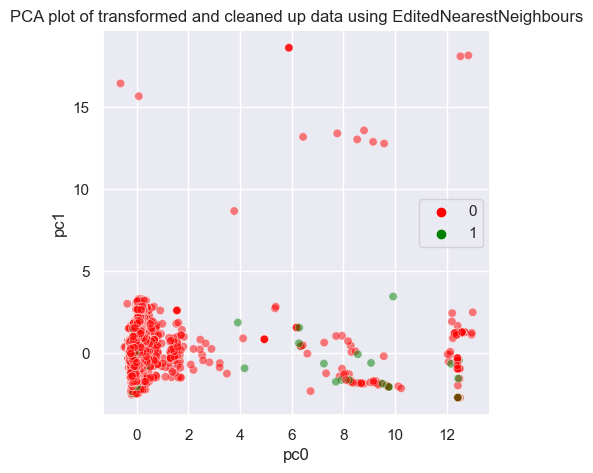

In [148]:
# 26.1.4 2D PCA plot from first two principal components
#      of undersampled data:
#      First take a stratified sample for plotting
#      And then plot:
_=gc.collect()
_, pca_tr, _,pca_y  = train_test_split(X_resenn, 
                                       y_resenn,
                                       test_size = 50000,
                                       stratify = y_resenn
                                      )

# 26.1.5
pca_tr.shape  # (50000, 31)
pca_y.shape   # (50000,)

# 26.1.5

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; 
sns.scatterplot(data = pca_tr,  # Sample of 50000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"],alpha = 0.5
                ).set(title='PCA plot of transformed and cleaned up data using EditedNearestNeighbours') ;

In [143]:
# 26.2 xgboost Modeling with undersampled data
_=gc.collect()
model_en = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 10,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_resenn 
test_X = pca_test_ipn
ytrain = y_resenn 
ytest =  y_test


model_en.fit(tr_X, ytrain.values,                  
          early_stopping_rounds = 100,   
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']    
          )



[20:25:30] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[20:25:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 646 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.85797	validation_1-auc:0.85303
[20:25:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.86114	validation_1-auc:0.85482
[20:25:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 572 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.86142	validation_1-auc:0.85497
[20:25:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 606 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.86147	validati

[20:28:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 760 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.90526	validation_1-auc:0.90174
[20:28:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 614 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.90529	validation_1-auc:0.90176
[20:29:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.90529	validation_1-auc:0.90176
[20:29:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 642 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.90530	validation_1-auc:0.90177
[20:29:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.95379	validation_1-auc:0.94290
[20:32:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.95416	validation_1-auc:0.94313
[20:32:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 628 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.95508	validation_1-auc:0.94374
[20:32:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.95585	validation_1-auc:0.94432
[20:32:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.95637	validation_1-auc:0.94501
[20:32:47] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.97366	validation_1-auc:0.95407
[20:36:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 760 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.97403	validation_1-auc:0.95416
[20:36:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 688 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.97430	validation_1-auc:0.95415
[20:36:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 656 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.97490	validation_1-auc:0.95426
[20:36:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 706 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.97557	validation_1-auc:0.95441
[20:36:28] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.98864	validation_1-auc:0.95716
[20:39:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.98886	validation_1-auc:0.95714
[20:40:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.98909	validation_1-auc:0.95710
[20:40:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.98917	validation_1-auc:0.95703
[20:40:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.98934	validation_1-auc:0.95709
[20:40:19] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.99364	validation_1-auc:0.95704
[20:43:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.99378	validation_1-auc:0.95697
[20:43:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 542 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.99397	validation_1-auc:0.95692
[20:43:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.99405	validation_1-auc:0.95688
[20:44:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.99409	validation_1-auc:0.95686
[20:44:08] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.99626	validation_1-auc:0.95754
[20:47:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 620 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.99637	validation_1-auc:0.95756
[20:47:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.99641	validation_1-auc:0.95756
[20:47:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.99649	validation_1-auc:0.95759
[20:47:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.99654	validation_1-auc:0.95757
[20:47:57] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [144]:
# 26.3 Save model:

utils.savePythonObject(model_en, "model_en.pkl", estimatorsPath )

Object saved to: D:\talkingdata\allmodels\estimators\model_en.pkl


In [145]:
# 26.4 Restore model:

model_en = utils.restorePythonObject("model_en.pkl", estimatorsPath )

In [146]:
# 26.5 Best Scores:

model_en.best_score     # 0.9576643874479048
model_en.best_iteration # 169

0.9576643874479048

169

In [147]:
# 26.6 Classification report of model with PCA data:

pred = model_en.predict( pca_test_ipn)
cr_en = classification_report(y_test, pred)
print(cr_en)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.54      0.51      0.53      3079

    accuracy                           1.00   1250000
   macro avg       0.77      0.75      0.76   1250000
weighted avg       1.00      1.00      1.00   1250000



## Distribution of transformed features:

pagerank             0.370370
eigenvector          0.370370
degree               0.259259
clusteringcoeff      0.000000
betweenness          0.000000
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

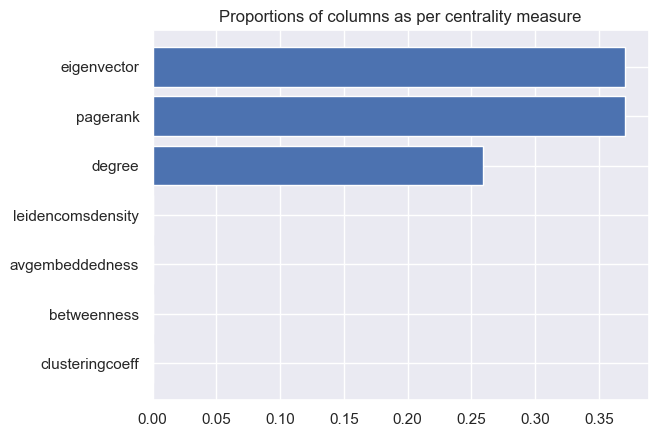

In [149]:
# 27.0 Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

# 27.0.1 Our list of columns

colList = X_train_trans.columns

# 27.0.2 Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")


### Proportions of columns by centrality whose impt is > 0

In [152]:
# 27.1 Extract column importance while building model_trans:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"

Order of feature importance is by 'gain'


'Columns whose impt is >0: 174'

'Columns whose impt is 0: 19'

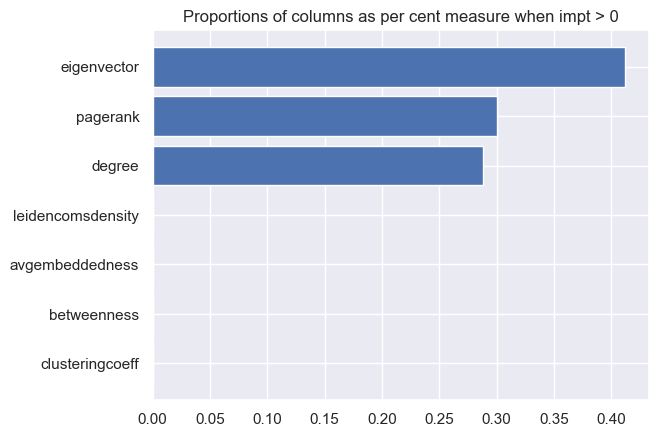

In [153]:
# 27.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:

f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")



### Proportions of columns by summed-up importance score of each centrality measure

Order of feature importance is by 'gain'


deg_app_ck_os_p_ip         0.357950
deg_app_ck_device_p_ip     0.063560
pr_channel_ck_app          0.044027
deg_channel_ck_app_p_os    0.025462
deg_os_ck_channel          0.023105
Name: imp, dtype: float32

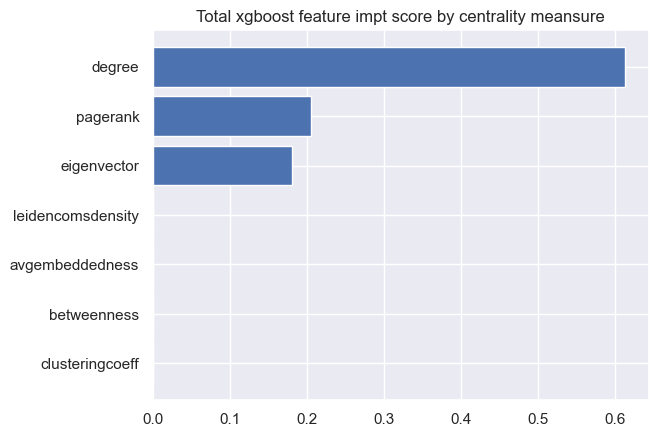

In [154]:
# 27.3 Extract xgboost feature importance:

fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)

# 27.3.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 27.3.2 Score of top-five columns:
score[:5]

# 27.3.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Derive unit-vectors per level per cat column

What is a unit vector?

>We started with a dataframe with five categorical features. These categorical features were transformed into dense vectors. We now intend to extract/separate out dense vectors for each one of these five cat features. What columns constitute dense vectors for each cat?   For a column, say app, dense vectors have column-names such as: 'deg_app_ck_channel', 'deg_app_ck_device', 'deg_app_ck_ip', 'deg_app_ck_os'...'pr_app_ck_device', 'pr_app_ck_ip', 'pr_app_ck_os' ..... But not 'pr_app_p_os_ck_ip',  'deg_app_p_channel_ck_os'..  as here we have concatenated columns (for example 'deg_app_p_channel_ck_os' is transformation from concatenated 'app' + 'channel' column. Thus, dense vectord for `'app'` (in our small example limited to few columns) are:<br>

> `df[['deg_app_ck_channel', 'deg_app_ck_device', 'deg_app_ck_ip', 'deg_app_ck_os','pr_app_ck_device','pr_app_ck_ip','pr_app_ck_os' ]]`<br>
  
>where df is the complete transformed dataframe.
            
>Dense vectors are extracted for every cat-col, and for every level in the column. If a level occurs multiple times (as it normally would) then there are multiple corresponding rows of vectors. Given a cat col, we first collect in a DataFrame all related columns, as for example below for 'app' column. Note here that here level '213' occurs twice.

 
                   Example:
                       
                      app   deg_..   pr_...   eig_...
                      213   0.10     0.20     0.11
                      214   0.45     0.18     0.22
                      ...   ...      ...      ...
                      ...   ...      ...      ...
                      213   0.101    0.20     0.10
                      ...   ...      ...      ...
                     
                  If take_mean is True, a final vector for each level
                  of 'app' (213) would be calculated by taking mean of 
                  corresponding rows.
>Once the dataframe is extracted, we apply normalization (l2norm) for row-wise normalization. 

>The method, `vectorsToTSV` , returns a dictionary with keys as column names in cat_cols. For every key, in the dict (say, `'app'`)', value is a dataframe ( `l2` normalized along rows). The dataframe's first column is the cat-col itself (same as the dict key, say, 'app'). <br>   
>A level may have only one row of unit vector (if `take_mean` parameter is `True`) or multiple row vectors at difft row-positions.

### Quick recap

In [5]:
# 28.0 Our folder paths where data/model files are saved:

talkingdata = Path("D:\\talkingdata\\allmodels")
graphsPath = talkingdata / "graphs"     # For graph files
dataPath = talkingdata / "datafiles"    # For data files
modelsPath = talkingdata /"models"  # For saved models
estimatorsPath = talkingdata / "estimators"  # For fitted estimators
unitvecsPath = talkingdata  / "unitvec"      # For unitvectors
mapdictpath = talkingdata / "mapdictpath"
skippedRowsPath = talkingdata / "skippedrowspath"

In [5]:
# 28.1 A quick readback all saved files:

#  Our cat cols
cat_cols = ['app', 'device', 'os', 'channel', 'ip']   # 5

#  28.2 Remaining cols not treated as cat cols:
rem_cols = {'minute', 'day', 'hour', 'second'} # 4 cols

# 28.3 Data 
X_train_trans = pd.read_pickle(dataPath / "X_train_trans.pkl")
X_test_trans = pd.read_pickle(dataPath / "X_test_trans.pkl")
X_train = pd.read_pickle(dataPath / "X_train.pkl")
X_test = pd.read_pickle(dataPath / "X_test.pkl")

y_train = pd.read_pickle(dataPath / "y_train.pkl")
y_test = pd.read_pickle(dataPath / "y_test.pkl")


#  28.3.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

#  28.3.2 Check
X_train_trans.head(2)
X_test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 28.3.3 Check
X_train_trans.shape   # (3747190, 136)
y_train.shape       # 
X_test_trans.shape    # (1249064, 136)
y_test.shape        # 

# 28.3.4 And read back saved class object:
ct = utils.restorePythonObject("ct.pkl", dataPath)

# 28.3.5 Others, on the way
X_train_trans_imputed = pd.read_pickle(Path(dataPath) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(dataPath) / "X_test_trans_imputed.pkl")

# 28.3.6 Check
X_train_trans_imputed.shape  # (3750000, 193)
X_test_trans_imputed.shape   # (1250000, 193)

# 28.3.7 Finally:
X_train_trans.columns
_=gc.collect()

app  device  os  channel     ip  deg_app_ck_channel  \
0    3       1  19      489  99999            0.236257   
1   18       1  13      107  99999            0.287249   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.093158           0.815969                     0.192915   
1                 0.061707           0.817518                     0.202716   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.493658  ...           0.005024          0.007401   
1                0.619069  ...           0.005024          0.007319   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.019993         0.005507                   0.007733   
1               0.018935         0.005507                   0.007684   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.013290              0.005024     0.007747   
1              0.013481              0.005024     0.007735   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  

[2 rows x 194 columns]

app  device  os  channel    ip  deg_app_ck_channel  \
0    6       1  17      459  5314            0.183588   
1   12       1  18      328  4670            0.124342   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.036591           0.546827                     0.131508   
1                 0.046935           0.817518                     0.100874   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.420799  ...           0.005024          0.007232   
1                0.495761  ...           0.005024          0.007186   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.014917         0.005507                   0.007647   
1               0.014810         0.005507                   0.007601   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.012101              0.005024     0.007487   
1              0.011890              0.005024     0.007424   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  

[2 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
0  52924    3       1  19      489    9     1      31      26
1  16087   18       1  13      107    9     6       3       8

ip  app  device  os  channel  day  hour  minute  second
0  5314    6       1  17      459    9     2      42      56
1  4670   12       1  18      328    8    15      28      25

(3750000, 194)

(3750000,)

(1250000, 194)

(1250000,)

In [7]:
# 28.4 concat cat columns to imputed data:
X_train_trans_imputed_cat = pd.concat([X_train[cat_cols], X_train_trans_imputed ],  axis = 1)
X_test_trans_imputed_cat =  pd.concat([X_test[cat_cols], X_test_trans_imputed ],  axis = 1)

In [168]:
# 28.5 Check for nulls:
X_train_trans_imputed_cat.head(2)
X_test_trans_imputed_cat.head(2)
X_train_trans_imputed_cat.isnull().sum().sum()  # 0
X_test_trans_imputed_cat.isnull().sum().sum()   # 0


app  device  os  channel     ip  hour  day  minute  second  \
0    3       1  19      489  52924   1.0  9.0    31.0    26.0   
1   18       1  13      107  16087   6.0  9.0     3.0     8.0   

   deg_app_ck_channel  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0            0.236257  ...           0.005024          0.007401   
1            0.287249  ...           0.005024          0.007319   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.019993         0.005507                   0.007733   
1               0.018935         0.005507                   0.007684   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.013290              0.005024     0.007747   
1              0.013481              0.005024     0.007735   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  

[2 rows x 198 columns]

app  device  os  channel    ip  hour  day  minute  second  \
0    6       1  17      459  5314   2.0  9.0    42.0    56.0   
1   12       1  18      328  4670  15.0  8.0    28.0    25.0   

   deg_app_ck_channel  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0            0.183588  ...           0.005024          0.007232   
1            0.124342  ...           0.005024          0.007186   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.014917         0.005507                   0.007647   
1               0.014810         0.005507                   0.007601   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.012101              0.005024     0.007487   
1              0.011890              0.005024     0.007424   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  

[2 rows x 198 columns]

0

0

In [169]:
# 28.6 Include target data col. Needed for generation of meta-data file below:
X_test_trans_imputed_cat['target'] = y_test.reset_index(drop = True)
X_train_trans_imputed_cat['target'] =  y_train.reset_index(drop = True)
X_train_trans_imputed_cat.columns

### Get unitvectors now

In [171]:
# 29.0 Create folder and a subfolder that we may use:

p = unitvecsPath  # We defined it at the top of notebook
p.mkdir(parents=True, exist_ok=True) # Superfluous code

# 29.1 Extract unit vectors from train data:
gc.collect()
vec_tr,_ = ct.vectorsToTSV(X_train_trans_imputed_cat,
                           take_mean = False,
                           filepath = unitvecsPath ,   # Folder where tsv files will be saved
                           saveVectorsToDisk = True
                           )
_= gc.collect()

0

Checking if vectors exist for all cat cols...
May take time...
Checked for app
Checked for device
Checked for ip
Checked for channel
Checked for os
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'D:\talkingdata\allmodels\unitvec'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


In [172]:
# 29.2 Unit vectors from test data. But not being saved to file:

vec_te,_ = ct.vectorsToTSV(X_test_trans_imputed_cat,
                           take_mean = False,
                           filepath = unitvecsPath ,
                           impute = True,
                           saveVectorsToDisk = False
                           )


----test data---

Checking if vectors exist for all cat cols...
May take time...
Checked for app
Checked for device
Checked for ip
Checked for channel
Checked for os


### Save/restore unit vectors:

In [173]:
# 29.3 Save unit vecs

utils.savePythonObject(vec_tr, "vec_tr.pkl", dataPath)
utils.savePythonObject(vec_te, "vec_te.pkl",dataPath)

Object saved to: D:\talkingdata\allmodels\datafiles\vec_tr.pkl
Object saved to: D:\talkingdata\allmodels\datafiles\vec_te.pkl


In [8]:
# 29.4 Restore unit-vectors

vec_tr = utils.restorePythonObject( "vec_tr.pkl", dataPath)
vec_te = utils.restorePythonObject("vec_te.pkl",dataPath)
gc.collect()

0

### A quick look
At how the unitvectors get calculated.

In [24]:
# AA
# 30.1 Here is a quick examination of nature of vect_tr:
vec_tr.keys()  # dict_keys(['app', 'device', 'ip', 'channel', 'os'])
type(vec_tr['app'])  # pandas.core.frame.DataFrame
vec_tr['app'].head(2) # Normalized row-wise 
                      # See #28.4.2 in this cell
# BB
# 30.1.1 Following is the same as output of #DD
vec_tr['app'].sum(axis = 1) 

# CC
# 30.1.2 Here is a quick transformation:
cl = vec_tr['app'].columns
cl
# DD
from sklearn.preprocessing import normalize
normalize(X_train_trans_imputed_cat[cl]).sum(axis=1)  # Same as #BB in this cell

dict_keys(['app', 'device', 'ip', 'channel', 'os'])

pandas.core.frame.DataFrame

deg_app_ck_channel  deg_app_ck_channel_p_ip  deg_app_ck_device  \
0            0.124031                 0.048907           0.428370   
1            0.144910                 0.031130           0.412419   

   deg_app_ck_device_p_channel  deg_app_ck_device_p_ip  \
0                     0.101277                0.259162   
1                     0.102265                0.312306   

   deg_app_ck_device_p_os  deg_app_ck_ip  deg_app_ck_os  \
0                0.414119       0.524305       0.443251   
1                0.399521       0.501936       0.429769   

   deg_app_ck_os_p_channel  deg_app_ck_os_p_ip  ...  pr_app_ck_channel  \
0                 0.084473            0.221422  ...           0.003813   
1                 0.036056            0.281684  ...           0.002319   

   pr_app_ck_channel_p_ip  pr_app_ck_device  pr_app_ck_device_p_channel  \
0                0.007563          0.002790                    0.004341   
1                0.004656          0.002686                    0.002498   

   pr_app_ck_device_p_ip  pr_app_ck_device_p_os  pr_app_ck_ip  pr_app_ck_os  \
0               0.007094               0.003111      0.003243      0.003186   
1               0.010584               0.003023      0.003084      0.003210   

   pr_app_ck_os_p_channel  pr_app_ck_os_p_ip  
0                0.004595           0.008799  
1                0.002135           0.013418  

[2 rows x 38 columns]

0          3.071523
1          3.115838
2          3.112822
3          3.142034
4          2.930508
             ...   
3749995    3.147491
3749996    3.115838
3749997    2.780285
3749998    3.071523
3749999    3.071523
Length: 3750000, dtype: float64

Index(['deg_app_ck_channel', 'deg_app_ck_channel_p_ip', 'deg_app_ck_device',
       'deg_app_ck_device_p_channel', 'deg_app_ck_device_p_ip',
       'deg_app_ck_device_p_os', 'deg_app_ck_ip', 'deg_app_ck_os',
       'deg_app_ck_os_p_channel', 'deg_app_ck_os_p_ip',
       'eig_app_ck_app_p_channel', 'eig_app_ck_app_p_device',
       'eig_app_ck_app_p_ip', 'eig_app_ck_app_p_os', 'eig_app_ck_channel',
       'eig_app_ck_channel_p_ip', 'eig_app_ck_device',
       'eig_app_ck_device_p_channel', 'eig_app_ck_device_p_ip',
       'eig_app_ck_device_p_os', 'eig_app_ck_ip', 'eig_app_ck_os',
       'eig_app_ck_os_p_channel', 'eig_app_ck_os_p_ip',
       'pr_app_ck_app_p_channel', 'pr_app_ck_app_p_device',
       'pr_app_ck_app_p_ip', 'pr_app_ck_app_p_os', 'pr_app_ck_channel',
       'pr_app_ck_channel_p_ip', 'pr_app_ck_device',
       'pr_app_ck_device_p_channel', 'pr_app_ck_device_p_ip',
       'pr_app_ck_device_p_os', 'pr_app_ck_ip', 'pr_app_ck_os',
       'pr_app_ck_os_p_channel', 'pr_app_ck_os

array([3.07152294, 3.11583831, 3.11282157, ..., 2.78028538, 3.07152294,
       3.07152294])

## PCA of unit vectors
>Given a dictionray of dataframes, `vec_tr` and `vec_te`,  the function performs PCA on each dataframe (ie each set of unit-vectors). Thus, PCA is performed separately for unit vectors of each cat-col. Output is concatenation of the PCA transformation for each cat column. This it does for both the dictionaries (train and test) and outputs two dataframes, `cctr` and `ccte`.

In [175]:
# 31.0 Our transformed dataframe:
cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


# 31.1

cctr.head(3)
ccte.head(3)

# 31.2

cctr.shape   #  (3750000, 20)
ccte.shape   # (1250000, 20)

# 31.3
print(list(cctr.columns[:10]))
print(list(ccte.columns[:10]))

Performing PCA for app for train data
Performing PCA for app for test data
Performing PCA for device for train data
Performing PCA for device for test data
Performing PCA for ip for train data
Performing PCA for ip for test data
Performing PCA for channel for train data
Performing PCA for channel for test data
Performing PCA for os for train data
Performing PCA for os for test data
Concatenating train data
Concatenating test data
Done......


pcapp0    pcapp1    pcapp2    pcapp3  pcdevice0  pcdevice1  pcdevice2  \
0  1.562429 -1.397528 -0.185015  1.231475   0.360191  -0.745379   0.020084   
1  0.768097 -3.531033  3.958646 -3.873819   0.360191  -0.745379   0.020084   
2  2.674798 -0.109556 -0.865622  0.900466   0.360191  -0.745379   0.020084   

   pcdevice3     pcip0     pcip1    pcip2     pcip3  pcchannel0  pcchannel1  \
0   0.010481 -2.565436 -1.109247  0.41545  0.542962   -8.599396    0.741034   
1   0.010481 -2.565436 -1.109247  0.41545  0.542962    0.609939   -1.434381   
2   0.010481 -2.565436 -1.109247  0.41545  0.542962  -10.124941    0.861537   

   pcchannel2  pcchannel3     pcos0     pcos1     pcos2     pcos3  
0    0.181606   -0.922349 -0.347220 -2.263334  1.104202  0.858286  
1    0.229798    1.690370 -0.460608 -2.772698  0.678469 -1.406425  
2   -0.243948    0.317095 -0.339947  2.152652 -1.118934 -0.146470

pcapp0    pcapp1    pcapp2    pcapp3  pcdevice0  pcdevice1  pcdevice2  \
0 -2.184717  4.076232 -3.154898 -2.114790   0.360191  -0.745379   0.020084   
1 -1.328023 -1.884642  1.331069  1.111490   0.360191  -0.745379   0.020084   
2  1.562429 -1.397528 -0.185015  1.231475   0.360191  -0.745379   0.020084   

   pcdevice3     pcip0     pcip1     pcip2     pcip3  pcchannel0  pcchannel1  \
0   0.010481 -2.586145 -1.012967  0.457394  0.078076    8.396642    -1.06474   
1   0.010481 -0.562621 -1.178886 -0.020908  0.007296    5.275470    -0.22647   
2   0.010481  0.038322  5.391991 -0.613929 -1.107037   -1.507574    -1.49247   

   pcchannel2  pcchannel3     pcos0     pcos1     pcos2     pcos3  
0    1.375312    1.581303 -0.501854  0.189192 -0.479357  3.328519  
1    0.178938   -0.540218 -0.417719  0.211730 -0.571746 -0.047926  
2    1.237836   -0.777944 -0.482339  2.741055 -1.185975 -0.380504

(3750000, 20)

(1250000, 20)

['pcapp0', 'pcapp1', 'pcapp2', 'pcapp3', 'pcdevice0', 'pcdevice1', 'pcdevice2', 'pcdevice3', 'pcip0', 'pcip1']
['pcapp0', 'pcapp1', 'pcapp2', 'pcapp3', 'pcdevice0', 'pcdevice1', 'pcdevice2', 'pcdevice3', 'pcip0', 'pcip1']


### Save/readback pca of unitvectors

In [176]:
# 31.4 Save for future work
cctr.to_pickle(unitvecsPath  / "cctr.pkl")
ccte.to_pickle(unitvecsPath  / "ccte.pkl")

In [26]:
# 31.5 Read back cctr and ccte

cctr = pd.read_pickle(unitvecsPath  / "cctr.pkl")
ccte = pd.read_pickle(unitvecsPath  / "ccte.pkl")
y_train = pd.read_pickle(dataPath / "y_train.pkl")
y_test = pd.read_pickle(dataPath / "y_test.pkl")

In [179]:
# 31.5.1 Check:
cctr.shape    # (3750000, 20)
y_train.shape
ccte.shape   # (1250000, 20)
y_test.shape
cctr.head(3)
ccte.head(3)

(3750000, 20)

(3750000,)

(1250000, 20)

(1250000,)

pcapp0    pcapp1    pcapp2    pcapp3  pcdevice0  pcdevice1  pcdevice2  \
0  1.562429 -1.397528 -0.185015  1.231475   0.360191  -0.745379   0.020084   
1  0.768097 -3.531033  3.958646 -3.873819   0.360191  -0.745379   0.020084   
2  2.674798 -0.109556 -0.865622  0.900466   0.360191  -0.745379   0.020084   

   pcdevice3     pcip0     pcip1    pcip2     pcip3  pcchannel0  pcchannel1  \
0   0.010481 -2.565436 -1.109247  0.41545  0.542962   -8.599396    0.741034   
1   0.010481 -2.565436 -1.109247  0.41545  0.542962    0.609939   -1.434381   
2   0.010481 -2.565436 -1.109247  0.41545  0.542962  -10.124941    0.861537   

   pcchannel2  pcchannel3     pcos0     pcos1     pcos2     pcos3  
0    0.181606   -0.922349 -0.347220 -2.263334  1.104202  0.858286  
1    0.229798    1.690370 -0.460608 -2.772698  0.678469 -1.406425  
2   -0.243948    0.317095 -0.339947  2.152652 -1.118934 -0.146470

pcapp0    pcapp1    pcapp2    pcapp3  pcdevice0  pcdevice1  pcdevice2  \
0 -2.184717  4.076232 -3.154898 -2.114790   0.360191  -0.745379   0.020084   
1 -1.328023 -1.884642  1.331069  1.111490   0.360191  -0.745379   0.020084   
2  1.562429 -1.397528 -0.185015  1.231475   0.360191  -0.745379   0.020084   

   pcdevice3     pcip0     pcip1     pcip2     pcip3  pcchannel0  pcchannel1  \
0   0.010481 -2.586145 -1.012967  0.457394  0.078076    8.396642    -1.06474   
1   0.010481 -0.562621 -1.178886 -0.020908  0.007296    5.275470    -0.22647   
2   0.010481  0.038322  5.391991 -0.613929 -1.107037   -1.507574    -1.49247   

   pcchannel2  pcchannel3     pcos0     pcos1     pcos2     pcos3  
0    1.375312    1.581303 -0.501854  0.189192 -0.479357  3.328519  
1    0.178938   -0.540218 -0.417719  0.211730 -0.571746 -0.047926  
2    1.237836   -0.777944 -0.482339  2.741055 -1.185975 -0.380504

## xgboost modeling with unitvector transformed data
We perform xgboost modeling using `cctr` and `ccte`.   

Here are earlier best AUC scores: <br>
> Modeling with original features: <b>0.9583435202423347<br></b>
> Modeling with numerically transformed features + time features:  <b>0.9639394784189219</b><br>
>Modeling with numerically transformed features + time features but take top 150 impt features: <font color = 'red'><b> 0.9641005353487067</b></font><br>
> Modeling with PCA of above transformed features: <b>0.9584513983092585</b><br>
> Modeling with PCA of transformed features but IP is treated as numeric: <b>0.9568540980712056</b><br>
> Modeling with unitvectors but time features not included: <b>0.9633942682275586</b>

In [180]:
# 36.0 Perform xgboost modeling using the above train/test data.
#     Note that cctr and ccte DO NOT have time related columns.

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 10,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )


tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

0

[06:23:39] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[06:23:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.90805	validation_1-auc:0.90525
[06:23:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.90808	validation_1-auc:0.90528
[06:23:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.90819	validation_1-auc:0.90528
[06:23:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.90823	validati

[06:25:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 612 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.93154	validation_1-auc:0.92864
[06:25:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 700 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.94155	validation_1-auc:0.93964
[06:25:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 636 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.94142	validation_1-auc:0.93927
[06:25:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 650 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.94145	validation_1-auc:0.93929
[06:25:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.95683	validation_1-auc:0.95170
[06:26:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.95711	validation_1-auc:0.95176
[06:26:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.95732	validation_1-auc:0.95197
[06:26:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.95758	validation_1-auc:0.95220
[06:26:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.95837	validation_1-auc:0.95313
[06:26:57] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.97221	validation_1-auc:0.95987
[06:28:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.97283	validation_1-auc:0.95994
[06:28:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.97372	validation_1-auc:0.96030
[06:28:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.97409	validation_1-auc:0.96025
[06:28:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 526 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.97448	validation_1-auc:0.96024
[06:28:38] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.98470	validation_1-auc:0.96252
[06:30:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.98483	validation_1-auc:0.96258
[06:30:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.98515	validation_1-auc:0.96253
[06:30:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.98534	validation_1-auc:0.96249
[06:30:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.98552	validation_1-auc:0.96248
[06:30:27] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.98810	validation_1-auc:0.96328
[06:32:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.98812	validation_1-auc:0.96327
[06:32:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.98815	validation_1-auc:0.96323
[06:32:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.98817	validation_1-auc:0.96325
[06:32:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.98821	validation_1-auc:0.96321
[06:32:14] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [185]:
# 36.0.1 Save model:

utils.savePythonObject(model_vec, "model_vec.pkl", estimatorsPath )

Object saved to: D:\talkingdata\allmodels\estimators\model_vec.pkl


In [186]:
# 36.0.2 Restore model:

model_vec = utils.restorePythonObject("model_vec.pkl", estimatorsPath )

In [187]:
# 36.0.3 Best scores :

model_vec.best_score   # 0.9633942682275586
print("\n")
model_vec.best_iteration  # 199

0.9633942682275586

199

In [188]:
# 36.0.4 Classification report:

pred_vec = model_vec.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.78      0.34      0.47      3079

    accuracy                           1.00   1250000
   macro avg       0.89      0.67      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



## PCA of cctr
PCA plots show the existence of two clusters as before

In [189]:
# 37.0 PCA with transformed train data.
#      Note that n_components = 0.95

pca = PCA(n_components= 0.95,
          whiten= True, 
          random_state = rng
         )

# 37.0.1
pca_train_vec = pca.fit_transform(cctr)
pca_test_vec = pca.transform(ccte)

In [190]:
# 37.0.2 Assign column names and transform to DataFrame:

colnames = ["pc" + str(i) for i in range(pca_train_vec.shape[1])]
pca_train_vec = pd.DataFrame(pca_train_vec, columns = colnames)
pca_test_vec = pd.DataFrame(pca_test_vec, columns = colnames)
pca_train_vec.shape # (3750000, 14)
pca_test_vec.shape # (1250000, 14)

## PCA plot
PCA plot shows existence of two clear clusters.

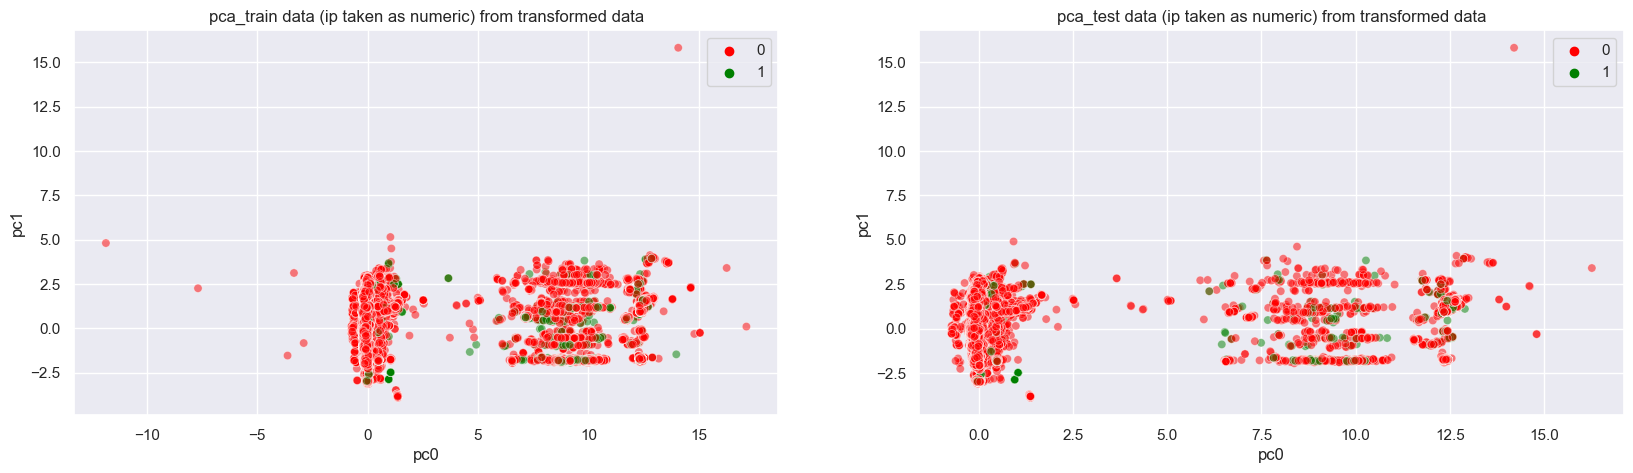

In [192]:
# 38.0 2D PCA plot from first two principal components:

# #$$$$$$$$$$$$$$$ NEEDS REDRAWING. SEE FIGURE TITLES
# #$$$$$$$$$$$$$$$ NEEDS REDRAWING. SEE FIGURE TITLES
# #$$$$$$$$$$$$$$$ NEEDS REDRAWING. SEE FIGURE TITLES


fig = plt.figure(figsize = (20,5));
fig.add_subplot(1,2,1);
sns.set_theme() ; # Set default theme
plt.style.use('seaborn-v0_8-dark-palette')

# 38.0.1 plot pca_train_vec data
sns.scatterplot(data = pca_train_vec,
                x=  'pc0',
                y = 'pc1',
                hue = y_train.values,
                palette = ["red", "green"], alpha = 0.5
                ).set(title='pca_train data from transformed data') ;

# 38.0.2 Plot pca_test_vec data
fig.add_subplot(1,2,2);
sns.scatterplot(data = pca_test_vec,
                x=  'pc0',
                y = 'pc1',
                hue = y_test.values,
                palette = ["red", "green"], alpha = 0.5
                ).set(title='pca_test data  from transformed data') ;

In [193]:
# 30.1.4 Let us examine the above graph more closely:
#      Merge pca_train_vec and y_train
pcatyt = pd.concat([pca_train_vec, y_train.reset_index(drop = True)],  axis = 1)
pcateyt = pd.concat([pca_test_vec, y_test.reset_index(drop = True)],  axis = 1)

# 30.1.5 Data-points when pc0 > 4.0
pcayt_rt= pcatyt.loc[pcatyt.pc0 > 4.0, :]
pcayte_rt= pcateyt.loc[pcateyt.pc0 > 4.0, :]

nf_rt = pcayt_rt['isattributed'].sum() # 3116
nnf_rt = pcayt_rt.shape[0]  # 27791

# 30.1.6 Ratio of fradulent to non-fraudulent
print('Ratio of fraudulent to non-fraudulent to right of pc0 > 4:', nf_rt/(nnf_rt-nf_rt))  # 12.6%

# 30.1.7 Same calculations for the data on the left
#        Data-points when pc0 <= 4.0
pcayt_lt= pcatyt.loc[pcatyt.pc0 <= 4.0, :]
nf_lt = pcayt_lt['isattributed'].sum() # 3116
nnf_lt = pcayt_lt.shape[0]  # 27791

# 30.1.8 Ratio of fradulent to non-fraudulent points:
print('Ratio of fraudulent to non-fraudulent to right of pc0 > 4:', nf_lt/(nnf_lt-nf_lt))  # 0.0016%

Ratio of fraudulent to non-fraudulent to right of pc0 > 4: 0.12769471856338147
Ratio of fraudulent to non-fraudulent to right of pc0 > 4: 0.0016738621396165667


## How good are pc0s in making predictions?
From each unitvector we take the first principal component, ie ['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0'] and make predictions. These five features take us to overall <u>AUC of 0.9620</u>. Thus, effectively, we have reduced five cat columns to five numerical features with one-to-one correspondence between them. We can then evaluate which one is the most important and also perform visualization.

In [30]:
# 31.0 How good are pc0's of respective unit vectors and which one is most important?
#      Time features are not included.S

model_vec_pc0 = xgb.XGBClassifier( n_estimators= 500,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 10,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )


tr_X =    cctr[['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']]
test_X =  ccte[['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']]
ytrain =  y_train
ytest = y_test


model_vec_pc0.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[15:01:18] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[15:01:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.88445	validation_1-auc:0.88205
[15:01:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.88449	validation_1-auc:0.88206
[15:01:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.88449	validation_1-auc:0.88207
[15:01:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.88475	validati

[15:02:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.93397	validation_1-auc:0.93068
[15:02:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 512 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.93400	validation_1-auc:0.93071
[15:02:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.93397	validation_1-auc:0.93072
[15:02:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 512 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.93402	validation_1-auc:0.93077
[15:02:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.95110	validation_1-auc:0.94801
[15:03:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.95120	validation_1-auc:0.94821
[15:03:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.95131	validation_1-auc:0.94839
[15:03:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.95141	validation_1-auc:0.94846
[15:03:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.95174	validation_1-auc:0.94871
[15:03:13] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.96289	validation_1-auc:0.95674
[15:04:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.96331	validation_1-auc:0.95697
[15:04:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.96358	validation_1-auc:0.95697
[15:04:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.96401	validation_1-auc:0.95705
[15:04:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 494 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.96425	validation_1-auc:0.95713
[15:04:14] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.97203	validation_1-auc:0.95935
[15:05:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.97221	validation_1-auc:0.95947
[15:05:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.97237	validation_1-auc:0.95969
[15:05:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.97257	validation_1-auc:0.95981
[15:05:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.97276	validation_1-auc:0.95991
[15:05:19] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.97674	validation_1-auc:0.96162
[15:06:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.97676	validation_1-auc:0.96162
[15:06:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.97687	validation_1-auc:0.96166
[15:06:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.97690	validation_1-auc:0.96165
[15:06:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.97703	validation_1-auc:0.96165
[15:06:25] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.97948	validation_1-auc:0.96199
[15:07:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.97950	validation_1-auc:0.96199
[15:07:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.97964	validation_1-auc:0.96205
[15:07:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.97972	validation_1-auc:0.96201
[15:07:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.97978	validation_1-auc:0.96201
[15:07:32] INFO: C:\Users\dev-admin\croo

[257]	validation_0-auc:0.98142	validation_1-auc:0.96192
[15:08:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.98150	validation_1-auc:0.96188
[15:08:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.98155	validation_1-auc:0.96188
[15:08:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[260]	validation_0-auc:0.98157	validation_1-auc:0.96188
[15:08:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=10
[261]	validation_0-auc:0.98165	validation_1-auc:0.96186
[15:08:41] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [31]:
# 31.0. Save model:

utils.savePythonObject(model_vec_pc0, "model_vec_pc0.pkl", estimatorsPath )

Object saved to: D:\talkingdata\allmodels\estimators\model_vec_pc0.pkl


In [ ]:
# 31.0.2 Restore model:

model_vec_pc0 = utils.restorePythonObject("model_vec_pc0.pkl", estimatorsPath )

In [32]:
# 31.0.3 Best scores:

model_vec_pc0.best_score   # 0.9620497969285831
print("\n")
model_vec_pc0.best_iteration  # 222

0.9620497969285831

222

In [33]:
# 31.1 Classification report:

pred_vec = model_vec_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.78      0.33      0.46      3079

    accuracy                           1.00   1250000
   macro avg       0.89      0.66      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



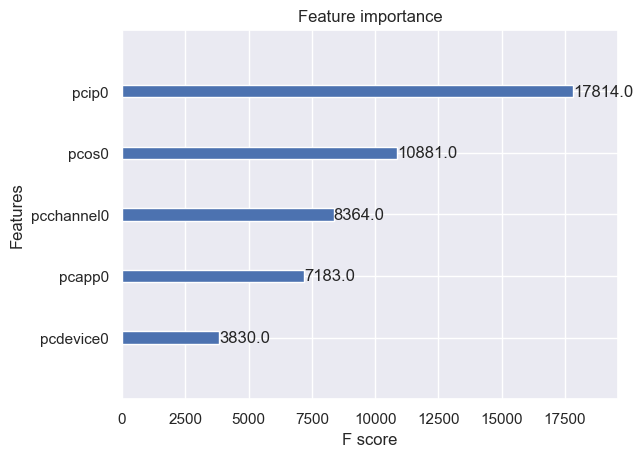

In [37]:
# 31.2 Here is the feature importance. 
#      ip is the most important followed by os, channel, app and device

# #$$$$$$$$$$$$$$$ COMPARE model_org_wt importance
# #$$$$$$$$$$$$$$$ COMPARE model_org_wt importance
# #$$$$$$$$$$$$$$$ COMPARE model_org_wt importance



_=xgb.plot_importance(model_vec_pc0)

In [ ]:
# 31.3 Extract few earlier estimators:

model_vec_pc0=utils.restorePythonObject("model_vec_pc0.pkl", estimatorsPath)
model_orig = utils.restorePythonObject("model_orig.pkl", estimatorsPath)
model_trans = utils.restorePythonObject("model_trans.pkl", estimatorsPath)
model_en = utils.restorePythonObject("model_en.pkl", estimatorsPath)


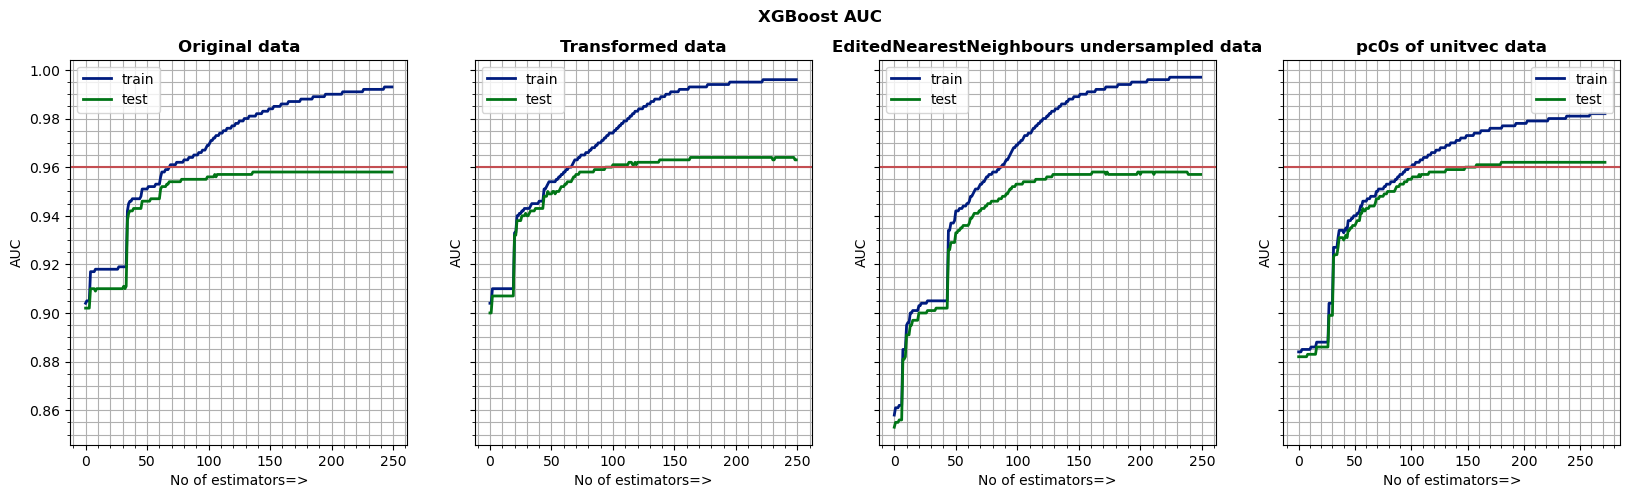

In [166]:
# 31.4 Learning curves

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);

results = [model_orig.evals_result(),model_trans.evals_result(), model_en.evals_result(), model_vec_pc0.evals_result() ]
title = ["Original data", 'Transformed data', 'EditedNearestNeighbours undersampled data', 'pc0s of unitvec data']
fig.suptitle("XGBoost AUC", fontweight = "bold")

for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y = 0.96, color = 'r', linestyle = '-')

plt.show();

### Density plots of features
>Considering that these five features hold lot of information about the data, let us look at their conditional density plots. As the data is highly unbalanced, we will plot density of each of the two levels independently `(In seaborn: common_norm = False)` (see below). Looking at the density plot of `'pcip0'`, it does not appear that it has that good discrimanating power between frauds and genuine events. Yet, in combination with other features, its predictive power increase and that is what is reflected in xgboost feature importance diagrams above. 

In [78]:
# 32.0
cctr['target']= y_train.reset_index(drop = True)

<Figure size 640x480 with 0 Axes>

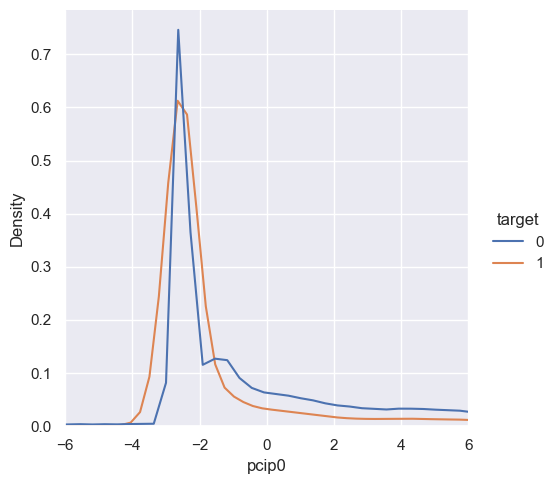

In [75]:
# 32.1 Density plot of 'pcip0':

#_=plt.clf()
_=sns.displot(cctr, x="pcip0", hue="target", kind = "kde", common_norm = False)
_=plt.xlim(-6, 6)

<Figure size 640x480 with 0 Axes>

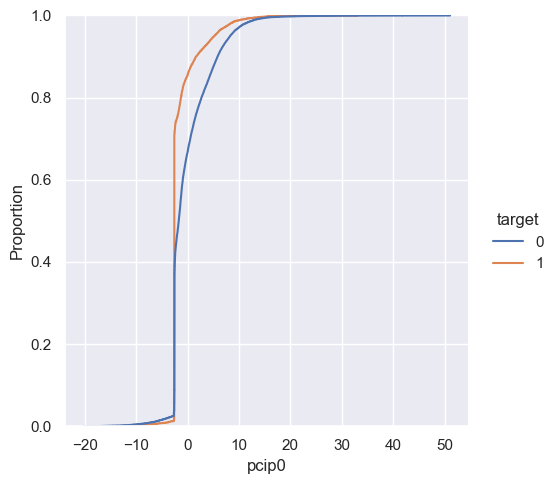

In [80]:
# 32.1.1 ecdf plot of 'pcip0':

#_=plt.clf()
_=sns.displot(cctr, x="pcip0", hue="target", kind = "ecdf")

<Figure size 640x480 with 0 Axes>

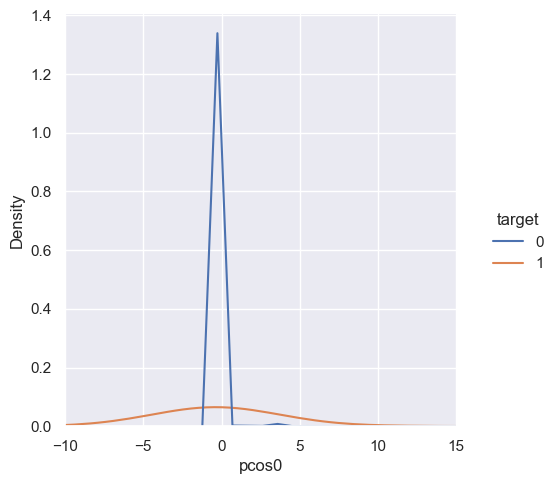

In [66]:
# 32.2 Density plot of 'pcos0':

#_=plt.clf()
_=sns.displot(cctr, x="pcos0", hue="target", kind = "kde", common_norm = False)
_=plt.xlim(-10, 15)

<Figure size 640x480 with 0 Axes>

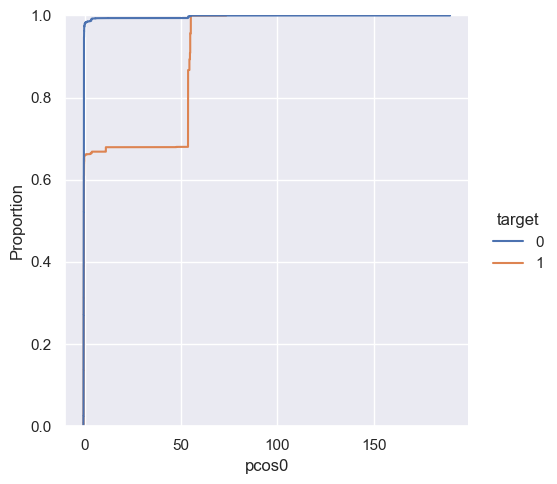

In [81]:
# 32.1.1 ecdf plot of 'pcos0':

#_=plt.clf()
_=sns.displot(cctr, x="pcos0", hue="target", kind = "ecdf")

<Figure size 640x480 with 0 Axes>

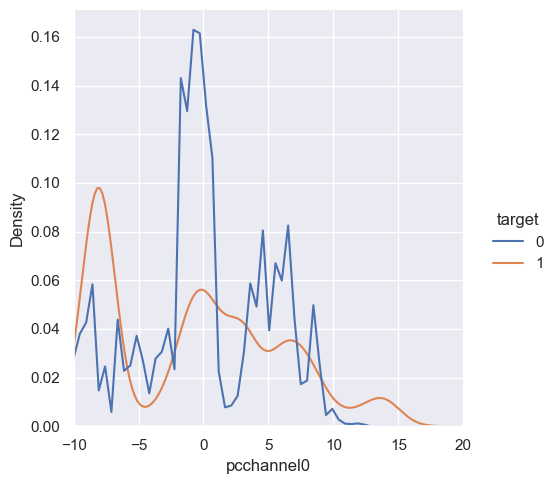

In [61]:
# 32.3 Density plot of 'pcchannel0'
#_=plt.clf()
_=sns.displot(cctr, x="pcchannel0", hue="target", kind = "kde", common_norm = False)
_=plt.xlim(-10, 20)

<Figure size 640x480 with 0 Axes>

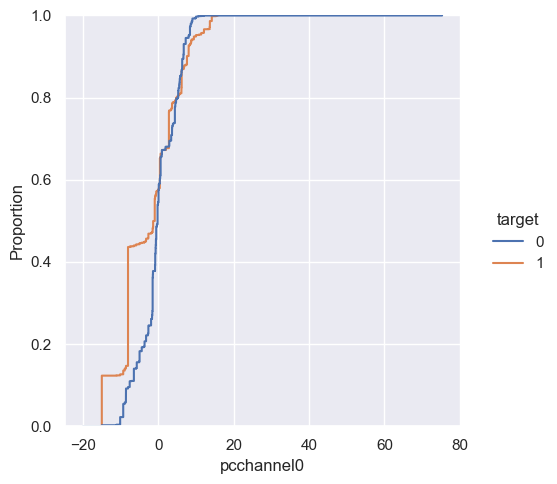

In [82]:
# 32.3.1 ecdf plot of 'pcchannel0':

#_=plt.clf()
_=sns.displot(cctr, x="pcchannel0", hue="target", kind = "ecdf")
#_=plt.xlim(-6, 6)

<Figure size 640x480 with 0 Axes>

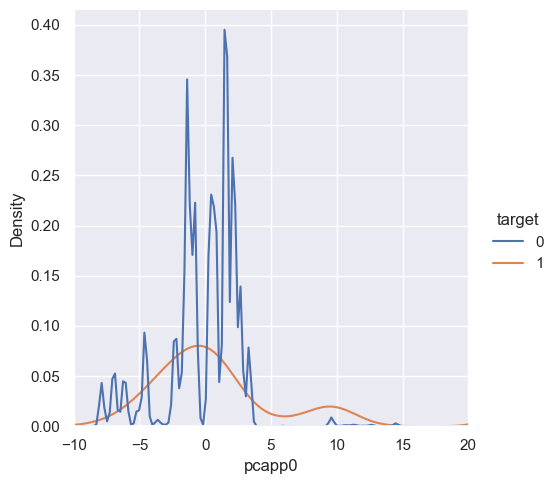

In [63]:
# 32.4 Density plot of pcapp0
#_=plt.clf()
_=sns.displot(cctr, x="pcapp0", hue="target", kind = "kde", common_norm = False)
_=plt.xlim(-10, 20)

<Figure size 640x480 with 0 Axes>

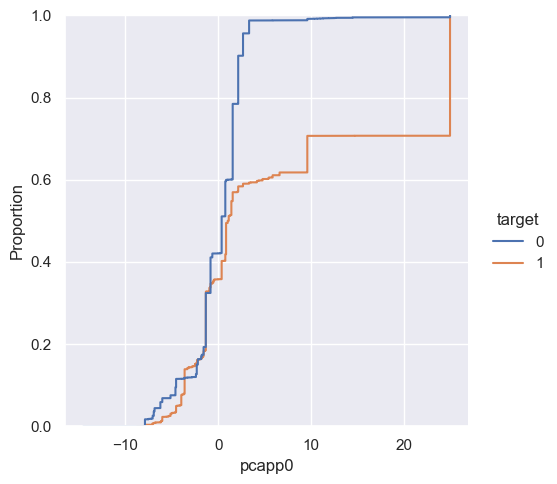

In [83]:
# 32.4.1 ecdf plot of 'pcapp0':

#_=plt.clf()
_=sns.displot(cctr, x="pcapp0", hue="target", kind = "ecdf")
#_=plt.xlim(-6, 6)

<Figure size 640x480 with 0 Axes>

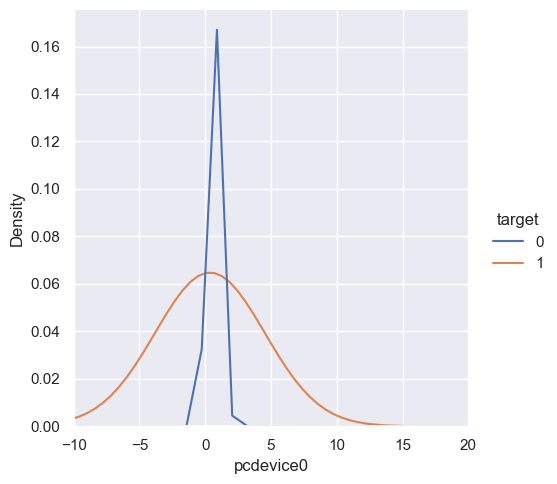

In [69]:
# 32.5 Density plot of pcdevice0:
#_=plt.clf()
_=sns.displot(cctr, x="pcdevice0", hue="target", kind = "kde", common_norm = False)
_=plt.xlim(-10, 20)

<Figure size 640x480 with 0 Axes>

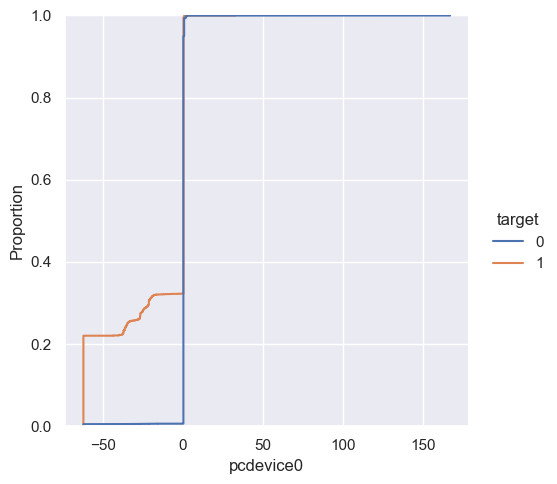

In [88]:
# 32.5.1 ecdf plot of 'pcdevice0':

#_=plt.clf()
_=sns.displot(cctr, x="pcdevice0", hue="target", kind = "ecdf")
#_=plt.xlim(-50, 10)

In [89]:
# 32.5.1.1
_= cctr.pop('target')

## Which levels are impt
>Within features, can we discover levels that do not contribute or contribute very less to fraudulent events. We can use unitvectors to extract this information. For each cat feature, we take the corresponding unitvectors, pc0 and pc1; and make a conditional scatter plot. We then look at regions where no fraudulent activity occurs.

>Given, pc0 and pc1 for a feature, we draw two scatter plots, one for those observations where only genuine events are present and another for fraudulent observations. This way we are able to discover limits or boundaries of fraudulent space.

In [90]:
# 33.0 Scatter plot of pc0 vs pc1 for each set of unitvectors
#      Two scatter plots are drawn
def plotposneg(df,        # It has only two columns pc0 and pc1 (eg for ip pcip0 and pcip1)
               ytrain, 
               ylim0 = None, ylim1 = None, # Upper limits for pc0 and pc1 axis
               x0= None,y0 = None,  # For drawing a line between (x0,y0) to (x1,y1)
               x1=None, y1 = None,
               x00 = None, y00 = None, # For drawing a line between (x00,y00) to (x10,y10)
               x10 =  None,y10=None,
               tx0= None, ty0 = None, # Coord of text to be written: "Genuine trans region"
               linecolor = None,
               titletext = None,  # Graph title text
               vlinepos = None,  # Vertical line pos 
               hlinepos = None   # Horizontal line pos
              ):
    
       
    if ylim0 is None:
        ylim0 = 15
        
    if linecolor is None:
        linecolor = "g"
        
    
    
    
    # 33.0.1 Let us examine the above graph more closely:
    #        Concat df and y_train
    pcatyt = pd.concat([df, ytrain.reset_index(drop = True)],  axis = 1)
    
    # 33.0.2 Patterns in +ve and -ve samples
    # Positive samples
    pca_onlypos = pcatyt.loc[pcatyt.isattributed == 1, :]
    # 33.0.3 Negative samples
    pca_onlyneg = pcatyt.loc[pcatyt.isattributed == 0, :]
    
    # 33.0.4 Separate scatter plots of positive and negatives: 
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize = (10,10));
    plt.style.use('default')
    plt.rc('grid', linestyle="-")
    plt.tight_layout();

    data = pca_onlypos.iloc[:,:-1]
    data1 = pca_onlyneg.iloc[:,:-1]

    _=axs[0].scatter(data.pc0, data.pc1, c="red", alpha=0.5);
    axs[0].grid(True)
    _=axs[0].set_title("Fraudulent events pattern--" + titletext);
    _=axs[0].set_ylabel('pc1');
    _=axs[0].set_facecolor("khaki")

    _=axs[1].scatter(data1.pc0, data1.pc1, c="blue", alpha=0.5);
    _=axs[1].set_title("Genuine events pattern--"+titletext);
    _=axs[1].set_xlabel('pc0');
    _=axs[1].set_ylabel('pc1');
    _=axs[1].set_facecolor("khaki")
   
    # 33.0.5 Draw bounds of fraudulent events
    # https://stackoverflow.com/a/16930526/3282777
    if x0 is not None:
        _=axs[0].plot((x0, x1), (y0, y1),  linewidth = 4, color = linecolor)
        _=axs[1].plot((x0, x1), (y0, y1),  linewidth = 4, color = linecolor)
    if x00 is not None:
       _=axs[0].plot((x00, x10), (y00, y10), 'g-', linewidth = 4)
       _=axs[1].plot((x00, x10), (y00, y10), 'g-', linewidth = 4)

    _=axs[0].set_ylim(top = ylim0)
    _=axs[1].set_ylim(top = ylim1)
     
    if tx0 is not None:
        axs[0].text(tx0,ty0, "Genuine trans region", fontsize = 15)
        axs[1].text(tx0,ty0, "Genuine trans region", fontsize = 15)
        
    if vlinepos is not None:
        axs[0].axvline(x = vlinepos,color = "red")
        axs[1].axvline(x = vlinepos,color = "red")
    if hlinepos is not None:
        axs[0].axhline(y = hlinepos,color = "red")
        axs[1].axhline(y = hlinepos,color = "red")    
        
    axs[1].grid(True)
    plt.show()

In [93]:
# 33.1 Our transformed data with y_train concatenated:

xt = pd.concat([X_train, y_train.reset_index(drop = True)],  axis = 1)
xte = pd.concat([X_test, y_test.reset_index(drop = True)],  axis = 1)
xt.shape
xt.head()

(3750000, 10)

ip  app  device  os  channel  day  hour  minute  second  isattributed
0   52924    3       1  19      489    9     1      31      26             0
1   16087   18       1  13      107    9     6       3       8             0
2  352750   14       1  16      379    9     3      30      17             0
3   32558    2       1  27      477    7    13      30      31             0
4  274987   12       1  19      340    9     6      14       5             0

In [95]:
# 33.2 This is our complete original data

train_full = pd.read_pickle(dataPath / "train_full.pkl")
train_full.shape  #  (176903891, 8)
train_full['is_attributed'].value_counts(normalize = True)
gc.collect()

(176903891, 8)

0    0.997529
1    0.002471
Name: is_attributed, dtype: float64

52050

### Using unitvectors of 'ip'

In [ ]:
# 34.0 For our complete train_full data, ratio of frauds to total data is:
train_full.is_attributed.sum()/train_full.shape[0]  # 0.0024

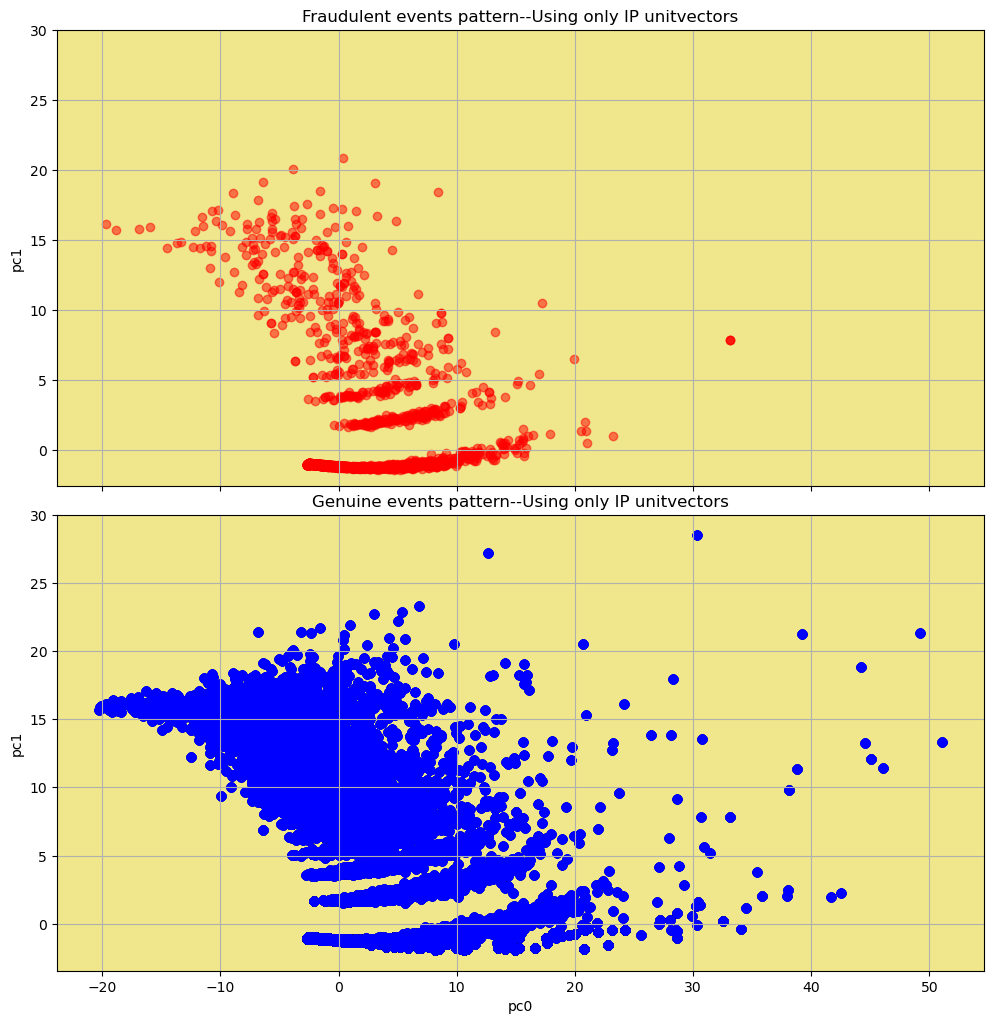

In [105]:
# 34.1 Create a dataframe using pcip0 and pcip1
#      (Two PCs of unitvectors of ip)

df = pd.DataFrame()
df['pc0'] = []
df['pc1']= []
df.pc0 = cctr.pcip0
df.pc1 = cctr.pcip1

# 34.1.1 Scatter plots to see patterns of genuine/fraud events:

plotposneg(df, y_train, ylim0 = 30, ylim1 = 30, titletext = "Using only IP unitvectors")

In [115]:
# 34.1.2 The area enclosed by following boundaries has very less fraud events
#        but a good amount of genuine clicks.
row_index = cctr.loc[(cctr.pcip0 > 6)   | (cctr.pcip1 > 5),   :].index

# 34.1.3 Extract corresponding rows from xt to check which IPs
#        occur here.
dfx = xt.iloc[row_index]
dfx.shape  # (607765, 10)

# 34.1.4 Extract from train_full rows having those IPs with minimal frauds:
bt = train_full.loc[train_full['ip'].isin(dfx.ip.values)]

# 34.1.5 For such rows what is the ratio of frauds to toal:
print("Ratio of frauds to total data is:" ,  bt.is_attributed.sum()/bt.shape[0])  # 0.0011268221698019828

# 34.1.6 Number of unique IPs to total unique IPs is:
print("Ratio of unique IPs in the less fraud subset to toal unique IPs in the complete data: ", len(dfx['ip'].unique())/len(train_full['ip'].unique()))  # 0.029426272913901038

(607765, 10)

Ratio of frauds to total data is: 0.0011268221698019828
Number of unique IPs in the less fraud subset to toal unique IPs in the complete data:  0.029426272913901038


In [117]:
# 34.2.1 This is another area of less fraud:
row_index = cctr.loc[(cctr.pcip0 < 6)   | (cctr.pcip1 < 5),   :].index
dfx = xt.iloc[row_index]
dfx.shape
bt = train_full.loc[train_full['ip'].isin(dfx.ip.values)]
print("Ratio of frauds to total data is:" ,  bt.is_attributed.sum()/bt.shape[0])      # 0.0015435745436651448
print("Ratio of unique IPs in the less fraud subset to toal unique IPs in the complete data: ", len(dfx['ip'].unique())/len(train_full['ip'].unique()))  # 0.029426272913901038len(dfx['ip'].unique())/len(train_full['ip'].unique())  # 0.42031729450936867

(3713474, 10)

Ratio of frauds to total data is: 0.0015435745436651448
Number of unique IPs in the less fraud subset to toal unique IPs in the complete data:  0.42031729450936867


### Using unitvectors of channel

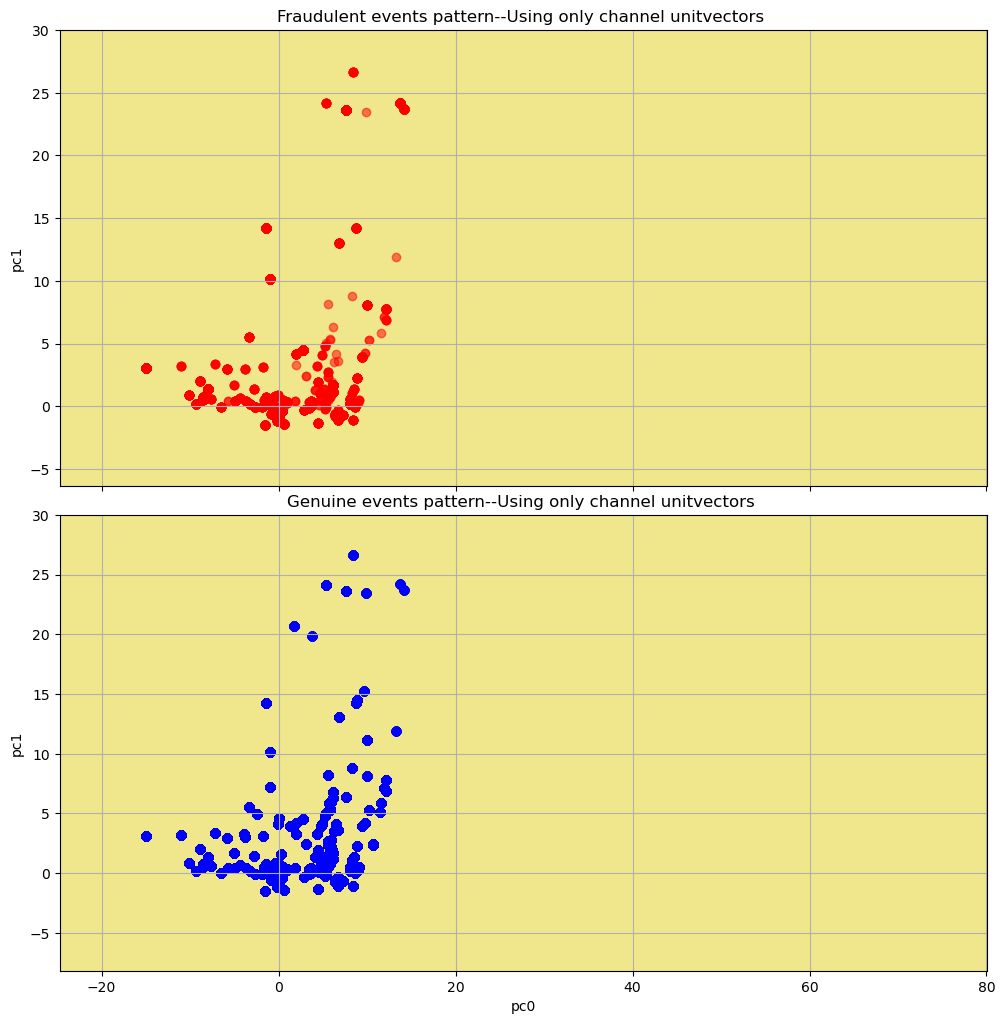

In [119]:
# 35.0 
df = pd.DataFrame()
df['pc0'] = []
df['pc1']= []
df.pc0 = cctr.pcchannel0
df.pc1 = cctr.pcchannel1

# 35.1  Scatter plots to see patterns of genuine/fraud events:
plotposneg(df, y_train, ylim0 = 30, ylim1 = 30, titletext = "Using only channel unitvectors ")

In the above two patterns, we could not determine regions of no-frauds or less frauds

### Using unitvectors of os

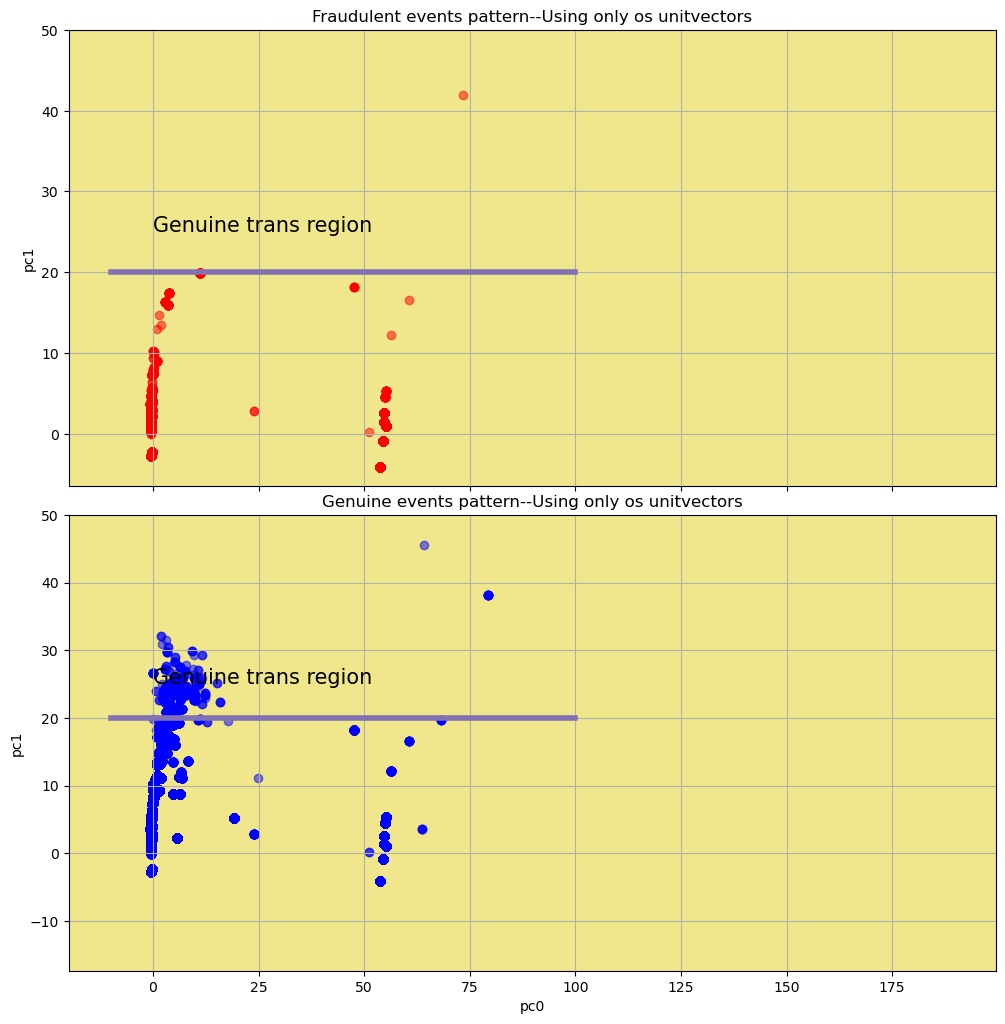

In [120]:
# 36.0
df = pd.DataFrame()
df['pc0'] = []
df['pc1']= []
df.pc0 = cctr.pcos0
df.pc1 = cctr.pcos1

# 36.0.1 Scatter plots to see patterns of genuine/fraud events:
plotposneg(df, y_train, ylim0 = 50, ylim1 = 50, x0 = -10, y0 = 20, x1 = 100,y1 = 20, tx0 =0, ty0=25, 
           linecolor = "m", titletext = "Using only os unitvectors" )

In [124]:
# 36.1 
row_index = cctr.loc[(cctr.pcos1 >= 20)  & (cctr.pcos0 < 65) , :].index
dfx = xt.iloc[row_index]
dfx.shape
dfx.head()
bt = train_full.loc[train_full['os'].isin(dfx.os.values)]
print("Ratio of frauds to total data is:" , bt.is_attributed.sum()/bt.shape[0]  ) # 0.0008028136707699365
print("Ratio of unique OSs in the less fraud subset to toal unique IOS in the complete data: ", len(dfx['os'].unique())/len(train_full['os'].unique()))  # 0.10466582597730138

(604, 10)

ip  app  device   os  channel  day  hour  minute  second  \
1754    48282    9       2  164      466    8    13       4       2   
38289  158417   15       1  164      315    7    22      46      43   
39631   86571    2       1  129      364    8    17      56      38   
43951   64618    1       1  152      377    9    15      42      32   
46866  176842    2       1  152      435    9     5      45      20   

       isattributed  
1754              0  
38289             0  
39631             0  
43951             0  
46866             0

Ratio of frauds to total data is: 0.0008028136707699365
Number of unique OSs in the less fraud subset to toal unique IOS in the complete data:  0.10466582597730138


### USing unitvectors of device

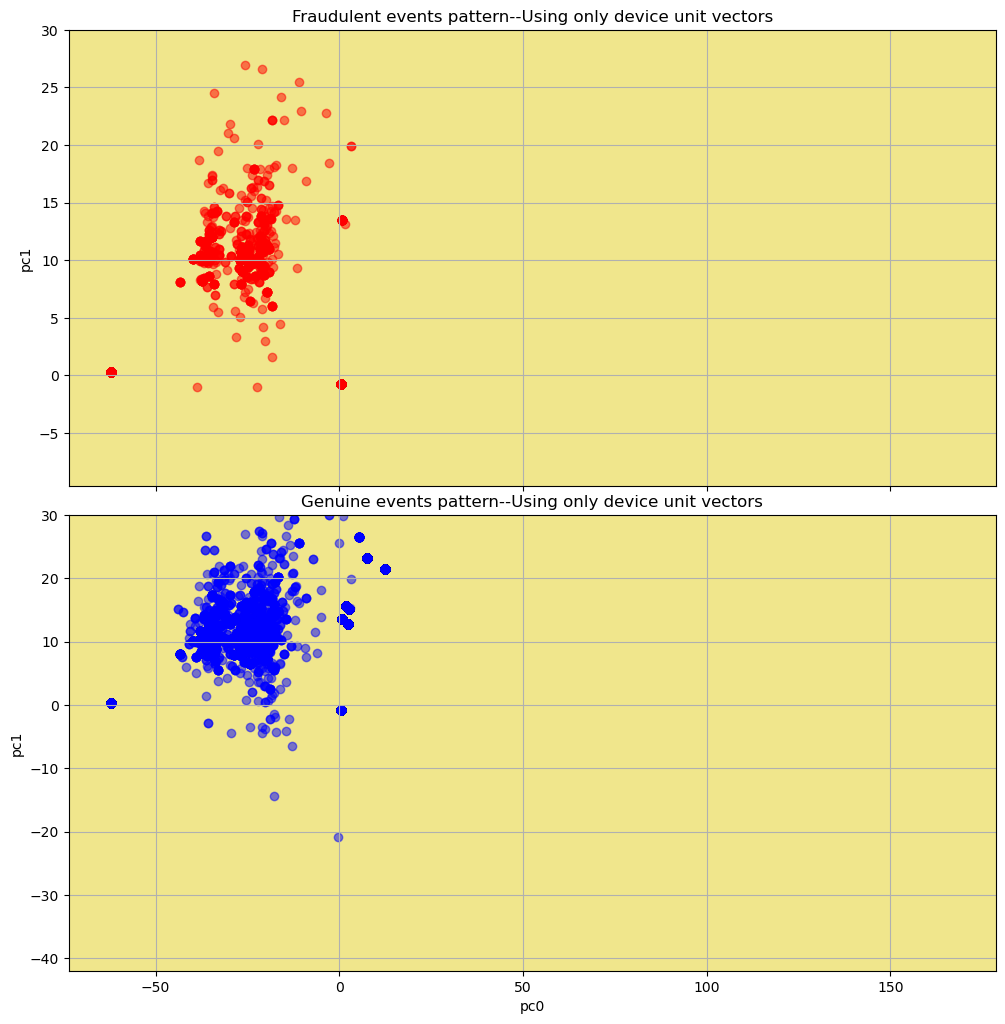

In [125]:
# 37.0
df = pd.DataFrame()
df['pc0'] = []
df['pc1']= []
df.pc0 = cctr.pcdevice0
df.pc1 = cctr.pcdevice1
plotposneg(df, y_train, ylim0 = 30, ylim1 = 30, titletext = "Using only device unit vectors")

Here also it is difficult to determine regions of non-fraudlent events.

### Using unitvectors of app

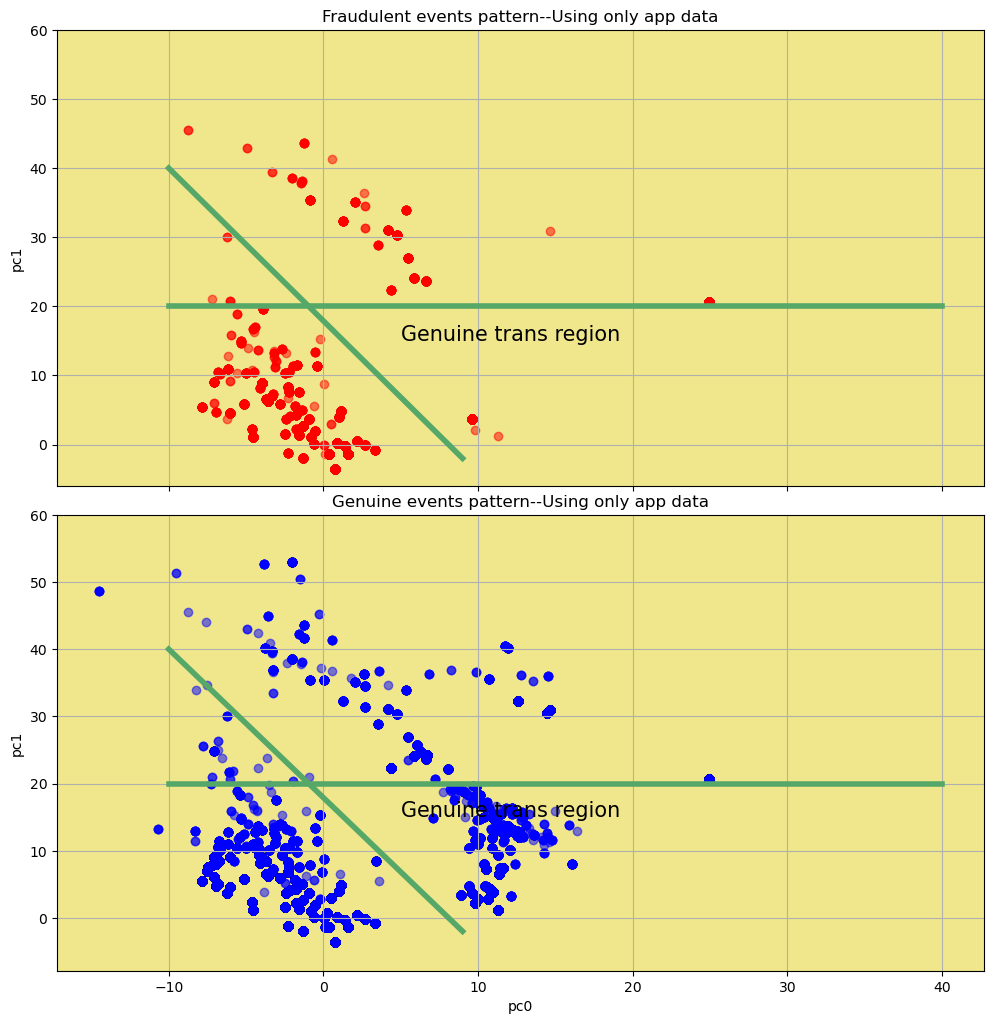

In [126]:
# 38.0
df = pd.DataFrame()
df['pc0'] = []
df['pc1']= []
df.pc0 = cctr.pcapp0
df.pc1 = cctr.pcapp1
plotposneg(df, y_train, ylim0 = 60, ylim1 = 60, x0 = -10, y0= 20, x1 = 40, y1=20, x00 = -10, y00=40, x10 = 9 , y10= -2, 
           tx0=5 , ty0 = 15, titletext = "Using only app data")

In [128]:
# 38.1
row_index = cctr.loc[  (cctr.pcapp1 >5) & (cctr.pcapp1 <= 20)  & (cctr.pcapp0 > 5) , :].index
dfx = xt.iloc[row_index]
dfx.shape  # (5174, 10)
dfx.head()
bt = train_full.loc[train_full['app'].isin(dfx.app.values)]
print("Ratio of frauds to total data is:" , bt.is_attributed.sum()/bt.shape[0]  ) # 0.0
print("Ratio of unique apps in the less fraud subset to toal unique apps in the complete data: ", len(dfx['app'].unique())/len(train_full['app'].unique()))  #0.14835948644793154


(5174, 10)

ip  app  device   os  channel  day  hour  minute  second  \
221    26564  134    3866  866      347    8    18       1      45   
651    68349  119    3032  607      347    7     9      29      49   
1117   54401   68    3866  866      347    9    13      16       1   
2018  299172  183    3866  866      347    8    21      21      58   
3027  176789  146    3866  866      347    9    12      37      49   

      isattributed  
221              0  
651              0  
1117             0  
2018             0  
3027             0

Ratio of frauds to total data is: 0.0
Number of unique apps in the less fraud subset to toal unique apps in the complete data:  0.14835948644793154


### Using unitvectors of app and channel together
We take all the unitvectors of `app` and `channel` and then take a PCA of them. From the resulting transformation, we pick up pc0 and pc1 for plotting patterns of fraudulent and genuine events.

In [130]:
# 39.0 Extract columns of unitvectors pertaining to app and channel:
df = cctr
colList = []
c0 = 'app'
c1 = 'channel'
coCols = [df.columns[i] for i in range(df.shape[1]) if c0 in df.columns[i] ]  
c1Cols = [df.columns[i] for i in range(df.shape[1]) if c1 in df.columns[i] ]  
colList.extend(coCols)
colList.extend(c1Cols)
print(colList)

['pcapp0', 'pcapp1', 'pcapp2', 'pcapp3', 'pcchannel0', 'pcchannel1', 'pcchannel2', 'pcchannel3']


In [132]:
# 39.1 Define a function that takes PCAs of unitvectors of two features, say app and os
colList = []
def twoFields(df,c0,c1):
    """
    df: Dataframe of unitvectors (cctr)
    c0: Cat feature name
    c1: Cat feature name
    """
    coCols = [df.columns[i] for i in range(df.shape[1]) if c0 in df.columns[i] ]  
    c1Cols = [df.columns[i] for i in range(df.shape[1]) if c1 in df.columns[i] ]  
    colList.extend(coCols)
    colList.extend(c1Cols)
    pca = PCA(n_components= 0.95,
          #whiten= True, 
          random_state = rng
         )
    ss = StandardScaler()
    re = pca.fit_transform(ss.fit_transform(cctr[colList]))
    colnames = ["pc" + str(i) for i in range(re.shape[1])]
    re = pd.DataFrame(re, columns = colnames)
    return re
    

In [133]:
# 39.2 Apply above function to 'app' and 'os' unitvectors
result = twoFields(cctr,'app','os')
result.head()

pc0       pc1       pc2       pc3       pc4       pc5       pc6
0 -0.103627  0.280716  1.121682 -0.903668  0.281133  0.084173 -0.080077
1 -0.015623  1.174920 -0.540457  0.138060 -1.013275  2.221723 -1.601100
2  0.145440 -0.225609 -0.188324 -0.243228 -0.672411 -1.141303  0.060384
3 -0.071717 -0.820204 -1.143616 -0.588178 -1.166293 -0.239459  1.135548
4 -0.371147  0.682052  0.874518 -0.330514  0.854288  0.331336 -0.481413

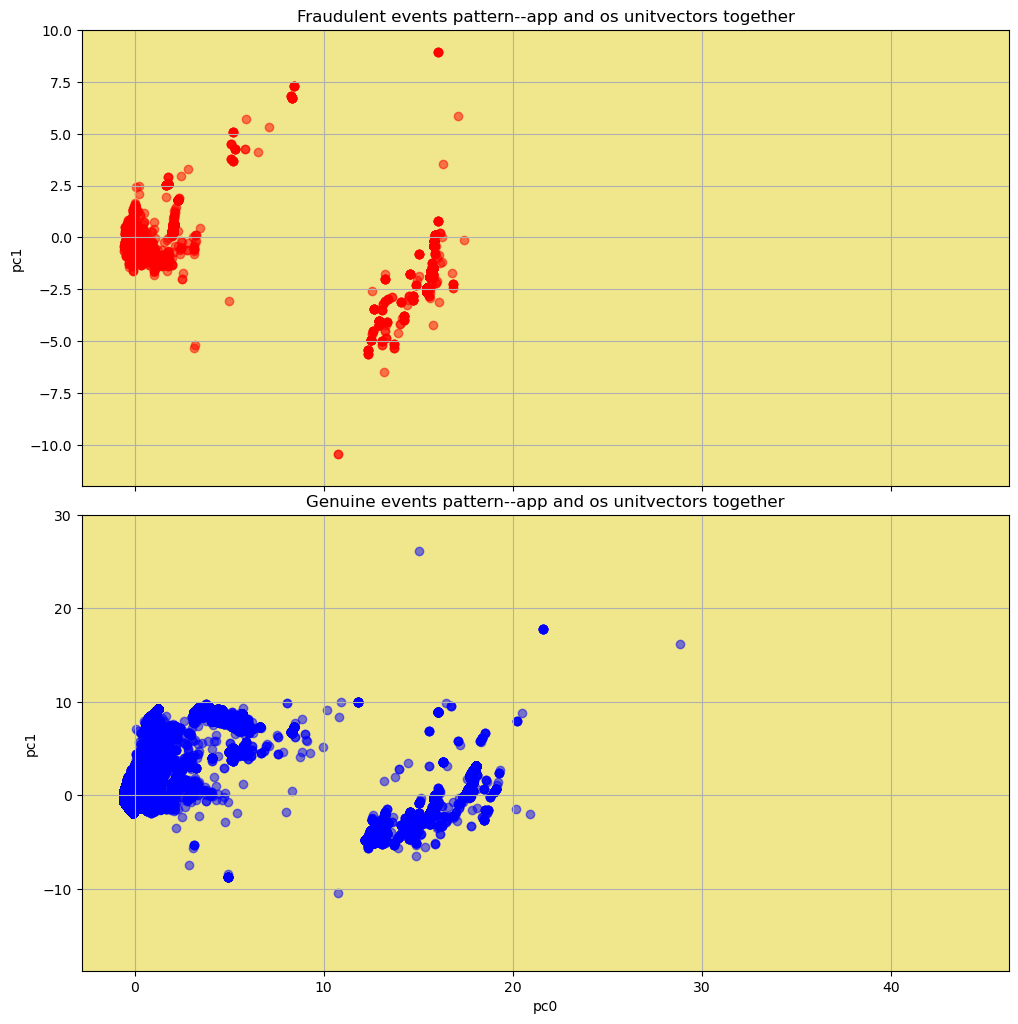

In [135]:
# 39.3 See how the scatter plots of genuine and fraudlent events appear:
plotposneg(result, y_train, ylim0 = 10, ylim1 = 30,titletext = "app and os unitvectors together")

In [142]:
# 39.4 Extract from train_full data, dataframe of only two features:
bt = train_full[['app','os', 'is_attributed']]
bt.shape # (176903891, 3)
# How many unique combinations of app and os exist?
denom = bt[['app','os']].drop_duplicates().shape[0]

(176903891, 3)

0

In [145]:
# 39.5 Region of no-frauds as seen from the above graphs
# row_index = cctr.loc[(result.pc1 > 2)    , :].index
#row_index = cctr.loc[((result.pc1 > 5.0) & (result.pc0 <11.0)) | ((result.pc0 > 3.0)  &   (result.pc0 <12) &   (result.pc1 < 0)   )    , :].index
# row_index = cctr.loc[((result.pc1 > 5.0) & (result.pc0 <12.0))    , :].index
row_index = cctr.loc[((result.pc1 > 5.0) & (result.pc0 <12.0))| (result.pc0 >20)    , :].index

In [150]:
# 39.6 Filtering a dataframe based upon column values of another dataframe
# We now need to filter bt, based upon columns dfx.app and dfx.os
# Ref https://stackoverflow.com/a/33282617/3282777
# Here is our dataset of no-frauds
dfx = xt.iloc[row_index]
# From dfx get only two columns 'app' and 'os'
dfx = dfx[['app', 'os']]
# Drop duplicate pairs
dfx = dfx.drop_duplicates()
# Now filter bt based upon dfx
keys = list(dfx.columns.values)
i2 = dfx.set_index(keys).index
i1 = bt.set_index(keys).index
sk = bt[i1.isin(i2)]
print("Ratio of frauds to total data is:" , sk.is_attributed.sum()/sk.shape[0]  ) # 0.0011580836506145343
print("Ratio of unique app+os combinations in the less fraud subset to toal unique app+os in the complete data: ", len(dfx)/denom)  # 0.04605793912724606

Ratio of frauds to total data is: 0.0011580836506145343
Number of unique app+os combinations in the less fraud subset to toal unique apps in the complete data:  0.04605793912724606


### Using unitvectors of app and device together
We take all the unitvectors of `app` and `device` and then take a PCA of them. From the resulting transformation, we pick up pc0 and pc1 for plotting patterns of fraudulent and genuine events.

In [151]:
# 40.0 We repeat the same steps as before
result = twoFields(cctr,'app','device')
result.head()

pc0       pc1       pc2       pc3       pc4       pc5       pc6  \
0 -0.174915  0.335003 -0.833773  0.899193 -0.250724 -0.863239  0.214586   
1 -0.032344  2.494302 -0.528297 -2.969226 -0.864361  0.147162  1.204571   
2  0.211433 -0.347087 -1.046638  0.756859 -0.095008  0.488139 -0.536810   
3 -0.101845 -2.038208 -1.421613 -1.145746  0.480412  0.549345 -0.529829   
4 -0.560658  1.175439  0.328711  0.588130 -0.409757 -0.854932  0.288399   

        pc7       pc8       pc9  
0 -0.162420  0.758252  0.138375  
1 -0.830071 -0.035484 -0.293707  
2  0.375092 -0.590240  0.226789  
3  0.250018 -0.575990  0.504359  
4 -0.070024  0.753439  0.043062

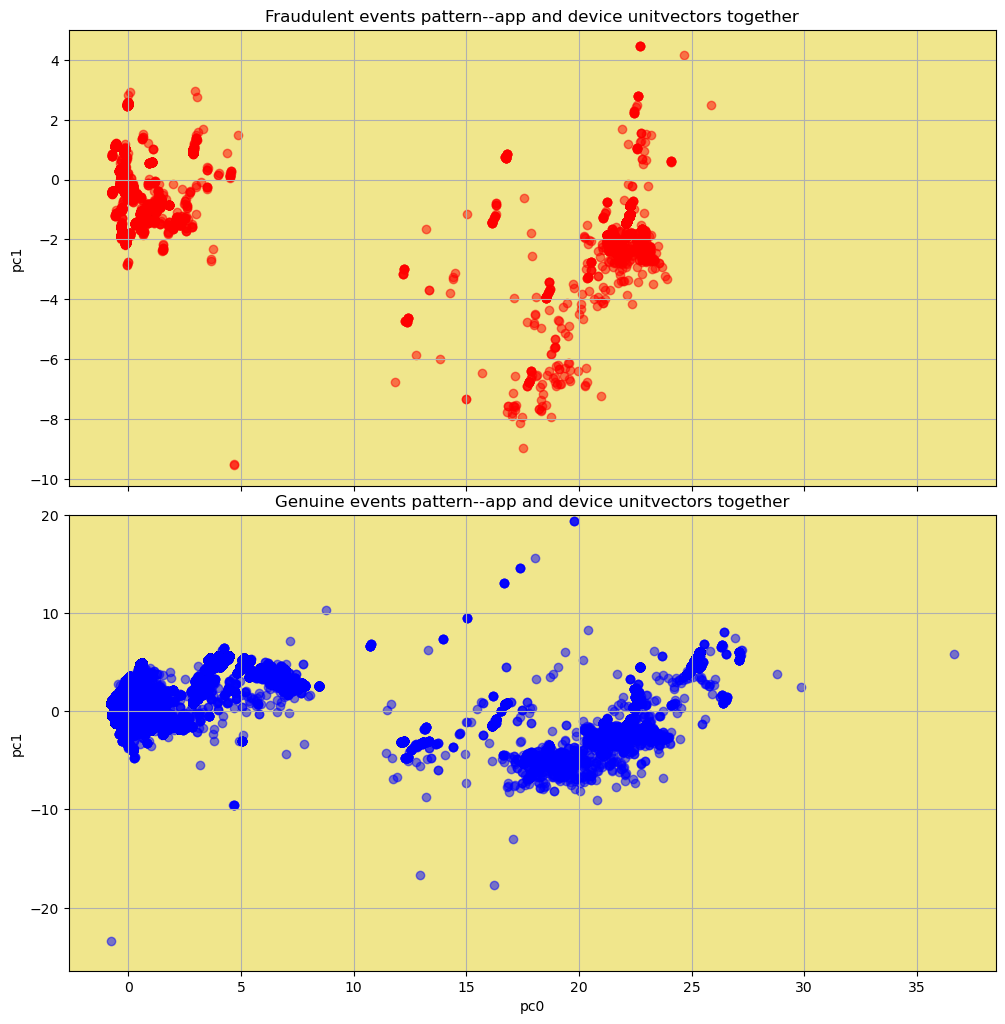

In [153]:
# 40.1
plotposneg(result, y_train, ylim0 = 5, ylim1 = 20, titletext = "app and device unitvectors together")

In [155]:
# 40.2 Some tested filters
row_index = cctr.loc[((result.pc1 > 2.5)  & (result.pc0 < 9)) | (result.pc1 > 1.0 ) | (result.pc0 > 12.2 ) | (result.pc1 < -2 )  , :].index
row_index = cctr.loc[((result.pc1 > 2.0)  & (result.pc0 < 20))   , :].index
row_index = cctr.loc[((result.pc1 > 2.0)  & (result.pc0 < 20)) | ((result.pc1 <-5.0))   , :].index

In [156]:
# 40.3 Same steps as before here:
row_index = cctr.loc[((result.pc1 > 2.0)  & (result.pc0 < 20)) | ((result.pc1 <-5.0))   , :].index
dfx = xt.iloc[row_index]
dfx = dfx[['app', 'device']]
dfx = dfx.drop_duplicates()
dfx.shape  # (679, 2)
bt = train_full[['app','device', 'is_attributed']]
gc.collect()
denom = bt[['app','device']].drop_duplicates().shape[0]

(679, 2)

7187

In [158]:
# 40.4
# https://stackoverflow.com/a/33282617/3282777
keys = list(dfx.columns.values)
i2 = dfx.set_index(keys).index
i1 = bt.set_index(keys).index
sk = bt[i1.isin(i2)]
print("Ratio of frauds to total data is:" , sk.is_attributed.sum()/sk.shape[0]  ) # 0.0008535792276681444
print("Ratio of unique app+device combinations in the less fraud subset to toal unique app+device in the complete data: ", len(dfx)/denom)  # 0.05670146137787056

0.0008535792276681444

0.05670146137787056

Ratio of frauds to total data is: 0.0008535792276681444
No. of unique app+device combinations in the less fraud subset to toal unique app+device in the complete data:  0.05670146137787056


## ROUGH

In [ ]:
# 16.0 Call imblearn library:

from imblearn.under_sampling import EditedNearestNeighbours,OneSidedSelection,AllKNN  
from imblearn.combine import SMOTEENN

In [206]:
dtrX =  cctr[['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']]
dteX =  ccte[['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']]

In [207]:
# 16.1 Undersample pca_train data:
gc.collect()
start = time.time()
undersample = EditedNearestNeighbours()   
X_res_pc0, y_res_pc0 = undersample.fit_resample(dtrX, y_train.values)
end = time.time()
print((end-start)/60)  # 9min

44

8.560714558760326


In [211]:
# 16.1.1 Data shape
X_res_pc0.shape  #  (3737267, 5)
y_res_pc0.shape  #  (3737267,)

(3737267, 5)

(3737267, 1)

In [212]:

# 16.1.2 Save above files
X_res_pc0.to_pickle(dataPath / "X_res_pc0.pkl")
y_res_pc0 = pd.DataFrame(y_res_pc0, columns= [ 'isattributed'])
y_res_pc0.to_pickle(dataPath / "y_res_pc0.pkl")
gc.collect()

0

In [213]:
# 16.1.3 Read back
X_res_pc0 = pd.read_pickle(dataPath / "X_res_pc0.pkl")
y_res_pc0 = pd.read_pickle(dataPath / "y_res_pc0.pkl")
y_res_pc0.value_counts(normalize = True) # 99.75 : 0.25
y_train.value_counts(normalize = True) # 99.75:0.25


isattributed
0               0.997528
1               0.002472
dtype: float64

0    0.997537
1    0.002463
Name: isattributed, dtype: float64

In [214]:

# 17.1 xgboost Modeling with undersampled data
gc.collect()
model_res_pc0 = xgb.XGBClassifier( n_estimators= 400,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 10,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res_pc0 
test_X = dteX
ytrain = y_res_pc0 
ytest =  y_test


model_res_pc0.fit(tr_X, ytrain.values,                  
          early_stopping_rounds = 100,   
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']    
          )



0

[06:19:15] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[06:19:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.88507	validation_1-auc:0.88194
[06:19:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.88535	validation_1-auc:0.88194
[06:19:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.88498	validation_1-auc:0.88133
[06:19:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.88558	validati

[06:20:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 524 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.93299	validation_1-auc:0.92974
[06:20:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.93435	validation_1-auc:0.93151
[06:20:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.93295	validation_1-auc:0.92977
[06:20:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.93296	validation_1-auc:0.92979
[06:20:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.95318	validation_1-auc:0.94884
[06:21:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.95363	validation_1-auc:0.94921
[06:21:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.95369	validation_1-auc:0.94931
[06:21:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.95467	validation_1-auc:0.94994
[06:21:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.95499	validation_1-auc:0.95021
[06:21:10] INFO: C:\Users\dev-admin\croot2\xg

[109]	validation_0-auc:0.96597	validation_1-auc:0.95724
[06:22:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 504 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.96611	validation_1-auc:0.95732
[06:22:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.96652	validation_1-auc:0.95743
[06:22:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 460 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.96683	validation_1-auc:0.95749
[06:22:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.96707	validation_1-auc:0.95751
[06:22:13] INFO: C:\Users\dev-admin\croo

[146]	validation_0-auc:0.97429	validation_1-auc:0.95964
[06:23:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.97452	validation_1-auc:0.95982
[06:23:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.97468	validation_1-auc:0.95988
[06:23:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.97485	validation_1-auc:0.95998
[06:23:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-auc:0.97496	validation_1-auc:0.96013
[06:23:21] INFO: C:\Users\dev-admin\croo

[183]	validation_0-auc:0.97904	validation_1-auc:0.96123
[06:24:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.97914	validation_1-auc:0.96125
[06:24:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.97918	validation_1-auc:0.96128
[06:24:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.97932	validation_1-auc:0.96128
[06:24:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=10
[187]	validation_0-auc:0.97939	validation_1-auc:0.96132
[06:24:28] INFO: C:\Users\dev-admin\croo

[220]	validation_0-auc:0.98167	validation_1-auc:0.96152
[06:25:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.98173	validation_1-auc:0.96153
[06:25:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.98181	validation_1-auc:0.96157
[06:25:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=10
[223]	validation_0-auc:0.98184	validation_1-auc:0.96158
[06:25:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[224]	validation_0-auc:0.98190	validation_1-auc:0.96158
[06:25:36] INFO: C:\Users\dev-admin\croo

[257]	validation_0-auc:0.98345	validation_1-auc:0.96151
[06:26:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.98350	validation_1-auc:0.96151
[06:26:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.98351	validation_1-auc:0.96153
[06:26:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 298 extra nodes, 0 pruned nodes, max_depth=10
[260]	validation_0-auc:0.98355	validation_1-auc:0.96156
[06:26:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[261]	validation_0-auc:0.98363	validation_1-auc:0.96154
[06:26:42] INFO: C:\Users\dev-admin\croo

[294]	validation_0-auc:0.98486	validation_1-auc:0.96131
[06:27:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=10
[295]	validation_0-auc:0.98490	validation_1-auc:0.96131
[06:27:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=10
[296]	validation_0-auc:0.98491	validation_1-auc:0.96132
[06:27:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=10
[297]	validation_0-auc:0.98493	validation_1-auc:0.96131
[06:27:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=10
[298]	validation_0-auc:0.98497	validation_1-auc:0.96129
[06:27:49] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [215]:
# 31.0.1 Save model:

utils.savePythonObject(model_res_pc0, "model_res_pc0.pkl", estimatorsPath )

Object saved to: D:\talkingdata\allmodels\estimators\model_res_pc0.pkl


In [216]:


# 29.0.2 Restore model:

model_res_pc0 = utils.restorePythonObject("model_res_pc0.pkl", estimatorsPath )

In [217]:

# 31.1 Best scores without 'ip' and datetime related columns:

model_res_pc0.best_score   # 0.9620497969285831
print("\n")
model_res_pc0.best_iteration  # 222

0.9616070478886086

226

In [218]:



# 31.2 Classification report:

pred_vec = model_res_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.48      0.53      0.51      3079

    accuracy                           1.00   1250000
   macro avg       0.74      0.76      0.75   1250000
weighted avg       1.00      1.00      1.00   1250000



In [ ]:
#$$$$$$$$$$$44

In [252]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.multioutput import ClassifierChain
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
#from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

In [259]:
# https://www.kaggle.com/code/marcinrutecki/stacking-classifier-ensemble-for-great-results
estimators = []
estimators.append(('AdaBoostClassifier', AdaBoostClassifier(random_state=13) ))
estimators.append(('Extra Trees Classifier', ExtraTreesClassifier(random_state=13) ))
estimators.append(('Hist Gradient Boosting Classifier', HistGradientBoostingClassifier(random_state=13) ))
#estimators.append(('LogisticRegression', LogisticRegression(max_iter=1000, random_state=13)))
#estimators.append(('Logistic Regression CV', LogisticRegressionCV(max_iter=1000, random_state=13) ))
#estimators.append(('MLPClassifier', MLPClassifier(max_iter=2000,random_state=13) ))
#estimators.append(('Nearest Centroid', NearestCentroid() ))
#estimators.append(('Passive Aggressive Classifier', PassiveAggressiveClassifier(random_state=13) ))
#estimators.append(('Perceptron', Perceptron(random_state=13) ))
estimators.append(('RandomForest', RandomForestClassifier(max_depth= 10, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 170, random_state=13) ))
estimators.append(('Ridge Classifier', RidgeClassifier(random_state=13) ))
#estimators.append(('Ridge Classifier CV', RidgeClassifierCV() ))
#estimators.append(('SGDClassifier', SGDClassifier(random_state=13) ))
estimators.append(('SVC', SVC(random_state=13)))
estimators.append(('XGB', XGBClassifier(random_state=13) ))

In [260]:
XGB = XGBClassifier(random_state=13)

In [261]:
from sklearn.ensemble import StackingClassifier
SC = StackingClassifier(estimators=estimators,final_estimator=XGB,cv=6)

In [262]:
dtrX =  cctr[['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']]
dteX =  ccte[['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']]

In [ ]:
gc.collect()
start = time.time()
SC.fit(dtrX, y_train.values)
end = time.time()
print((end-start)/60)

34

In [249]:

# 31.1 Best scores :

model_pf.best_score   # 0.9617302939821896
print("\n")
model_pf.best_iteration  # 234

0.9614733305329067

235

In [250]:



# 31.2 Classification report:

pred_vec = model_pf.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246921
           1       0.78      0.33      0.47      3079

    accuracy                           1.00   1250000
   macro avg       0.89      0.67      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000



In [264]:
y_train.values.shape

(3750000,)

In [ ]:
### $$$$$$$$$$$$$$$

## Analysing Graphs


In [167]:
# Transfer all*.gml files to graphsPath

for file in modelsPath.glob("*.gml"):
    folder_name = graphsPath 
    file.rename( folder_name / file.name)

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/app_projected_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_bigraph_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/channel_projected_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_bigraph_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/device_projected_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_bigraph_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/ip_projected_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_bigraph_os_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_app.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_app_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_app_p_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_app_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_app_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_channel_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_device.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_device_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_device_p_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_device_p_os.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_ip.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_os_p_channel.gml')

WindowsPath('D:/talkingdata/allmodels/graphs/os_projected_os_p_ip.gml')

In [168]:
# 21.0 Path where .gml files are placed:


filelist = sorted(list(graphsPath .iterdir()))
filelist[5:10]   


[WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_channel_p_ip.gml'),
 WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device.gml'),
 WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device_p_channel.gml'),
 WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device_p_ip.gml'),
 WindowsPath('D:/talkingdata/allmodels/graphs/app_bigraph_device_p_os.gml')]

### Readback data files

In [169]:
# 21.1
talkingdata = Path("D:\\talkingdata\\allmodels")
graphsPath = talkingdata / "graphs"     # For graph files
dataPath = talkingdata / "datafiles"    # For data files
modelsPath = talkingdata /"models"  # For saved models
estimatorsPath = talkingdata / "estimators"  # For fitted estimators
unitvecsPath = talkingdata  / "unitvec"      # For unitvectors
mapdictpath = talkingdata / "mapdictpath"
skippedRowsPath = talkingdata / "skippedrowspath"

In [170]:
# 21.2 A quick readback all saved files:


# 21.2.4 Our cat cols
cat_cols = ['app', 'device', 'os', 'channel', 'ip']   # 5

# 21.2.5 Remaining cols not treated as cat cols:
rem_cols = {'minute', 'day', 'hour', 'second'} # 4 cols

X_train_trans = pd.read_pickle(dataPath / "X_train_trans.pkl")
X_test_trans = pd.read_pickle(dataPath / "X_test_trans.pkl")
X_train = pd.read_pickle(dataPath / "X_train.pkl")
X_test = pd.read_pickle(dataPath / "X_test.pkl")

y_train = pd.read_pickle(dataPath / "y_train.pkl")
y_test = pd.read_pickle(dataPath / "y_test.pkl")


# 9.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 9.2.2 Check
X_train_trans.head(2)
X_test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 9.2.3
X_train_trans.shape   # (3747190, 136)
y_train.shape       # 
X_test_trans.shape    # (1249064, 136)
y_test.shape        # 

# 9.2.4 And read back saved class object:
st = utils.restorePythonObject("ct.pkl", dataPath)

# Finally:

_=gc.collect()

    
# 21.6 Check
X_train_trans.shape  # 
X_test_trans.shape   # 

app  device  os  channel     ip  deg_app_ck_channel  \
0    3       1  19      489  99999            0.236257   
1   18       1  13      107  99999            0.287249   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.093158           0.815969                     0.192915   
1                 0.061707           0.817518                     0.202716   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.493658  ...           0.005024          0.007401   
1                0.619069  ...           0.005024          0.007319   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.019993         0.005507                   0.007733   
1               0.018935         0.005507                   0.007684   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.013290              0.005024     0.007747   
1              0.013481              0.005024     0.007735   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  

[2 rows x 194 columns]

app  device  os  channel    ip  deg_app_ck_channel  \
0    6       1  17      459  5314            0.183588   
1   12       1  18      328  4670            0.124342   

   deg_app_ck_channel_p_ip  deg_app_ck_device  deg_app_ck_device_p_channel  \
0                 0.036591           0.546827                     0.131508   
1                 0.046935           0.817518                     0.100874   

   deg_app_ck_device_p_ip  ...  pr_os_ck_app_p_os  pr_os_ck_channel  \
0                0.420799  ...           0.005024          0.007232   
1                0.495761  ...           0.005024          0.007186   

   pr_os_ck_channel_p_ip  pr_os_ck_device  pr_os_ck_device_p_channel  \
0               0.014917         0.005507                   0.007647   
1               0.014810         0.005507                   0.007601   

   pr_os_ck_device_p_ip  pr_os_ck_device_p_os  pr_os_ck_ip  \
0              0.012101              0.005024     0.007487   
1              0.011890              0.005024     0.007424   

   pr_os_ck_os_p_channel  pr_os_ck_os_p_ip  
0               0.005024          0.005024  
1               0.005024          0.005024  

[2 rows x 194 columns]

ip  app  device  os  channel  day  hour  minute  second
0  52924    3       1  19      489    9     1      31      26
1  16087   18       1  13      107    9     6       3       8

ip  app  device  os  channel  day  hour  minute  second
0  5314    6       1  17      459    9     2      42      56
1  4670   12       1  18      328    8    15      28      25

(3750000, 194)

(3750000,)

(1250000, 194)

(1250000,)

(3750000, 194)

(1250000, 194)

In [284]:
# 22.0 Get sample list of projected and bigraph files:

projected = [str(i).split("\\")[-1] for i in filelist if 'app_projected' in str(i)]
bigraphs = [str(i).split("\\")[-1] for i in filelist if 'app_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['app_bigraph_ip.gml',
 'app_bigraph_os.gml',
 'app_bigraph_device.gml',
 'app_bigraph_channel.gml',
 'app_bigraph_app_p_os.gml',
 'app_bigraph_device_p_os.gml',
 'app_bigraph_app_p_device.gml',
 'app_bigraph_os_p_channel.gml']



====



['app_projected_ip.gml',
 'app_projected_os.gml',
 'app_projected_device.gml',
 'app_projected_channel.gml',
 'app_projected_app_p_os.gml',
 'app_projected_device_p_os.gml',
 'app_projected_app_p_device.gml',
 'app_projected_os_p_channel.gml']

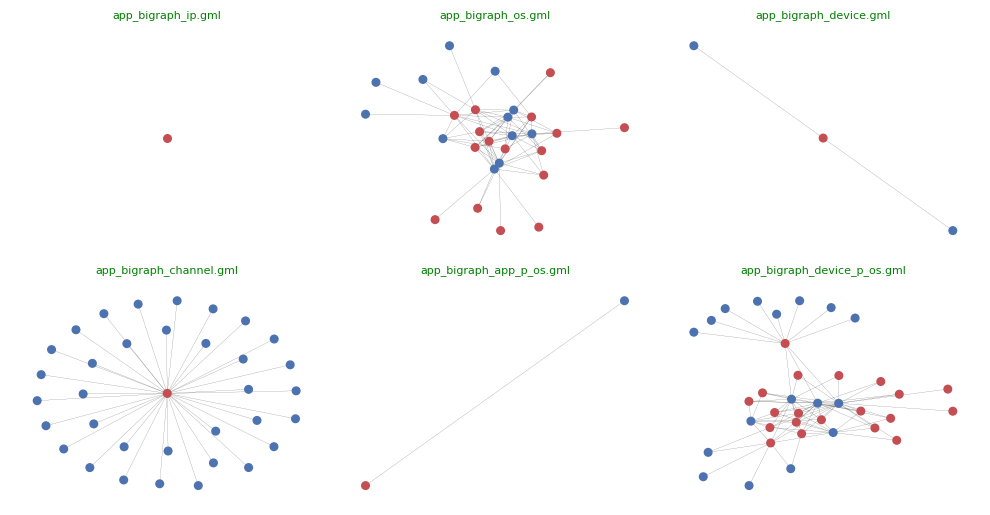

In [286]:
# 22.1 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                 graphsPath,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

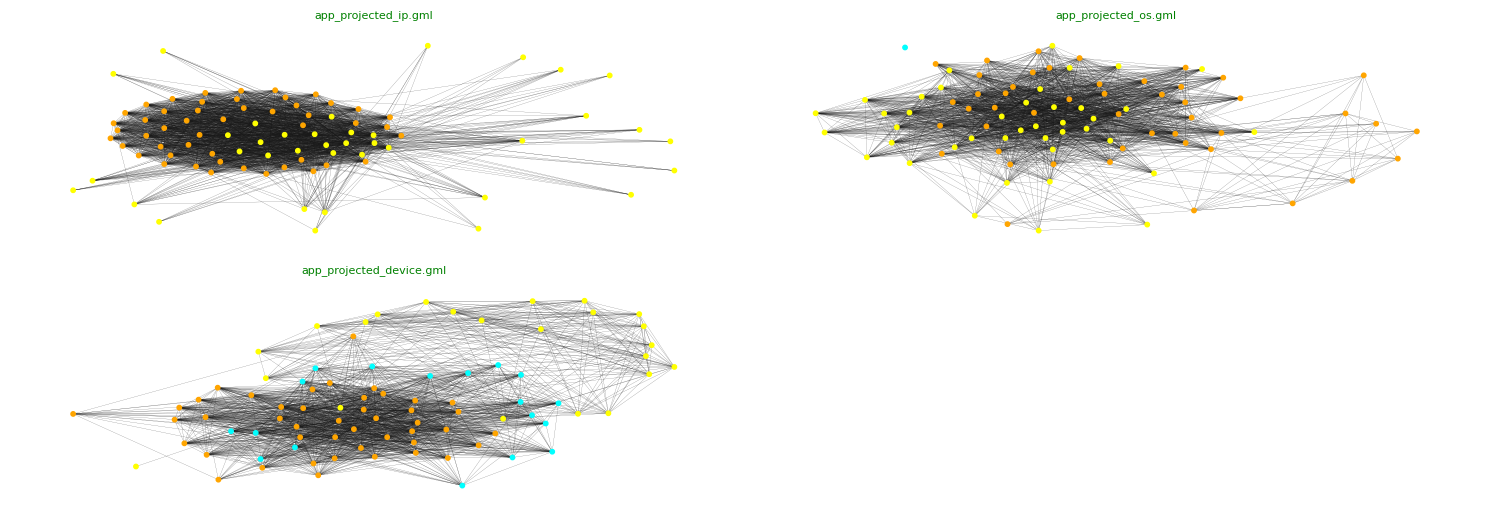

In [287]:
# 22.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   graphsPath,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph but a sample of it
                                   );
    plt.tight_layout();

In [79]:
# 24.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (3000806, 12)/(3002043, 12)/(3001476, 12)/(2998791, 12)/(2998791, 12)
print("\n--\n")
fg_te[0].shape   # (1000269, 12)/(1000682, 12)/(1000493, 12)/(999597, 12)/(999597, 12)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

(2998791, 12)


--



(999597, 12)


--



app_projected_device.gml  app_projected_os.gml  app_projected_channel.gml  \
0                         0                     1                          0   
1                         0                     1                          1   

   device_projected_app.gml  device_projected_os.gml  \
0                         2                        0   
1                         2                        0   

   device_projected_channel.gml  os_projected_app.gml  \
0                             0                     1   
1                             0                     1   

   os_projected_device.gml  os_projected_channel.gml  \
0                        0                         1   
1                        0                         1   

   channel_projected_app.gml  channel_projected_device.gml  \
0                          1                             1   
1                          1                             1   

   channel_projected_os.gml  
0                         2  
1                         1

app_projected_device.gml  app_projected_os.gml  app_projected_channel.gml  \
0                       0.0                   1.0                        0.0   
1                       0.0                   1.0                        0.0   

   device_projected_app.gml  device_projected_os.gml  \
0                       2.0                      0.0   
1                       2.0                      0.0   

   device_projected_channel.gml  os_projected_app.gml  \
0                           0.0                   1.0   
1                           0.0                   1.0   

   os_projected_device.gml  os_projected_channel.gml  \
0                      0.0                       0.0   
1                      0.0                       1.0   

   channel_projected_app.gml  channel_projected_device.gml  \
0                        2.0                           0.0   
1                        2.0                           1.0   

   channel_projected_os.gml  
0                       0.0  
1                       1.0

In [ ]:
# 23.0 Transform each column bin as per the community
#       to which it belongs:

# 23.1 Our transformed discrete cols are:
columnNames = cat_cols

# 23.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 23.3 Graph files are within:
#graphFolder= Path("D:\\talkingdata\\allmodels\\models\\")

# 23.4 Perform transformation of both train_binned and test_binend:
# 23.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 23.4.2 PErform transformation to community structure
#  Takes lots of time...

for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,graphsPath,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,graphsPath,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)

In [213]:
# 24.1 Remove constant columns, if any, from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 24.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (3747190, 12)
Datashape after processing: (3747190, 12)


In [214]:
# 24.2 Save the list:

utils.savePythonObject(fg_tr, "fg_tr.pkl", talkingdatadata)
utils.savePythonObject(fg_te, "fg_te.pkl", talkingdatadata)

Object saved to: D:\talkingdata\allmodels\datafiles\fg_tr.pkl
Object saved to: D:\talkingdata\allmodels\datafiles\fg_te.pkl


In [215]:
# 24.3 Retrieve back:

tr_comm = utils.restorePythonObject( "fg_tr.pkl", talkingdatadata )
te_comm = utils.restorePythonObject( "fg_te.pkl", talkingdatadata )
tr_comm[0].shape  # (2249729, 12)/(3002043, 12)/(2998791, 12)/(3747190, 12)
te_comm[0].shape  # (749910, 12)/(1000682, 12)/(999597, 12)/(1249064, 12)

(3747190, 12)

(1249064, 12)

In [216]:
# 24.4 Check restoration:

tr_comm[0].head(2)
te_comm[0].head(2)

app_projected_device.gml  app_projected_os.gml  app_projected_channel.gml  \
0                         0                     0                          0   
1                         0                     0                          0   

   device_projected_app.gml  device_projected_os.gml  \
0                         2                        1   
1                         2                        1   

   device_projected_channel.gml  os_projected_app.gml  \
0                             1                     1   
1                             1                     1   

   os_projected_device.gml  os_projected_channel.gml  \
0                        0                         1   
1                        0                         1   

   channel_projected_app.gml  channel_projected_device.gml  \
0                          2                             0   
1                          0                             0   

   channel_projected_os.gml  
0                         0  
1                         0

app_projected_device.gml  app_projected_os.gml  app_projected_channel.gml  \
0                       0.0                   0.0                        0.0   
1                       0.0                   0.0                        0.0   

   device_projected_app.gml  device_projected_os.gml  \
0                       2.0                      1.0   
1                       2.0                      1.0   

   device_projected_channel.gml  os_projected_app.gml  \
0                           1.0                   1.0   
1                           1.0                   1.0   

   os_projected_device.gml  os_projected_channel.gml  \
0                      0.0                       1.0   
1                      0.0                       1.0   

   channel_projected_app.gml  channel_projected_device.gml  \
0                          2                             1   
1                          1                             0   

   channel_projected_os.gml  
0                         1  
1                         0

In [217]:
# 24.5 Merge rem cols in it:

tr_comm[0] = pd.concat([X_train[rem_cols], tr_comm[0] ],  axis = 1)
te_comm[0] = pd.concat([X_test[rem_cols], te_comm[0] ], axis = 1)

# 24.6 Shapes?
tr_comm[0].shape  # (3002043, 17)/(3001476, 17)/(2998791, 17)/(3747190, 17)
te_comm[0].shape  # (1000682, 17)/(1000493, 17)/(999597, 17)/(1249064, 17)

(3747190, 17)

(1249064, 17)

## xgboost modeling with data transformed through community classes

In [218]:
# 25.0 Modeling with transformed train/test data with community indicators:


# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 500,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 15,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   tr_comm[0]
test_X = te_comm[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 100,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[18:34:59] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:35:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 978 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.85978	validation_1-auc:0.85466
[18:35:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 738 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.86015	validation_1-auc:0.85513
[18:35:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 952 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.86045	validation_1-auc:0.85530
[18:35:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 788 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.86103	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Learning curve

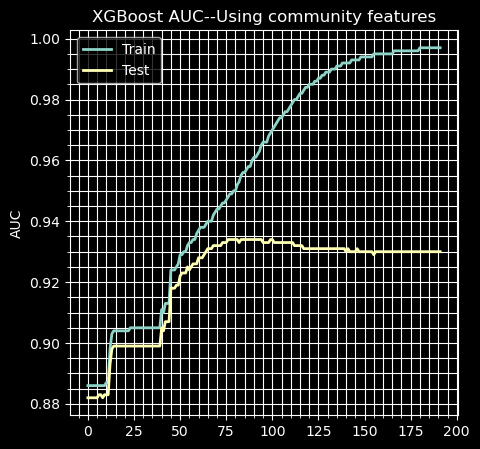

In [86]:
# 25.1 Modeling with Community data:

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid(visible = True, which = 'both')
plt.minorticks_on()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using community features");


In [220]:
# 25.2 Save model object
utils.savePythonObject(model_trans_commu, "model_trans_commu.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_trans_commu.pkl


In [221]:
# 25.3 Recall model object
model_trans_commu = utils.restorePythonObject("model_trans_commu.pkl", talkingdataestimators)

#### Classification report

In [222]:
# 25.4 Classification reports:

pred_comm = model_trans_commu.predict(test_X)
print(f"Classification report from community data: \n {classification_report(ytest,pred_comm)}")





Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1245963
           1       0.56      0.08      0.14      3101

    accuracy                           1.00   1249064
   macro avg       0.78      0.54      0.57   1249064
weighted avg       1.00      1.00      1.00   1249064



In [ ]:
"""
Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    997845
           1       0.67      0.05      0.10      2424

    accuracy                           1.00   1000269
   macro avg       0.83      0.53      0.55   1000269
weighted avg       1.00      1.00      1.00   1000269


Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    998259
           1       0.38      0.06      0.10      2423

    accuracy                           1.00   1000682
   macro avg       0.69      0.53      0.55   1000682
weighted avg       1.00      1.00      1.00   1000682

Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    998061
           1       0.41      0.03      0.05      2432

    accuracy                           1.00   1000493
   macro avg       0.70      0.51      0.52   1000493
weighted avg       1.00      1.00      1.00   1000493

Classification report from community data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    997124
           1       0.63      0.18      0.28      2473

    accuracy                           1.00    999597
   macro avg       0.81      0.59      0.64    999597
weighted avg       1.00      1.00      1.00    999597



"""

### Horizontally concatenate to pca data rem cols

In [64]:
# 31 Now horizontally concatenate:

cctr_rem = pd.concat([X_train[rem_cols], cctr],  axis = 1)
ccte_rem = pd.concat([X_test[rem_cols], ccte], axis = 1)
                           
# 31.1 Check
cctr_rem.shape  # (3750000, 24)
ccte_rem.shape   # (1250000, 24)

(3750000, 24)

(1250000, 24)

In [67]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, RandomUnderSampler

In [68]:
start = time.time()
renn = RepeatedEditedNearestNeighbours(max_iter = 3)
X_res, y_res = renn.fit_resample(cctr_rem, y_train)
end = time.time()
print((end-start)/60)  # 338 min

338.439654203256


In [70]:
## xgboost modeling of above concatenated data

# 31.2 Perform xgboost modeling using the above pca_train_trans/pca_test_trans data:

model_vec_imb_full = xgb.XGBClassifier( n_estimators= 250,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 10,
                              subsample = 0.9,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )


tr_X =    X_res
test_X =  ccte_rem
ytrain =  y_res
ytest = y_test


model_vec_imb_full.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )




[11:55:52] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[11:55:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.88818	validation_1-auc:0.89214
[11:55:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 628 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.88837	validation_1-auc:0.89185
[11:56:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 668 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.88838	validation_1-auc:0.89188
[11:56:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 654 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.88870	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [71]:
# 31.3 Save model object:

utils.savePythonObject(model_vec_imb_full, "model_vec_imb_full.pkl", estimatorsPath)

Object saved to: D:\talkingdata\allmodels\estimators\model_vec_imb_full.pkl


In [72]:
# 31.4 Rstore model object:

model_vec_imb_full = utils.restorePythonObject("model_vec_imb_full.pkl", estimatorsPath)

In [73]:
# 31.5 Best scores with 'ip' and datetime related columns:

model_vec_imb_full.best_score   # 0.9658114/0.96369714/0.961902744/0.957092431030187
print("\n")
model_vec_imb_full.best_iteration  # 141/180/105/100/117

0.9669686227318209

198

In [74]:
# 31.6 Classification report with 'ip' and datetime related columns::

pred_vec_imb_full = model_vec_imb_full.predict(test_X)
uvec_cl_ip=classification_report(ytest,pred_vec_imb_full)
print(uvec_cl_ip)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246867
           1       0.49      0.46      0.47      3133

    accuracy                           1.00   1250000
   macro avg       0.74      0.73      0.74   1250000
weighted avg       1.00      1.00      1.00   1250000



In [76]:
X_res.to_pickle(dataPath / "X_res.pkl")
y_res.to_pickle(dataPath / "y_res.pkl")

In [77]:
X_res = pd.read_pickle(dataPath / "X_res.pkl")
y_res = pd.read_pickle(dataPath / "y_res.pkl")

In [78]:
X_res.shape
y_res.shape

(3728994, 24)

(3728994,)

In [82]:
# 14.0
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise f1_score.


# 14.1 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_res, y_res)
    # Make predictions
    y_pred = optuna_model.predict(ccte_rem)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, pos_label = 1)
    # Maximise f1-score
    return f1



# 14.2 Create optuna study
study = optuna.create_study(direction='maximize')

# 14.3 Begin optimization
study.optimize(objective, n_trials=300)

# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)

[I 2023-08-26 12:53:25,909] A new study created in memory with name: no-name-91b5d6f4-75f2-4168-8473-59016fa9ae1f
[I 2023-08-26 12:54:11,018] Trial 0 finished with value: 0.2976164913034142 and parameters: {'max_depth': 2, 'learning_rate': 0.08240929501478278, 'n_estimators': 131, 'min_child_weight': 7, 'gamma': 1.0314078692423046e-06, 'subsample': 0.45606996025388985, 'colsample_bytree': 0.10707162810718072, 'reg_alpha': 0.0005609859570170992, 'reg_lambda': 0.2425426520387884}. Best is trial 0 with value: 0.2976164913034142.
[I 2023-08-26 12:57:50,961] Trial 1 finished with value: 0.37489516354486996 and parameters: {'max_depth': 3, 'learning_rate': 0.9500786665423141, 'n_estimators': 491, 'min_child_weight': 10, 'gamma': 2.3693327097140806e-08, 'subsample': 0.02495845255678369, 'colsample_bytree': 0.32027307386421133, 'reg_alpha': 0.0005148654629821815, 'reg_lambda': 0.001975480593164202}. Best is trial 1 with value: 0.37489516354486996.
[I 2023-08-26 13:05:18,481] Trial 2 finished w

In [83]:
# 14.4 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# 14.4.1 Best trial
trial = study.best_trial
trial.value   # Best trial result (f1-score)
# Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 300


0.4838020062489722

    max_depth: 8
    learning_rate: 0.16887655923160663
    n_estimators: 179
    min_child_weight: 10
    gamma: 3.721967985245748e-06
    subsample: 0.87810990366264
    colsample_bytree: 0.36237609250493363
    reg_alpha: 0.3550481666158073
    reg_lambda: 3.1526354826366224e-08


In [87]:
# 15.0 Use these parameters in our estimator:
best_params = trial.params

model_vec_hyp = xgb.XGBClassifier(**best_params)
model_vec_hyp.fit(X_res, y_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.36237609250493363, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3.721967985245748e-06, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.16887655923160663, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=179, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [97]:
best_params

{'max_depth': 8,
 'learning_rate': 0.16887655923160663,
 'n_estimators': 179,
 'min_child_weight': 10,
 'gamma': 3.721967985245748e-06,
 'subsample': 0.87810990366264,
 'colsample_bytree': 0.36237609250493363,
 'reg_alpha': 0.3550481666158073,
 'reg_lambda': 3.1526354826366224e-08}

In [88]:
# 15.1 Make predictions and assessments:

y_pred_hyp = model_vec_hyp.predict(ccte_rem)

print(classification_report(y_test, y_pred_hyp))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246867
           1       0.50      0.47      0.48      3133

    accuracy                           1.00   1250000
   macro avg       0.75      0.73      0.74   1250000
weighted avg       1.00      1.00      1.00   1250000



In [134]:
gc.collect()

1449

In [135]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
params={
         'min_child_weight': Integer(0, 5),  # min no of instances needed to be in each node before split
         'max_depth': Integer(5, 10),         # Maximum depth of a tree.
         'subsample': Real (0.5, 1.0, 'uniform'),  # Subsample ratio of the training instances.
                                                   # Setting it to 0.5 means that XGBoost would
                                                   # randomly sample half of the training data prior
                                                   # to growing trees. and this will prevent overfitting.
         'colsample_bytree': Real(0.5, 1.0, 'uniform'), # subsample ratio of cols when constructing each tree
         'colsample_bylevel': Real(0.01, 1.0, 'uniform'), 
         'reg_lambda':Real(1e-7,100,prior = 'log-uniform'), # L2 reg term on weights. Increasing this value will make model more conservative
         'reg_alpha': Real(1e-7,100,prior= 'log-uniform'),  # L1 reg
         'gamma': Real(1e-9, 0.5, 'log-uniform'),   # Min loss reduction required to make a further partition
                                                    # on a leaf node of the tree. The larger gamma is, the
                                                    # more conservative the algorithm will be leading to simpler models.
         'learning_rate': Real(0.01,0.2,prior='log-uniform'), # How much weight should shrink after each step
                                                              # to make boosting process (NOT model) more conservative
         'scale_pos_weight': Real(1e-6, 5, 'log-uniform'),  # Control the balance of pos and neg weights, useful for unbalanced classes
         'n_estimators': Integer(100, 200)   # Max number of trees
        }




bayes_tuner=BayesSearchCV(
                            xgb.XGBClassifier(
                                            n_jobs = -1,
                                            objective = 'binary:logistic',
                                            eval_metric = 'auc',
                                            silent=1,
                                            tree_method='approx'
                                            ),
                            params,
                            n_iter=100,              # No of parameter settings that are tried
                            scoring='roc_auc',     # The criteria for best model. Maximise
                            optimizer_kwargs={     # Dict of arguments passed to Optimizer.
                                               'n_initial_points' : 5,  # Initial random pts before intelligence sets in
                                                                        #  default: 10
                                               'initial_point_generator':'random' # Random serach for init pts
                                              },
                            cv = StratifiedKFold(
                                                  n_splits=3,
                                                  shuffle=True,
                                                  random_state=42
                                                ),
                            refit = True, # Refit the best estimator
                                          #   so as to make predictions
                            verbose = 1,
                            return_train_score= True
                    )


In [127]:
# 10.2 This function is called after each parameter
#      fitting to print current status:

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    # 10.2.1 Get all the models tested so far in DataFrame format
    # cv_results_: A dict with keys as column headers and
    #              values as columns
    #        model_results dataframe is not being printed
    #model_results = pd.DataFrame(bayes_tuner.cv_results_)

    # 10.2.2 Get current parameters and the best parameters
    # best_params_: A dict of parameter settings that
    #               give the best results on the hold out data.
    #best_params = pd.Series(bayes_tuner.best_params_)
    #best_score = pd.Series(bayes_tuner.best_score_)

    print(bayes_tuner.optimizer_results_),  # Score of best_estimator on the left out data.
   


In [136]:
start = time.time()
res=bayes_tuner.fit(
                      X_res,
                      y_res,
                      #callback=status_print
                    )

end = time.time()

f"{(end - start)/60} minutes "    # 3 minutes on Colab

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[13:20:03] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:21:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:22:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[13:23:27] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:24:41] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[13:25:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

Fitting 3 folds for each of 1 candidates, 

'434.6909828146299 minutes '

In [138]:
res.best_score_
res.best_params_


0.9644859140745381

OrderedDict([('colsample_bylevel', 1.0),
             ('colsample_bytree', 0.5),
             ('gamma', 0.022491709004137623),
             ('learning_rate', 0.08180649119681357),
             ('max_depth', 10),
             ('min_child_weight', 5),
             ('n_estimators', 158),
             ('reg_alpha', 1e-07),
             ('reg_lambda', 1e-07),
             ('scale_pos_weight', 0.5426159562647138),
             ('subsample', 1.0)])

In [139]:
# 15.1 Make predictions and assessments:

y_pred_bayes = res.predict(ccte_rem)

print(classification_report(y_test, y_pred_bayes))
roc_score = roc_auc_score(y_test, y_pred_bayes)
print(roc_score)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246867
           1       0.61      0.37      0.46      3133

    accuracy                           1.00   1250000
   macro avg       0.80      0.68      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000

0.684828130468466


In [106]:
# 14.0
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise roc_score.


# 14.1 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 10, 13),
               'scale_pos_weight' : trial.suggest_int('scale_pos_weight', 2, 5),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.1),
              'n_estimators': trial.suggest_int('n_estimators', 120, 250),
              'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
              'gamma': trial.suggest_loguniform('gamma', 0.01, 0.05),
              'subsample': trial.suggest_loguniform('subsample', 0.6, 0.9),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.6, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 0.0005),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1e-6),
              'eval_metric': 'auc',
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_res, y_res)
    # Make predictions
    y_pred = optuna_model.predict(ccte_rem)

    # Evaluate predictions
    roc_score = roc_auc_score(y_test, y_pred)
    # Maximise roc_score
    return roc_score



# 14.2 Create optuna study
study1 = optuna.create_study(direction='maximize')

# 14.3 Begin optimization
study1.optimize(objective, n_trials=500)

# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)

[I 2023-08-28 09:39:17,687] A new study created in memory with name: no-name-8aa9df82-5e6c-4842-bb73-4880c1bb2e63
[I 2023-08-28 09:48:08,203] Trial 0 finished with value: 0.8151136380391064 and parameters: {'max_depth': 12, 'scale_pos_weight': 5, 'learning_rate': 0.09621274932274435, 'n_estimators': 165, 'min_child_weight': 3, 'gamma': 0.02886651338157224, 'subsample': 0.6203329907966985, 'colsample_bytree': 0.9702218632346636, 'reg_alpha': 0.00037783920798787154, 'reg_lambda': 7.424566109366558e-07}. Best is trial 0 with value: 0.8151136380391064.
[I 2023-08-28 09:56:39,607] Trial 1 finished with value: 0.7809554716969104 and parameters: {'max_depth': 13, 'scale_pos_weight': 3, 'learning_rate': 0.05765226790079576, 'n_estimators': 169, 'min_child_weight': 0, 'gamma': 0.014313998203931005, 'subsample': 0.7278363320268239, 'colsample_bytree': 0.8110003930409877, 'reg_alpha': 0.00015725750716912135, 'reg_lambda': 2.3594802341317454e-07}. Best is trial 0 with value: 0.8151136380391064.
[I

KeyboardInterrupt: 

In [102]:
Best_Params = {'colsample_bylevel': 0.955923206446829,
               'colsample_bytree': 0.7036152301751524,
               'gamma': 0.03823613443879595,
               'learning_rate': 0.06786442521779147,
               'max_delta_step': 8,
               'max_depth': 11,
               'min_child_weight': 0,
               'n_estimators': 169,
               'reg_alpha': 0.00022356829889037284,
               'reg_lambda': 1.2908532337409298e-07,
               'scale_pos_weight': 4.73588486119117,
               'subsample': 0.4499578015509351}



model_kaggle = xgb.XGBClassifier(**Best_Params,verbose = 3)
model_kaggle.fit(X_res, y_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.955923206446829, colsample_bynode=None,
              colsample_bytree=0.7036152301751524, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.03823613443879595, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.06786442521779147, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=8,
              max_depth=11, max_leaves=None, min_child_weight=0, missing=nan,
              monotone_constraints=None, n_estimators=169, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [103]:
# 15.1 Make predictions and assessments:

y_pred_kaggle = model_kaggle.predict(ccte_rem)

print(classification_report(y_test, y_pred_kaggle))
roc_score = roc_auc_score(y_test, y_pred_kaggle)
print(roc_score)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246867
           1       0.37      0.63      0.47      3133

    accuracy                           1.00   1250000
   macro avg       0.69      0.81      0.73   1250000
weighted avg       1.00      1.00      1.00   1250000

0.8145053476364472


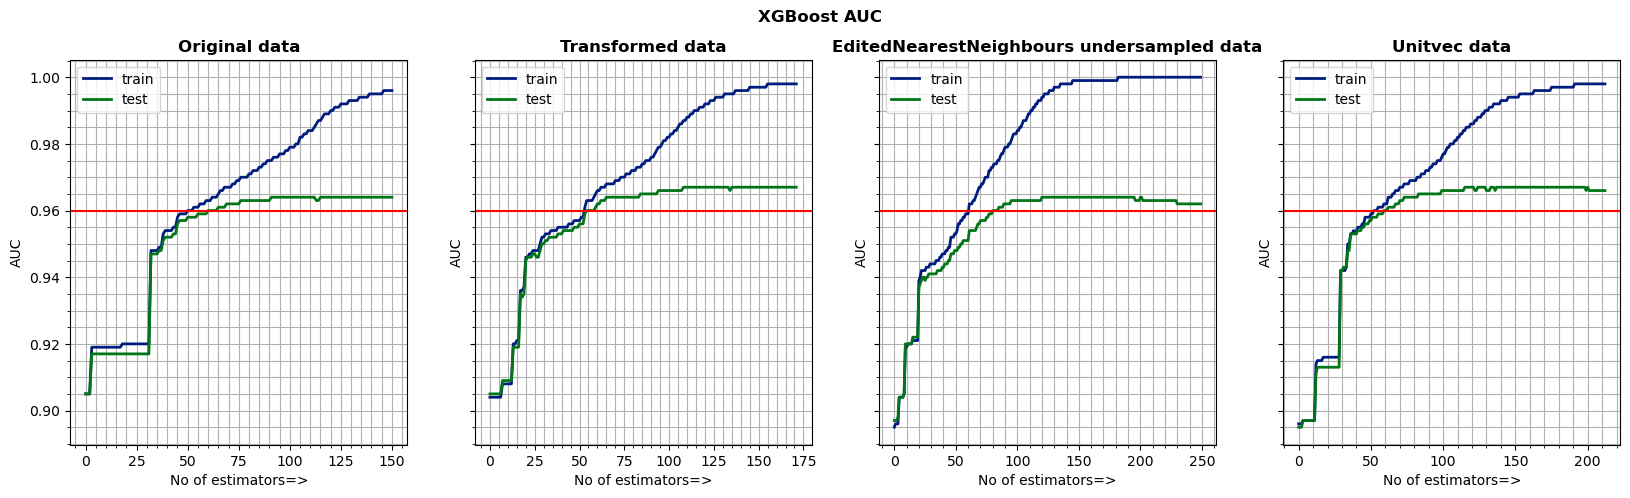

In [26]:
# 30.3 Learning curve

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);

results = [model_orig.evals_result(),model_trans.evals_result(), model_en.evals_result(), model_vec_full.evals_result() ]
title = ["Original data", 'Transformed data', 'EditedNearestNeighbours undersampled data', 'Unitvec data']
fig.suptitle("XGBoost AUC", fontweight = "bold")

for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y = 0.96, color = 'r', linestyle = '-')

plt.show();




In [ ]:
##*****************************
## Embedding Projector

##*****************************

In [260]:
# 33
# 33.1 Get target data col. Needed for generation of meta-data file:


train_trans['target'] =  y_train

vec_tr_mean,_ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = talkingdataunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avged"     
                           )



Checking if vectors exist for all cat cols...
May take time...
Checked for app
Checked for device
Checked for os
Checked for channel
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'D:\talkingdata\allmodels\unitvec'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


## Feature Engineering through clustering

In [261]:
# 34.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 12,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

Current index:  0
Current index:  4
Current index:  8
Current index:  12


In [262]:
# 34.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

pcapp0    pcapp1    pcapp2    pcapp3  pcdevice0  pcdevice1  pcdevice2  \
0  3.671103 -0.865406 -3.050680  0.368654  -0.398636   0.787238  -0.200491   
1 -0.507002  5.354653  1.565948 -1.754986  -0.407465   0.640545   0.203725   
2 -1.717272  0.717173 -0.062780  2.593551  -0.407952   0.641808   0.018090   

   pcdevice3     pcos0     pcos1     pcos2     pcos3  pcchannel0  pcchannel1  \
0   0.136411 -1.280446  0.294047 -1.937024  0.671268   -0.435268   -4.143646   
1  -0.024267 -1.244083  0.230523 -1.406424  0.218394    4.800220   -3.767235   
2  -0.353882 -1.279417  0.218141 -1.871620  0.501109   -0.497745   -0.122144   

   pcchannel2  pcchannel3  clu0  clu1  clu2  clu3  
0    0.843768    1.534261     5     0     1     5  
1   -0.564055    1.484366     6     0     1     9  
2   -1.385875    0.130813     8     0     1     2

pcapp0    pcapp1    pcapp2    pcapp3  pcdevice0  pcdevice1  pcdevice2  \
0 -0.808483 -1.538319 -0.429401 -0.367411   0.147834 -11.889017   2.163232   
1 -1.543873 -3.447913  1.313072  2.381807  -0.407763   0.641912  -0.019017   
2 -3.865766 -0.401923  1.810693 -2.645520  -0.407763   0.641912  -0.019017   

   pcdevice3     pcos0     pcos1     pcos2     pcos3  pcchannel0  pcchannel1  \
0   0.132562 -1.244024  0.229337 -1.415404  0.202054   -2.829218    1.087118   
1  -0.014087 -1.244024  0.229337 -1.415404  0.202054   -0.588555   -1.348168   
2  -0.014087  0.438189 -0.555378  1.507220 -0.226979   -3.164828    0.564920   

   pcchannel2  pcchannel3  clu0  clu1  clu2  clu3  
0    0.843500   -1.472553    10     2     1     3  
1   -0.291152   -0.288995     4     0     1     2  
2   -1.335926   -1.086098     3     0     0     0

In [263]:
# 34.2 Have a look at clusters created:

fe_tr[fe_tr.columns[-len(cat_cols):]].head()
fe_te[fe_te.columns[-len(cat_cols):]].head()

clu0  clu1  clu2  clu3
0     5     0     1     5
1     6     0     1     9
2     8     0     1     2
3    11     2    10     2
4     2     0     1    10

clu0  clu1  clu2  clu3
0    10     2     1     3
1     4     0     1     2
2     3     0     0     0
3    11     0     9     0
4     2     0     7     2

In [264]:
# 34.3
model_fe = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

tr_X =   fe_tr[fe_tr.columns[-len(cat_cols):]]
test_X =  fe_te[fe_te.columns[-len(cat_cols):]]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[09:33:23] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[09:33:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.77322	validation_1-auc:0.77211
[09:33:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.77322	validation_1-auc:0.77212
[09:33:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation_0-auc:0.77326	validation_1-auc:0.77214
[09:33:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation_0-auc:0.77327	validation_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [268]:
# 34.4 Save model object:

utils.savePythonObject(model_fe, "model_fe.pkl", talkingdataestimators)

Object saved to: D:\talkingdata\allmodels\estimators\model_fe.pkl


In [269]:
# 34.5 Restore model object:

model_fe = utils.restorePythonObject("model_fe.pkl", talkingdataestimators)

In [270]:
# 34.6


model_fe.best_score  # 0.938681430882942

0.9386814308829429

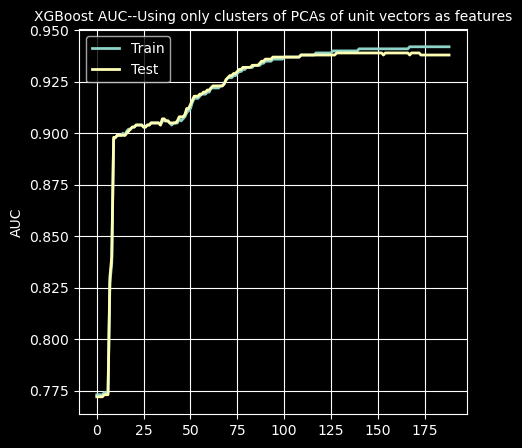

In [266]:
# 34.7 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);

     

In [ ]:
###################Done##################

In [ ]:
#### ROUGH WORK ##########
#### ROUGH WORK ##########

In [267]:
gc.collect()

4284

In [65]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [66]:
r1= cctr.astype(np.float16)
pca_train_unit, _, y_train_unit, _ = train_test_split(r1,y_train, train_size = 30000, stratify = y_train)

In [67]:
pca_train_unit.shape  # (20000, 16)
y_train_unit.shape   # (20000, )
y_train_unit.sum()   # 49
pca_train_unit.dtypes

(30000, 16)

(30000,)

73

pcapp0        float16
pcapp1        float16
pcapp2        float16
pcapp3        float16
pcdevice0     float16
pcdevice1     float16
pcdevice2     float16
pcdevice3     float16
pcos0         float16
pcos1         float16
pcos2         float16
pcos3         float16
pcchannel0    float16
pcchannel1    float16
pcchannel2    float16
pcchannel3    float16
dtype: object

In [68]:
ex1 = pca_train_unit.iloc[:, 0:4]
ex2 = pca_train_unit.iloc[:,4:8]
ex3 = pca_train_unit.iloc[:,8:12]
ex4 = pca_train_unit.iloc[:,12:16]
gc.collect()

72

In [69]:
gc.collect()

0

In [70]:
x1 = cosine_similarity(ex1)
x2 = cosine_similarity(ex2)
x3 = cosine_similarity(ex3)
x4 = cosine_similarity(ex4)

In [71]:
x1.shape
x2.shape
x3.shape
x4.shape

(30000, 30000)

(30000, 30000)

(30000, 30000)

(30000, 30000)

In [72]:
kmeans1 = KMeans(n_clusters = 20)
kmeans2 = KMeans(n_clusters = 20)
kmeans3 = KMeans(n_clusters = 20)
kmeans4 = KMeans(n_clusters = 20)


In [73]:
kx1 = kmeans1.fit_transform(x1)
print("d1")
gc.collect()
kx2 = kmeans2.fit_transform(x2)
print("d2")
kx3 = kmeans3.fit_transform(x3)
print("d3")
kx4 = kmeans4.fit_transform(x4)
print("d4")
gc.collect()

d1


183

d2
d3
d4


150

In [74]:
gc.collect()

0

In [11]:
# 26.1 A quick readback all saved files

train_trans = pd.read_pickle(Path(talkingdatadata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(talkingdatadata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(talkingdatadata) / "X_train.pkl")
X_test = pd.read_pickle(Path(talkingdatadata) / "X_test.pkl")
y_train = pd.read_pickle(Path(talkingdatadata) / "y_train.pkl")
y_test = pd.read_pickle(Path(talkingdatadata) / "y_test.pkl")


# 26.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 26.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 26.2.3
train_trans.shape   # (3000806, 136)/(3002043, 136)/(3001476, 136)
y_train.shape       # (3000806, )/(3002043, )/(3001476, )
test_trans.shape    # (1000269, 136)/(1000682, 136)/(1000493, 136)
y_test.shape        # (1000269, )/(1000682, )/(1000493, )


# 26.2.4 Our cat cols
cat_cols = ['app', 'device', 'os', 'channel']  # 4cols

# 26.2.5 Remaining cols not treated as cat cols:
rem_cols = {'ip', 'minute', 'day', 'hour', 'second'} # 5 cols


# 26.3 Concat rem_cols with transformed data:

# 26.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 26.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], test_trans[cols] ], axis = 1)
                           
# 26.6 Check
X_train_trans.shape  # (3000806, 137)/(3002043, 137)/(3001476, 137)
X_test_trans.shape   # (3000806, )/(1000682, 137)/(1000493, 137)



app  device  os  channel  deg_app_ck_device  eig_app_ck_device  \
0   13       1  13      477           0.809917           0.076224   
1   22       1  19      116           0.779614           0.074330   

   pr_app_ck_device  clu_app_ck_device  bet_app_ck_device  deg_app_ck_os  ...  \
0          0.003801           0.697174           0.002960       0.834711  ...   
1          0.003666           0.717791           0.002223       0.834711  ...   

   deg_channel_ck_device_p_os  eig_channel_ck_device_p_os  \
0                    0.971591                    0.077525   
1                    0.960227                    0.077257   

   pr_channel_ck_device_p_os  clu_channel_ck_device_p_os  \
0                   0.005920                    0.970210   
1                   0.005838                    0.986616   

   bet_channel_ck_device_p_os  deg_channel_ck_app_p_os  \
0                    0.000757                 0.164773   
1                    0.000093                 0.005682   

   eig_channel_ck_app_p_os  pr_channel_ck_app_p_os  clu_channel_ck_app_p_os  \
0             3.902822e-02                0.004952                 0.633005   
1             2.230271e-17                0.004544                 0.000000   

   bet_channel_ck_app_p_os  
0                 0.004242  
1                 0.000000  

[2 rows x 136 columns]

app  device  os  channel  deg_app_ck_device  eig_app_ck_device  \
0    3       2  19      280           0.809917           0.076224   
1   15       1  19      245           0.768595           0.073619   

   pr_app_ck_device  clu_app_ck_device  bet_app_ck_device  deg_app_ck_os  ...  \
0          0.003801           0.697174           0.002960       0.837466  ...   
1          0.003617           0.724014           0.002355       0.834711  ...   

   deg_channel_ck_device_p_os  eig_channel_ck_device_p_os  \
0                    0.977273                    0.077637   
1                    0.965909                    0.077355   

   pr_channel_ck_device_p_os  clu_channel_ck_device_p_os  \
0                   0.005963                    0.961648   
1                   0.005884                    0.977445   

   bet_channel_ck_device_p_os  deg_channel_ck_app_p_os  \
0                    0.000865                 0.397727   
1                    0.000694                 0.289773   

   eig_channel_ck_app_p_os  pr_channel_ck_app_p_os  clu_channel_ck_app_p_os  \
0                 0.121408                0.009006                 0.604141   
1                 0.074779                0.006935                 0.657255   

   bet_channel_ck_app_p_os  
0                 0.008494  
1                 0.003071  

[2 rows x 136 columns]

ip  app  device  os  channel  day  hour  minute  second
0  128686   13       1  13      477    7     4       8      30
1   55146   22       1  19      116    9    12      30       0

ip  app  device  os  channel  day  hour  minute  second
0  44961    3       2  19      280    7     1      42       4
1  62900   15       1  19      245    8    20      18      33

(3747190, 136)

(3747190,)

(1249064, 136)

(1249064,)

(3747190, 137)

(1249064, 137)

In [76]:
 kmeans1.labels_

array([ 5,  6, 14, ..., 13,  4,  0])

In [77]:
pca_train_unit["k1"] = kmeans1.labels_
pca_train_unit["k2"] = kmeans2.labels_
pca_train_unit["k3"] = kmeans3.labels_
pca_train_unit["k4"] = kmeans4.labels_


In [78]:
pca_train_unit.shape

(30000, 20)

In [110]:
tr, te, ytr,yte = train_test_split(pca_train_unit,y_train_unit, test_size = 0.25, stratify = y_train_unit)

In [113]:
## xgboost modeling of above concatenated data

# 31.2 Perform xgboost modeling using the above pca_train_trans/pca_test_trans data:
del mkm
mkm = xgb.XGBClassifier( n_estimators= 100,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 11,
                              #subsample = 0.8,
                              random_state = rng,
                             
                           )

## NOTE THIS IS WITH 'ip' and other numeric columns
tr_X =    tr.iloc[:,-4:]
test_X =  te.iloc[:,-4:]
ytrain =  ytr
ytest = yte


mkm.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )




[13:21:54] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[13:21:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-auc:0.56304	validation_1-auc:0.49920
[13:21:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-auc:0.56304	validation_1-auc:0.49920
[13:21:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-auc:0.56304	validation_1-auc:0.49920
[13:21:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-auc:0.56304	validation_1-auc:0.4

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [112]:
# 31.4 Classification report with 'ip' and datetime related columns::

pred_te = mkm.predict(test_X)
stp=classification_report(yte,pred_te)
print(stp)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7482
           1       0.00      0.00      0.00        18

    accuracy                           1.00      7500
   macro avg       0.50      0.50      0.50      7500
weighted avg       1.00      1.00      1.00      7500



In [105]:
## Rough
gc.collect()

22244

In [41]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, RandomUnderSampler, NearMiss,OneSidedSelection

In [13]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, RandomUnderSampler
start = time.time()
renn = RepeatedEditedNearestNeighbours(max_iter = 3)
X_res, y_res = renn.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 348 min


347.540420905749


In [14]:
X_res.shape  # (3734643, 25)

(3734643, 25)

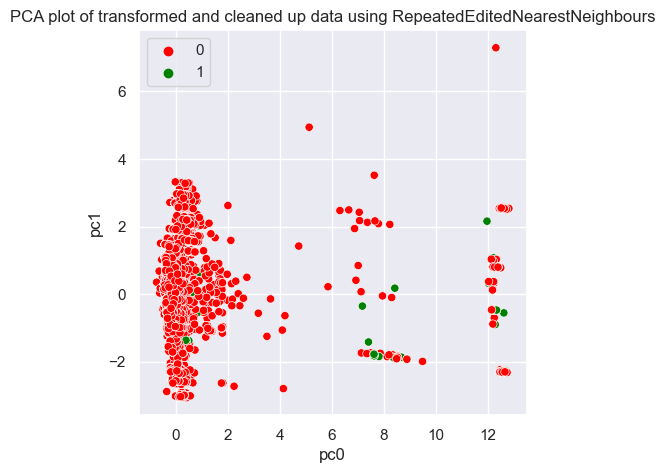

In [17]:
# 18.0.3 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res, y_res, test_size = 50000, stratify = y_res)
#pca_tr= X_res # (50000, 26)
#pca_y= y_res   # (5000,)

pca_tr.shape


fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; 
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA plot of transformed and cleaned up data using RepeatedEditedNearestNeighbours') ;

In [16]:
gc.collect()

301

In [18]:
# 19.0 Modeling with smoteenn data (without ip and rem features)

model_ren = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 12,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_ren.fit(tr_X, ytrain.values,                  
                early_stopping_rounds = 50,   
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']    
                )



[15:23:56] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[15:24:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 962 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation_0-auc:0.89171	validation_1-auc:0.88313
[15:24:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 852 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation_0-auc:0.89457	validation_1-auc:0.88615
[15:24:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 868 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation_0-auc:0.89564	validation_1-auc:0.88692
[15:24:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 862 extra nodes, 0 pruned nodes, max_depth=12
[3]	validation_0-auc:0.89602	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [20]:
# 31.4 Classification report with 'ip' and datetime related columns::

pred_ren = model_ren.predict(test_X)
stp=classification_report(y_test,pred_ren)
print(stp)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1247914
           1       0.48      0.59      0.53      3116

    accuracy                           1.00   1251030
   macro avg       0.74      0.79      0.76   1251030
weighted avg       1.00      1.00      1.00   1251030



In [42]:
rus = OneSidedSelection()

X_res, y_res = rus.fit_resample(pca_train, y_train)

In [43]:
X_res.shape  # (3740358, 25)

(3740358, 25)

In [44]:
# 19.0 Modeling with smoteenn data (without ip and rem features)

model_rus = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 12,
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_rus.fit(tr_X, ytrain.values,                  
                early_stopping_rounds = 50,   
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']    
                )



[05:28:01] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[05:28:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1190 extra nodes, 0 pruned nodes, max_depth=12
[0]	validation_0-auc:0.89133	validation_1-auc:0.88401
[05:28:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1080 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation_0-auc:0.89186	validation_1-auc:0.88459
[05:28:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1120 extra nodes, 0 pruned nodes, max_depth=12
[2]	validation_0-auc:0.89220	validation_1-auc:0.88460
[05:28:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1126 extra nodes, 0 pruned nodes, max_depth=12
[3]	validation_0-auc:0.89498	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [45]:
# 31.4 Classification report with 'ip' and datetime related columns::

pred_rus = model_rus.predict(test_X)
cl_rus=classification_report(y_test,pred_rus)
print(cl_rus)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1247914
           1       0.68      0.40      0.51      3116

    accuracy                           1.00   1251030
   macro avg       0.84      0.70      0.75   1251030
weighted avg       1.00      1.00      1.00   1251030

